In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical

def build_and_train_lstm(input_filename, model_output_filename):
    """
    Loads the feature-engineered dataset, preprocesses it for an LSTM,
    builds, trains, and saves a time-series classification model.
    """
    try:
        # --- Step 1: Load and Prepare Data ---
        print(f"Loading data from '{input_filename}'...")
        df = pd.read_csv(input_filename)

        # The 'Date' column is not needed for training, but useful for reference
        dates = pd.to_datetime(df['Date'])
        df = df.drop(columns=['Date'])

        # Separate features (X) and the target variable (y)
        X = df.drop(columns=['Crisis_Target']).astype('float32')
        y = df['Crisis_Target'].astype('int')

        print("Data loaded successfully.")
        print(f"Shape of features (X): {X.shape}")
        print(f"Shape of target (y): {y.shape}")

        # --- Step 2: Scale Features and One-Hot Encode Target ---
        print("\nStep 2: Scaling features and encoding target...")

        # Scale all feature columns to a range of [0, 1]
        scaler = MinMaxScaler(feature_range=(0, 1))
        X_scaled = scaler.fit_transform(X)

        # One-hot encode the target variable for classification (e.g., 2 -> [0, 0, 1, 0])
        # Assumes 4 crisis levels (0, 1, 2, 3)
        y_categorical = to_categorical(y, num_classes=4)

        # --- Step 3: Create Time-Series Sequences ---
        print("Step 3: Creating time-series sequences...")

        # We will use a sequence of the last 60 days to predict the next day
        sequence_length = 60

        X_sequences, y_sequences = [], []
        for i in range(len(X_scaled) - sequence_length):
            X_sequences.append(X_scaled[i:i + sequence_length])
            y_sequences.append(y_categorical[i + sequence_length])

        X_sequences = np.array(X_sequences)
        y_sequences = np.array(y_sequences)

        print(f"Created sequences. Shape of X: {X_sequences.shape}, Shape of y: {y_sequences.shape}")

        # Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=42)

        # --- Step 4: Build the LSTM Model Architecture ---
        print("\nStep 4: Building the LSTM model...")

        model = Sequential()

        # First LSTM layer with dropout
        # return_sequences=True is needed to pass the output to the next LSTM layer
        model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dropout(0.2))

        # Second LSTM layer
        model.add(LSTM(units=100, return_sequences=True))
        model.add(Dropout(0.2))

        # Third LSTM layer
        # return_sequences=False as this is the last LSTM layer
        model.add(LSTM(units=50))
        model.add(Dropout(0.2))

        # Output Layer
        # The output layer has 4 neurons (for 4 crisis classes) and uses 'softmax' activation
        # for multi-class classification.
        model.add(Dense(units=4, activation='softmax'))

        print("Model architecture defined.")
        model.summary()

        # --- Step 5: Compile the Model ---
        print("\nStep 5: Compiling the model...")
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        # --- Step 6: Train the Model ---
        print("\nStep 6: Training the model...")
        history = model.fit(
            X_train, y_train,
            epochs=50,  # Number of times to iterate over the entire dataset
            batch_size=32, # Number of samples per gradient update
            validation_data=(X_test, y_test),
            verbose=1
        )

        print("\nModel training complete.")

        # --- Step 7: Save the Trained Model ---
        print(f"\nStep 7: Saving the trained model to '{model_output_filename}'...")
        model.save(model_output_filename)
        print("Model saved successfully.")

    except FileNotFoundError:
        print(f"Error: The input file '{input_filename}' was not found.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# --- Main execution ---
if __name__ == '__main__':
    # Using the feature-engineered dataset as input
    input_file = '/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_lstm_features_dataset.csv'
    output_file = 'chennai_water_crisis_lstm_model.h5'

    build_and_train_lstm(input_file, output_file)

Loading data from '/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_lstm_features_dataset.csv'...
Data loaded successfully.
Shape of features (X): (1441, 99)
Shape of target (y): (1441,)

Step 2: Scaling features and encoding target...
Step 3: Creating time-series sequences...
Created sequences. Shape of X: (1381, 60, 99), Shape of y: (1381, 4)

Step 4: Building the LSTM model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model architecture defined.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 100)        │        80,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           204 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 190,804 (745.33 KB)

 Trainable params: 190,804 (745.33 KB)

 Non-trainable params: 0 (0.00 B)


Step 5: Compiling the model...

Step 6: Training the model...
Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.5878 - loss: 0.9359 - val_accuracy: 0.8123 - val_loss: 0.4767
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8151 - loss: 0.5156 - val_accuracy: 0.8809 - val_loss: 0.3560
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8723 - loss: 0.3898 - val_accuracy: 0.8809 - val_loss: 0.2885
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8942 - loss: 0.3151 - val_accuracy: 0.8953 - val_loss: 0.3553
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8837 - loss: 0.3327 - val_accuracy: 0.8881 - val_loss: 0.2941
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9096 - loss: 0.2709 - val_accuracy: 0.8700 - val_loss: 0.3314
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8914 - loss: 0.3016 - val_accuracy: 0.9170 - val_loss: 0.2904
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/st


Model training complete.

Step 7: Saving the trained model to 'chennai_water_crisis_lstm_model.h5'...
Model saved successfully.


Loading data from '/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_lstm_features_dataset.csv'...
Data preparation complete.

Building and training the LSTM model...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.6715 - loss: 0.8754 - val_accuracy: 0.8303 - val_loss: 0.4366
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8390 - loss: 0.4479 - val_accuracy: 0.8339 - val_loss: 0.4353
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8917 - loss: 0.3283 - val_accuracy: 0.7906 - val_loss: 0.4354
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8667 - loss: 0.3591 - val_accuracy: 0.8989 - val_loss: 0.2758
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8951 - loss: 0.2938 - val_accuracy: 0.8989 - val_loss: 0.3019
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8844 - loss: 0.3227 - val_accuracy: 0.8917 - val_loss: 0.3476
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8938 - loss: 0.3365 - val_accuracy: 0.8989 - val_loss: 0.3004
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8779 - loss: 0.3204 - val_accuracy: 0.8809 - val_loss: 0.

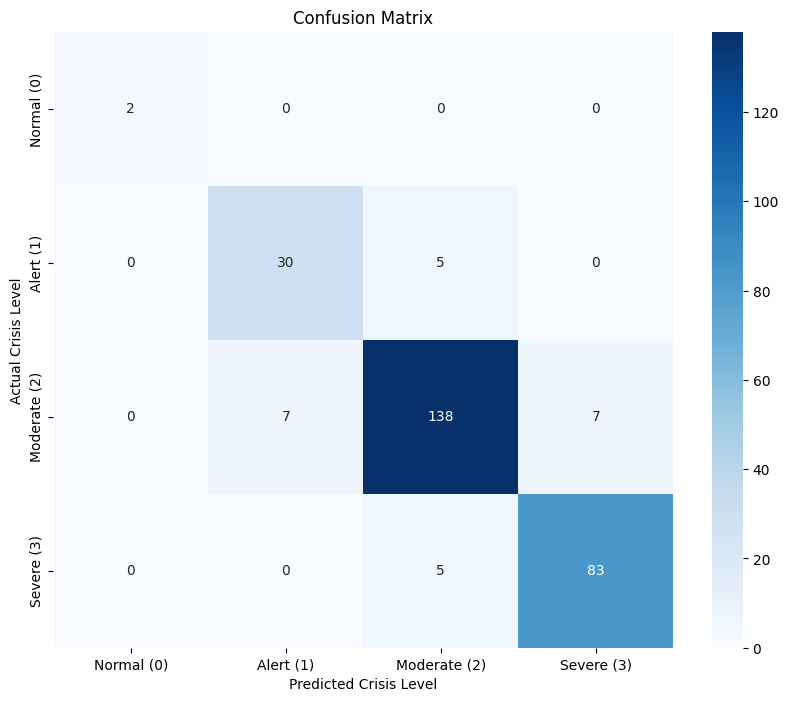


Saving the trained model to 'chennai_water_crisis_lstm_model.h5'...
Model saved successfully.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_lstm_model(input_filename, model_output_filename):
    """
    Loads, preprocesses, builds, trains, and evaluates a time-series
    classification model, including generating a confusion matrix.
    """
    try:
        # --- Steps 1-3: Load, Scale, and Create Sequences (Same as before) ---
        print(f"Loading data from '{input_filename}'...")
        df = pd.read_csv(input_filename)
        df = df.drop(columns=['Date'])

        X = df.drop(columns=['Crisis_Target']).astype('float32')
        y = df['Crisis_Target'].astype('int')

        scaler = MinMaxScaler(feature_range=(0, 1))
        X_scaled = scaler.fit_transform(X)

        y_categorical = to_categorical(y, num_classes=4)

        sequence_length = 60
        X_sequences, y_sequences = [], []
        for i in range(len(X_scaled) - sequence_length):
            X_sequences.append(X_scaled[i:i + sequence_length])
            y_sequences.append(y_categorical[i + sequence_length])

        X_sequences = np.array(X_sequences)
        y_sequences = np.array(y_sequences)

        X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=42)
        print("Data preparation complete.")

        # --- Step 4: Build and Train the LSTM Model (Same as before) ---
        print("\nBuilding and training the LSTM model...")
        model = Sequential([
            LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
            Dropout(0.2),
            LSTM(units=100, return_sequences=True),
            Dropout(0.2),
            LSTM(units=50),
            Dropout(0.2),
            Dense(units=4, activation='softmax')
        ])

        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        model.fit(
            X_train, y_train,
            epochs=50,
            batch_size=32,
            validation_data=(X_test, y_test),
            verbose=1 # Set to 0 to hide epoch logs during training
        )
        print("Model training complete.")

        # --- Step 5: Evaluate the Model (NEW CODE) ---
        print("\n--- Step 5: Evaluating Model Performance ---")

        # a) Make predictions on the test data
        y_pred_probs = model.predict(X_test)

        # b) Convert predicted probabilities to class labels (0, 1, 2, or 3)
        #    np.argmax finds the index of the highest probability.
        y_pred = np.argmax(y_pred_probs, axis=1)

        # c) Convert the one-hot encoded true labels back to class labels
        y_true = np.argmax(y_test, axis=1)

        # d) Calculate and print the accuracy score
        accuracy = accuracy_score(y_true, y_pred)
        print(f"\nModel Accuracy on Test Set: {accuracy * 100:.2f}%")

        # --- Step 6: Generate and Plot the Confusion Matrix (NEW CODE) ---
        print("\n--- Step 6: Generating Confusion Matrix ---")

        # a) Calculate the confusion matrix
        cm = confusion_matrix(y_true, y_pred)

        # b) Plot the confusion matrix as a heatmap for better visualization
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Normal (0)', 'Alert (1)', 'Moderate (2)', 'Severe (3)'],
                    yticklabels=['Normal (0)', 'Alert (1)', 'Moderate (2)', 'Severe (3)'])
        plt.title('Confusion Matrix')
        plt.ylabel('Actual Crisis Level')
        plt.xlabel('Predicted Crisis Level')

        # Save the plot to a file
        plot_filename = 'confusion_matrix.png'
        plt.savefig(plot_filename)
        print(f"Confusion matrix plot saved to '{plot_filename}'")
        plt.show()

        # --- Step 7: Save the Trained Model ---
        print(f"\nSaving the trained model to '{model_output_filename}'...")
        model.save(model_output_filename)
        print("Model saved successfully.")

    except FileNotFoundError:
        print(f"Error: The input file '{input_filename}' was not found.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# --- Main execution ---
if __name__ == '__main__':
    input_file = '/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_lstm_features_dataset.csv'
    output_file = 'chennai_water_crisis_lstm_model.h5'

    evaluate_lstm_model(input_file, output_file)

Loading data from '/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_lstm_features_dataset.csv'...
Data preparation complete.

--- Building the DEEPER LSTM model ---
Deeper model architecture defined.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 60, 128)        │       116,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 60, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 332,964 (1.27 MB)

 Trainable params: 332,964 (1.27 MB)

 Non-trainable params: 0 (0.00 B)


Compiling the model...

Training the model (this may take longer)...
Epoch 1/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.5765 - loss: 1.0065 - val_accuracy: 0.7906 - val_loss: 0.5113
Epoch 2/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7831 - loss: 0.5922 - val_accuracy: 0.8520 - val_loss: 0.4758
Epoch 3/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8403 - loss: 0.4697 - val_accuracy: 0.8700 - val_loss: 0.3718
Epoch 4/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8239 - loss: 0.4741 - val_accuracy: 0.8917 - val_loss: 0.3082
Epoch 5/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8719 - loss: 0.3807 - val_accuracy: 0.8520 - val_loss: 0.3836
Epoch 6/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8561 - loss: 0.3919 - val_accuracy: 0.9025 - val_loss: 0.3071
Epoch 7/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9045 - loss: 0.2888 - val_accuracy: 0.8773 - val_loss: 0.3157
Epoch 8/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 


Model Accuracy on Test Set: 91.34%
Confusion matrix plot for deeper model saved to 'confusion_matrix_deep_model.png'

Deeper model saved successfully to 'chennai_water_crisis_lstm_model_deep.h5'


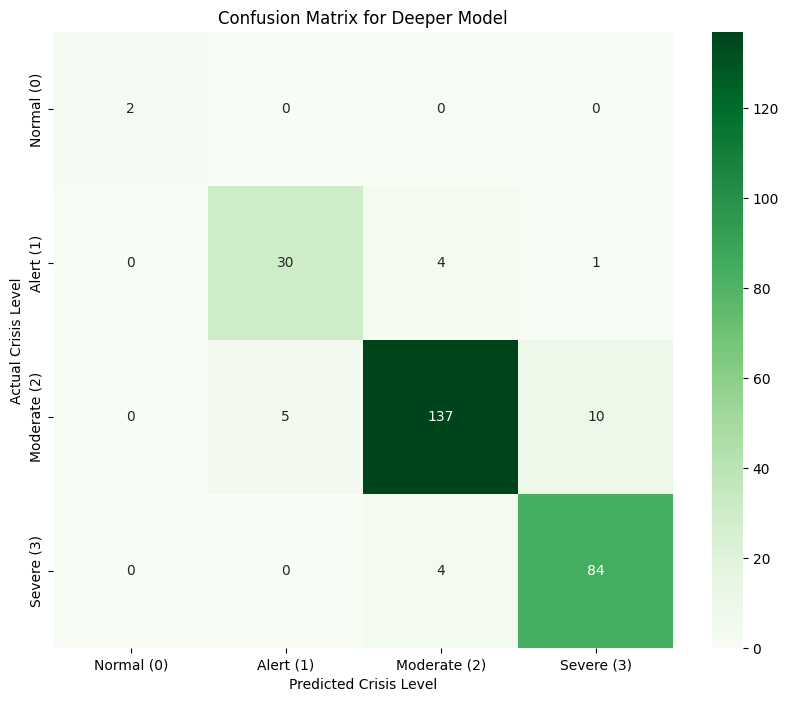

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns

def build_and_train_deep_lstm(input_filename, model_output_filename):
    """
    Builds, trains, and evaluates a DEEPER LSTM model with more layers.
    """
    try:
        # --- Data Loading and Preparation (Same as before) ---
        print(f"Loading data from '{input_filename}'...")
        df = pd.read_csv(input_filename)
        df = df.drop(columns=['Date'])

        X = df.drop(columns=['Crisis_Target']).astype('float32')
        y = df['Crisis_Target'].astype('int')

        scaler = MinMaxScaler(feature_range=(0, 1))
        X_scaled = scaler.fit_transform(X)

        y_categorical = to_categorical(y, num_classes=4)

        sequence_length = 60
        X_sequences, y_sequences = [], []
        for i in range(len(X_scaled) - sequence_length):
            X_sequences.append(X_scaled[i:i + sequence_length])
            y_sequences.append(y_categorical[i + sequence_length])

        X_sequences = np.array(X_sequences)
        y_sequences = np.array(y_sequences)

        X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=42)
        print("Data preparation complete.")

        # --- Build the DEEPER LSTM Model Architecture ---
        print("\n--- Building the DEEPER LSTM model ---")

        model = Sequential()

        # Layer 1: Input LSTM layer
        model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dropout(0.2))

        # Layer 2: Second LSTM layer
        model.add(LSTM(units=128, return_sequences=True))
        model.add(Dropout(0.2))

        # Layer 3 (NEW): Third LSTM layer
        model.add(LSTM(units=64, return_sequences=True))
        model.add(Dropout(0.2))

        # Layer 4: Final LSTM layer
        model.add(LSTM(units=64))
        model.add(Dropout(0.2))

        # Layer 5 (NEW): A standard Dense layer for feature processing
        model.add(Dense(units=32, activation='relu'))

        # Layer 6: Final Output Layer
        model.add(Dense(units=4, activation='softmax'))

        print("Deeper model architecture defined.")
        model.summary()

        # --- Compile the Model ---
        print("\nCompiling the model...")
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        # --- Train the Model ---
        print("\nTraining the model (this may take longer)...")
        history = model.fit(
            X_train, y_train,
            epochs=60,  # Increased epochs slightly for the deeper model
            batch_size=32,
            validation_data=(X_test, y_test),
            verbose=1
        )

        # --- Evaluate the Model ---
        print("\n--- Evaluating Model Performance ---")
        y_pred_probs = model.predict(X_test)
        y_pred = np.argmax(y_pred_probs, axis=1)
        y_true = np.argmax(y_test, axis=1)

        accuracy = accuracy_score(y_true, y_pred)
        print(f"\nModel Accuracy on Test Set: {accuracy * 100:.2f}%")

        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                    xticklabels=['Normal (0)', 'Alert (1)', 'Moderate (2)', 'Severe (3)'],
                    yticklabels=['Normal (0)', 'Alert (1)', 'Moderate (2)', 'Severe (3)'])
        plt.title('Confusion Matrix for Deeper Model')
        plt.ylabel('Actual Crisis Level')
        plt.xlabel('Predicted Crisis Level')
        plt.savefig('confusion_matrix_deep_model.png')
        print("Confusion matrix plot for deeper model saved to 'confusion_matrix_deep_model.png'")

        # --- Save the Model ---
        model.save(model_output_filename)
        print(f"\nDeeper model saved successfully to '{model_output_filename}'")

    except FileNotFoundError:
        print(f"Error: The input file '{input_filename}' was not found.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# --- Main execution ---
if __name__ == '__main__':
    input_file = '/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_lstm_features_dataset.csv'
    output_file = '/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_water_crisis_lstm_model_deep.h5'

    build_and_train_deep_lstm(input_file, output_file)

Loading data from '/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_lstm_features_dataset.csv'...
Data preparation complete.

--- Building the COMPLEX Conv-BiLSTM model ---
Complex model architecture defined.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 56, 64)         │        31,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 28, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 28, 256)        │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 28, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 640,324 (2.44 MB)

 Trainable params: 640,324 (2.44 MB)

 Non-trainable params: 0 (0.00 B)


Compiling and training the complex model...
Epoch 1/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.5807 - loss: 1.0135 - val_accuracy: 0.7906 - val_loss: 0.5365
Epoch 2/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8210 - loss: 0.4693 - val_accuracy: 0.8231 - val_loss: 0.4052
Epoch 3/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8396 - loss: 0.4541 - val_accuracy: 0.8881 - val_loss: 0.3540
Epoch 4/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8543 - loss: 0.3749 - val_accuracy: 0.8845 - val_loss: 0.3224
Epoch 5/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8587 - loss: 0.3725 - val_accuracy: 0.8809 - val_loss: 0.3150
Epoch 6/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8912 - loss: 0.3002 - val_accuracy: 0.8700 - val_loss: 0.3304
Epoch 7/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9085 - loss: 0.2690 - val_accuracy: 0.8628 - val_loss: 0.3353
Epoch 8/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8

Confusion matrix plot for complex model saved to 'confusion_matrix_complex_model.png'

Complex model saved successfully to '/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_water_crisis_lstm_model_complex.h5'


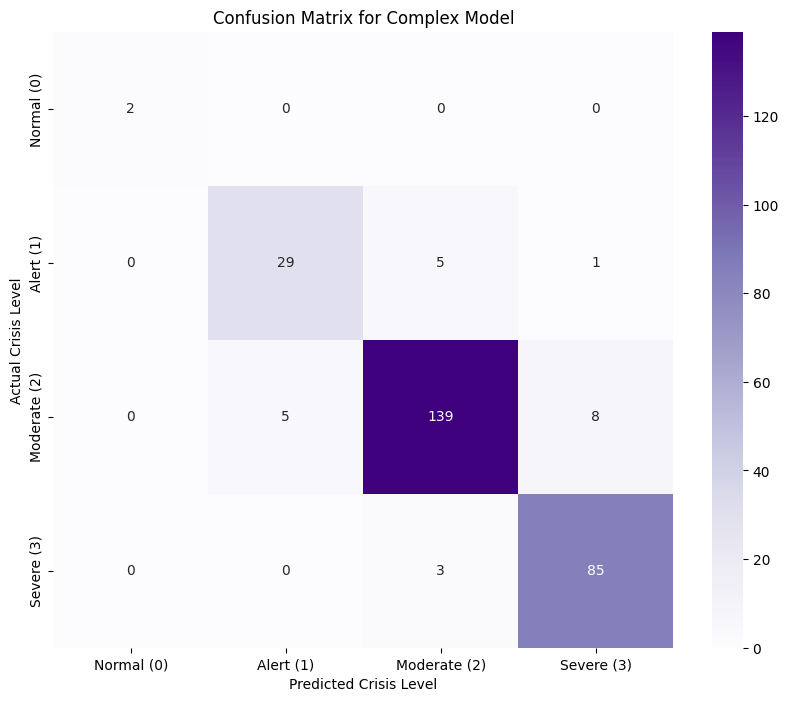

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Bidirectional
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns

def build_and_train_complex_lstm(input_filename, model_output_filename):
    """
    Builds, trains, and evaluates a COMPLEX "Conv-BiLSTM" model.
    """
    try:
        # --- Data Loading and Preparation (Same as before) ---
        print(f"Loading data from '{input_filename}'...")
        df = pd.read_csv(input_filename)
        df = df.drop(columns=['Date'])

        X = df.drop(columns=['Crisis_Target']).astype('float32')
        y = df['Crisis_Target'].astype('int')

        scaler = MinMaxScaler(feature_range=(0, 1))
        X_scaled = scaler.fit_transform(X)

        y_categorical = to_categorical(y, num_classes=4)

        sequence_length = 60
        X_sequences, y_sequences = [], []
        for i in range(len(X_scaled) - sequence_length):
            X_sequences.append(X_scaled[i:i + sequence_length])
            y_sequences.append(y_categorical[i + sequence_length])

        X_sequences = np.array(X_sequences)
        y_sequences = np.array(y_sequences)

        X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=42)
        print("Data preparation complete.")

        # --- Build the COMPLEX Conv-BiLSTM Model Architecture ---
        print("\n--- Building the COMPLEX Conv-BiLSTM model ---")

        model = Sequential()

        # Layer 1 (NEW): 1D Convolutional Layer for pattern detection
        # - filters=64: It will learn 64 different patterns.
        # - kernel_size=5: It looks at a window of 5 days at a time.
        # - activation='relu': A standard activation function.
        model.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))

        # Layer 2 (NEW): Max Pooling to reduce dimensionality
        model.add(MaxPooling1D(pool_size=2))

        # Layer 3 (NEW): Bidirectional LSTM layer
        # The Bidirectional wrapper duplicates the LSTM layer, having one process
        # the sequence forwards and the other backwards.
        model.add(Bidirectional(LSTM(units=128, return_sequences=True)))
        model.add(Dropout(0.3))

        # Layer 4: Another Bidirectional LSTM layer
        model.add(Bidirectional(LSTM(units=128)))
        model.add(Dropout(0.3))

        # Layer 5: A standard Dense layer for processing before output
        model.add(Dense(units=64, activation='relu'))
        model.add(Dropout(0.2))

        # Layer 6: Final Output Layer
        model.add(Dense(units=4, activation='softmax'))

        print("Complex model architecture defined.")
        model.summary()

        # --- Compile and Train ---
        print("\nCompiling and training the complex model...")
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        history = model.fit(
            X_train, y_train,
            epochs=60,
            batch_size=32,
            validation_data=(X_test, y_test),
            verbose=1
        )

        # --- Evaluate the Model ---
        print("\n--- Evaluating Model Performance ---")
        y_pred_probs = model.predict(X_test)
        y_pred = np.argmax(y_pred_probs, axis=1)
        y_true = np.argmax(y_test, axis=1)

        accuracy = accuracy_score(y_true, y_pred)
        print(f"\nModel Accuracy on Test Set: {accuracy * 100:.2f}%")

        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
                    xticklabels=['Normal (0)', 'Alert (1)', 'Moderate (2)', 'Severe (3)'],
                    yticklabels=['Normal (0)', 'Alert (1)', 'Moderate (2)', 'Severe (3)'])
        plt.title('Confusion Matrix for Complex Model')
        plt.ylabel('Actual Crisis Level')
        plt.xlabel('Predicted Crisis Level')
        plt.savefig('confusion_matrix_complex_model.png')
        print("Confusion matrix plot for complex model saved to 'confusion_matrix_complex_model.png'")

        # --- Save the Model ---
        model.save(model_output_filename)
        print(f"\nComplex model saved successfully to '{model_output_filename}'")

    except FileNotFoundError:
        print(f"Error: The input file '{input_filename}' was not found.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# --- Main execution ---
if __name__ == '__main__':
    input_file = '/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_lstm_features_dataset.csv'
    output_file = '/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_water_crisis_lstm_model_complex.h5'

    build_and_train_complex_lstm(input_file, output_file)

Loading data from '/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_lstm_features_dataset.csv'...

Preparing data for LSTM...

--- Training Model 1: Conv-BiLSTM ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


LSTM model trained.

--- Training Model 2: XGBoost ---


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:32:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost model trained.

--- Evaluating Hybrid Model Performance ---
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step

Hybrid Model Accuracy on Test Set: 98.92%
Confusion matrix plot for hybrid model saved to 'confusion_matrix_hybrid_model.png'


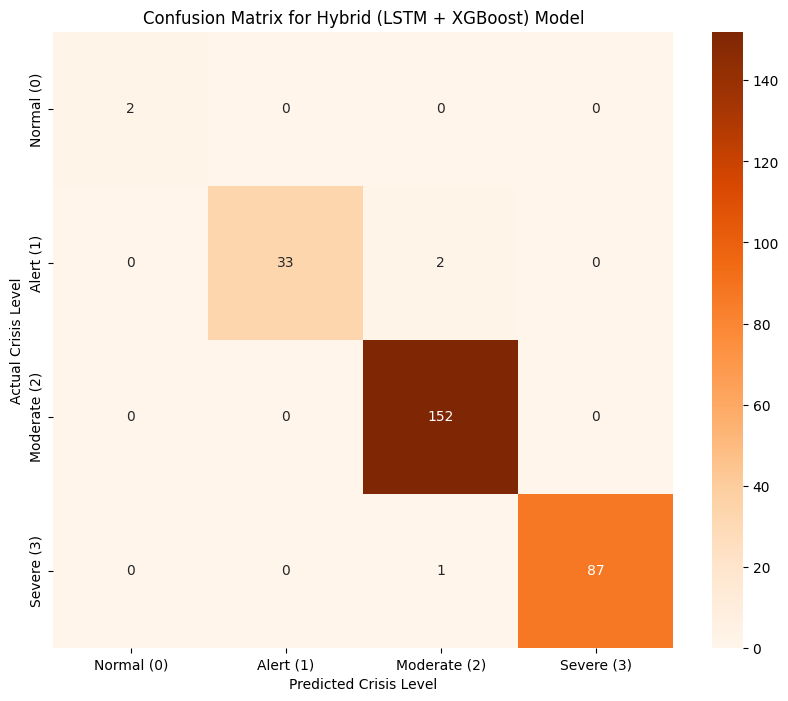

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Bidirectional
from tensorflow.keras.utils import to_categorical
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

def build_and_evaluate_hybrid_model(input_filename):
    """
    Builds, trains, and evaluates a hybrid model combining a Conv-BiLSTM
    and an XGBoost classifier.
    """
    try:
        # --- Data Loading ---
        print(f"Loading data from '{input_filename}'...")
        df = pd.read_csv(input_filename)
        df = df.drop(columns=['Date'])

        X = df.drop(columns=['Crisis_Target']).astype('float32')
        y = df['Crisis_Target'].astype('int')

        # --- Data Prep for LSTM ---
        print("\nPreparing data for LSTM...")
        scaler = MinMaxScaler(feature_range=(0, 1))
        X_scaled = scaler.fit_transform(X)
        y_categorical = to_categorical(y, num_classes=4)

        sequence_length = 60
        X_sequences, y_sequences = [], []
        # Also keep track of original y for XGBoost
        y_for_xgb = []
        for i in range(len(X_scaled) - sequence_length):
            X_sequences.append(X_scaled[i:i + sequence_length])
            y_sequences.append(y_categorical[i + sequence_length])
            y_for_xgb.append(y.iloc[i + sequence_length])

        X_sequences = np.array(X_sequences)
        y_sequences = np.array(y_sequences)
        y_for_xgb = np.array(y_for_xgb)

        # Split data for both models
        X_train_seq, X_test_seq, y_train_cat, y_test_cat = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=42)
        # For XGBoost, we need the original (non-sequenced, non-scaled) data
        X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X.iloc[sequence_length:], y_for_xgb, test_size=0.2, random_state=42)

        # --- 1. Train the LSTM Model ---
        print("\n--- Training Model 1: Conv-BiLSTM ---")
        lstm_model = Sequential([
            Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
            MaxPooling1D(pool_size=2),
            Bidirectional(LSTM(units=128, return_sequences=True)),
            Dropout(0.3),
            Bidirectional(LSTM(units=128)),
            Dropout(0.3),
            Dense(units=64, activation='relu'),
            Dropout(0.2),
            Dense(units=4, activation='softmax')
        ])
        lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        lstm_model.fit(X_train_seq, y_train_cat, epochs=60, batch_size=32, validation_data=(X_test_seq, y_test_cat), verbose=0)
        print("LSTM model trained.")

        # --- 2. Train the XGBoost Model ---
        print("\n--- Training Model 2: XGBoost ---")
        xgb_model = xgb.XGBClassifier(objective='multi:softprob', num_class=4, use_label_encoder=False, eval_metric='mlogloss')
        xgb_model.fit(X_train_xgb, y_train_xgb)
        print("XGBoost model trained.")

        # --- 3. Evaluate the Hybrid Model ---
        print("\n--- Evaluating Hybrid Model Performance ---")

        # Get prediction probabilities from both models
        lstm_pred_probs = lstm_model.predict(X_test_seq)
        xgb_pred_probs = xgb_model.predict_proba(X_test_xgb)

        # Combine predictions by averaging probabilities
        hybrid_pred_probs = (lstm_pred_probs + xgb_pred_probs) / 2.0

        # Convert final probabilities to class labels
        hybrid_pred = np.argmax(hybrid_pred_probs, axis=1)

        # The true labels are the non-categorical ones from the XGBoost split
        y_true = y_test_xgb

        # Calculate final accuracy and confusion matrix
        accuracy = accuracy_score(y_true, hybrid_pred)
        print(f"\nHybrid Model Accuracy on Test Set: {accuracy * 100:.2f}%")

        cm = confusion_matrix(y_true, hybrid_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
                    xticklabels=['Normal (0)', 'Alert (1)', 'Moderate (2)', 'Severe (3)'],
                    yticklabels=['Normal (0)', 'Alert (1)', 'Moderate (2)', 'Severe (3)'])
        plt.title('Confusion Matrix for Hybrid (LSTM + XGBoost) Model')
        plt.ylabel('Actual Crisis Level')
        plt.xlabel('Predicted Crisis Level')
        plt.savefig('confusion_matrix_hybrid_model.png')
        print("Confusion matrix plot for hybrid model saved to 'confusion_matrix_hybrid_model.png'")

    except FileNotFoundError:
        print(f"Error: The input file '{input_filename}' was not found.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# --- Main execution ---
if __name__ == '__main__':
    input_file = '/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_lstm_features_dataset.csv'
    build_and_evaluate_hybrid_model(input_file)

Loading data from '/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_lstm_features_dataset.csv'...
Data preparation complete.

--- Building the CNN-GRU Hybrid Model ---
CNN-GRU Hybrid model architecture defined.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 58, 64)         │        19,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 56, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 28, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 28, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 28, 100)        │        49,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 28, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 100)            │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │           404 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 142,228 (555.58 KB)

 Trainable params: 142,228 (555.58 KB)

 Non-trainable params: 0 (0.00 B)


Compiling and training the model...
Epoch 1/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5424 - loss: 0.9549 - val_accuracy: 0.8339 - val_loss: 0.4254
Epoch 2/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8260 - loss: 0.4453 - val_accuracy: 0.8628 - val_loss: 0.3843
Epoch 3/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8593 - loss: 0.3833 - val_accuracy: 0.8773 - val_loss: 0.3291
Epoch 4/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8699 - loss: 0.3519 - val_accuracy: 0.8592 - val_loss: 0.4374
Epoch 5/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8607 - loss: 0.3803 - val_accuracy: 0.8809 - val_loss: 0.3635
Epoch 6/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8798 - loss: 0.3313 - val_accuracy: 0.8736 - val_loss: 0.3597
Epoch 7/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8801 - loss: 0.3529 - val_accuracy: 0.8953 - val_loss: 0.3008
Epoch 8/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9001 - lo


CNN-GRU Hybrid Model Accuracy on Test Set: 92.06%
Confusion matrix plot for the hybrid model saved to 'confusion_matrix_cnn_gru_hybrid.png'

CNN-GRU Hybrid model saved successfully to '/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_water_crisis_cnn_gru_hybrid_model.h5'


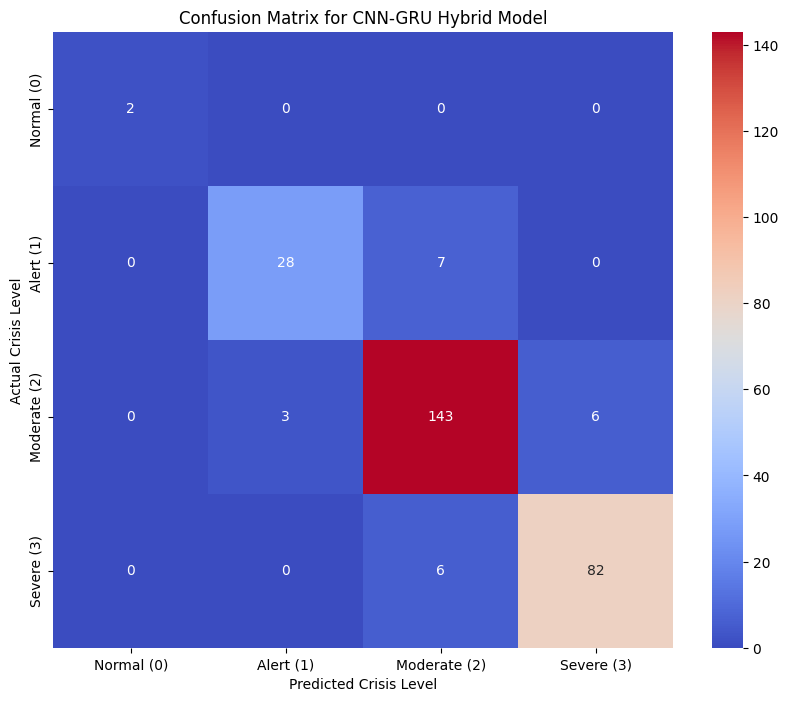

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GRU, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns

def build_and_train_cnn_gru_hybrid(input_filename, model_output_filename):
    """
    Builds, trains, and evaluates a hybrid model combining a CNN front-end
    with a GRU back-end for time-series classification.
    """
    try:
        # --- Data Loading and Preparation (Same as before) ---
        print(f"Loading data from '{input_filename}'...")
        df = pd.read_csv(input_filename)
        df = df.drop(columns=['Date'])

        X = df.drop(columns=['Crisis_Target']).astype('float32')
        y = df['Crisis_Target'].astype('int')

        scaler = MinMaxScaler(feature_range=(0, 1))
        X_scaled = scaler.fit_transform(X)

        y_categorical = to_categorical(y, num_classes=4)

        sequence_length = 60
        X_sequences, y_sequences = [], []
        for i in range(len(X_scaled) - sequence_length):
            X_sequences.append(X_scaled[i:i + sequence_length])
            y_sequences.append(y_categorical[i + sequence_length])

        X_sequences = np.array(X_sequences)
        y_sequences = np.array(y_sequences)

        X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=42)
        print("Data preparation complete.")

        # --- Build the CNN + GRU Hybrid Model Architecture ---
        print("\n--- Building the CNN-GRU Hybrid Model ---")

        model = Sequential()

        # Part 1: The CNN Front-End
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Dropout(0.3))

        # Part 2: The GRU Back-End
        model.add(GRU(units=100, return_sequences=True))
        model.add(Dropout(0.2))

        model.add(GRU(units=100))
        model.add(Dropout(0.2))

        # Part 3: The Output Layer
        model.add(Dense(units=4, activation='softmax'))

        print("CNN-GRU Hybrid model architecture defined.")
        model.summary()

        # --- Compile and Train the Model ---
        print("\nCompiling and training the model...")
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        history = model.fit(
            X_train, y_train,
            epochs=60,
            batch_size=32,
            validation_data=(X_test, y_test),
            verbose=1
        )

        # --- Evaluate the Model ---
        print("\n--- Evaluating Model Performance ---")
        y_pred_probs = model.predict(X_test)
        y_pred = np.argmax(y_pred_probs, axis=1)
        y_true = np.argmax(y_test, axis=1)

        accuracy = accuracy_score(y_true, y_pred)
        print(f"\nCNN-GRU Hybrid Model Accuracy on Test Set: {accuracy * 100:.2f}%")

        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm',
                    xticklabels=['Normal (0)', 'Alert (1)', 'Moderate (2)', 'Severe (3)'],
                    yticklabels=['Normal (0)', 'Alert (1)', 'Moderate (2)', 'Severe (3)'])
        plt.title('Confusion Matrix for CNN-GRU Hybrid Model')
        plt.ylabel('Actual Crisis Level')
        plt.xlabel('Predicted Crisis Level')
        plt.savefig('confusion_matrix_cnn_gru_hybrid.png')
        print("Confusion matrix plot for the hybrid model saved to 'confusion_matrix_cnn_gru_hybrid.png'")

        # --- Save the Model ---
        model.save(model_output_filename)
        print(f"\nCNN-GRU Hybrid model saved successfully to '{model_output_filename}'")

    except FileNotFoundError:
        print(f"Error: The input file '{input_filename}' was not found.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# --- Main execution ---
if __name__ == '__main__':
    input_file = '/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_lstm_features_dataset.csv'
    output_file = '/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_water_crisis_cnn_gru_hybrid_model.h5'

    build_and_train_cnn_gru_hybrid(input_file, output_file)

### M

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from datetime import datetime, timedelta

def build_long_range_prediction_system(input_filename, model_output_filename):
    """
    Builds a complete system for long-range (1-year) water crisis forecasting
    with prediction explanation, using an XGBoost model.
    """
    try:
        # --- Step 1: Load and Prepare Clean Data ---
        print("Step 1: Loading and preparing clean data...")
        df = pd.read_csv(input_filename)
        df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
        df = df[df['Date'] >= '2015-01-01'].copy()
        df.set_index('Date', inplace=True)

        # Impute any remaining missing values robustly
        df.interpolate(method='linear', limit_direction='both', inplace=True)
        print("Data loaded and cleaned.")

        # --- Step 2: Engineer Long-Range Features ---
        print("Step 2: Engineering long-range features...")

        # Long-term lags
        for lag in [90, 180, 365]:
            df[f'Storage_mcft_TOTAL_lag_{lag}'] = df['Storage_mcft_TOTAL'].shift(lag)
            df[f'daily_average_water_level_lag_{lag}'] = df['daily_average_water_level'].shift(lag)

        # Long-term rolling features
        df['rainfall_roll_sum_365'] = df['Rainfall_mm_TOTAL'].rolling(window=365).sum()
        df['temp_roll_mean_180'] = df['temperature_mean_celsius'].rolling(window=180).mean()

        # Date-based features are critical for long-range forecasts
        df['month'] = df.index.month
        df['day_of_year'] = df.index.dayofyear

        # --- Step 3: Create 1-Year Forward-Looking Target ---
        print("Step 3: Creating 1-year forward-looking target variable...")

        # Calculate Water Security Index (WSI)
        weights = {'storage': 0.4, 'groundwater': 0.3, 'rainfall': 0.15, 'consumption': 0.15}
        df['norm_storage'] = (df['Storage_mcft_TOTAL'] - df['Storage_mcft_TOTAL'].min()) / (df['Storage_mcft_TOTAL'].max() - df['Storage_mcft_TOTAL'].min())
        df['norm_groundwater'] = (df['daily_average_water_level'] - df['daily_average_water_level'].min()) / (df['daily_average_water_level'].max() - df['daily_average_water_level'].min())
        df['norm_rainfall'] = (df['Rainfall_mm_TOTAL'].rolling(window=30).sum() - df['Rainfall_mm_TOTAL'].rolling(window=30).sum().min()) / (df['Rainfall_mm_TOTAL'].rolling(window=30).sum().max() - df['Rainfall_mm_TOTAL'].rolling(window=30).sum().min())
        df['norm_consumption'] = 1 - ((df['Total_Consumption_MLD'] - df['Total_Consumption_MLD'].min()) / (df['Total_Consumption_MLD'].max() - df['Total_Consumption_MLD'].min()))
        df['Water_Security_Index'] = (df['norm_storage']*weights['storage'] + df['norm_groundwater']*weights['groundwater'] + df['norm_rainfall']*weights['rainfall'] + df['norm_consumption']*weights['consumption'])

        # Shift the WSI back by 365 days to create the future target
        df['Future_WSI_365'] = df['Water_Security_Index'].shift(-365)

        def define_crisis_level(score):
            if score < 0.35: return 3
            elif score < 0.55: return 2
            elif score < 0.70: return 1
            else: return 0

        df['Crisis_Target_Future_365'] = df['Future_WSI_365'].apply(define_crisis_level)

        # --- Step 4: Prepare Data for XGBoost ---
        print("Step 4: Finalizing data for model training...")

        # Drop helper columns and rows with NaNs (from lags and future shift)
        df_model = df.drop(columns=['Water_Security_Index', 'Future_WSI_365', 'norm_storage', 'norm_groundwater', 'norm_rainfall', 'norm_consumption'])
        df_model.dropna(inplace=True)

        X = df_model.drop(columns=['Crisis_Target_Future_365'])
        y = df_model['Crisis_Target_Future_365']

        # Split data chronologically for time-series validation
        split_index = int(len(X) * 0.8)
        X_train, X_test = X[:split_index], X[split_index:]
        y_train, y_test = y[:split_index], y[split_index:]

        # --- Step 5: Train the XGBoost Model ---
        print("Step 5: Training XGBoost model...")
        model = xgb.XGBClassifier(objective='multi:softprob', num_class=4, use_label_encoder=False, eval_metric='mlogloss', n_estimators=200, learning_rate=0.1, max_depth=5)
        model.fit(X_train, y_train, verbose=False)

        # --- Step 6: Evaluate Model ---
        print("\n--- Model Evaluation ---")
        y_pred = model.predict(X_test)
        print(f"Accuracy for 1-year forecast: {accuracy_score(y_test, y_pred) * 100:.2f}%")
        print("Classification Report:")
        print(classification_report(y_test, y_pred))

        # --- Step 7: Save the Model and Feature Names ---
        model.save_model(model_output_filename)
        pd.Series(X.columns).to_csv('features.csv', index=False, header=False)
        print(f"Model and feature list saved.")

    except FileNotFoundError:
        print(f"Error: The file '{input_filename}' was not found.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

def get_prediction_and_cause(future_date_str, model_filename='long_range_model.json', features_filename='features.csv', historical_data_filename='/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_lstm_features_dataset.csv'):
    """
    Makes a prediction for a single future date and explains the cause.
    """
    print(f"\n--- Generating prediction for {future_date_str} ---")

    # Load the trained model and historical data
    model = xgb.XGBClassifier()
    model.load_model(model_filename)
    features = pd.read_csv(features_filename, header=None)[0].tolist()
    df = pd.read_csv(historical_data_filename, parse_dates=['Date'])

    # Get the most recent data point from history
    last_known_data = df.sort_values(by='Date').iloc[-1]

    # Create a placeholder for the future date's features
    future_data = pd.Series(index=features)
    future_date = pd.to_datetime(future_date_str)

    # Populate date-based features for the future date
    future_data['month'] = future_date.month
    future_data['day_of_year'] = future_date.dayofyear

    # Populate other features using the last known data (this is a simplification)
    # A real-world system would use forecasts for weather, etc.
    for col in features:
        if col not in ['month', 'day_of_year']:
            # Find the corresponding column in historical data, even if it has a lag suffix
            base_col = col.split('_lag_')[0] if '_lag_' in col else col.split('_roll_')[0]
            if base_col in last_known_data:
                future_data[col] = last_known_data[base_col]

    # Make the prediction
    prediction = model.predict(pd.DataFrame(future_data).transpose())[0]
    crisis_levels = ['Normal (0)', 'Alert (1)', 'Moderate Crisis (2)', 'Severe Crisis (3)']
    print(f"Predicted Crisis Level: {crisis_levels[prediction]}")

    # Explain the cause
    feature_importance = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)

    print("\nPrimary causes for this prediction:")
    for feature, importance in feature_importance.head(5).items():
        # Translate feature name to a more readable cause
        cause = feature.replace('_', ' ').title()
        if 'lag' in feature:
            cause = f"Conditions from {feature.split('_')[-1]} days ago ({cause})"
        print(f" - {cause} (Importance: {importance:.2f})")

# --- Main execution ---
if __name__ == '__main__':
    input_file = '/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_lstm_features_dataset.csv'
    output_file = 'long_range_model.json'

    # First, train the model
    build_long_range_prediction_system(input_file, output_file)

    # Now, use the trained model to make a prediction for a future date
    # (Example: predict for 6 months from today)
    future_date_to_predict = (datetime.now() + timedelta(days=180)).strftime('%Y-%m-%d')
    get_prediction_and_cause(future_date_to_predict)

Step 1: Loading and preparing clean data...
Data loaded and cleaned.
Step 2: Engineering long-range features...
Step 3: Creating 1-year forward-looking target variable...
Step 4: Finalizing data with a STRATIFIED train-test split...
Step 5: Training XGBoost model...


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [13:23:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Model Evaluation ---
Accuracy for 1-year forecast: 97.69%
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        88
           1       0.97      0.93      0.95        42
           2       0.96      0.99      0.98        80
           3       1.00      0.83      0.91         6

    accuracy                           0.98       216
   macro avg       0.98      0.94      0.96       216
weighted avg       0.98      0.98      0.98       216

Model and feature list saved.

--- Generating prediction for 2026-02-04 ---
Predicted Crisis Level: Normal (0)

Primary causes for this prediction:
 - Conditions from 180 days ago (Storage Mcft Total Lag 180) (Importance: 0.11)
 - Per Capita Consumption Lpcd (Importance: 0.09)
 - Storage As On Same Day Last Year Mcft Total (Importance: 0.07)
 - Temperature Mean Celsius Roll Mean 7 (Importance: 0.05)
 - Enso Index (Importance: 0.04)


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from datetime import datetime, timedelta

def build_long_range_prediction_system(input_filename, model_output_filename):
    """
    Builds a complete system for long-range (1-year) water crisis forecasting
    with prediction explanation, using an XGBoost model.
    """
    try:
        # --- Step 1: Load and Prepare Clean Data ---
        print("Step 1: Loading and preparing clean data...")
        df = pd.read_csv(input_filename)
        df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
        df = df[df['Date'] >= '2015-01-01'].copy()
        df.set_index('Date', inplace=True)

        # Impute any remaining missing values robustly
        df.interpolate(method='linear', limit_direction='both', inplace=True)
        print("Data loaded and cleaned.")

        # --- Step 2: Engineer Long-Range Features ---
        print("Step 2: Engineering long-range features...")

        # Long-term lags
        for lag in [90, 180, 365]:
            df[f'Storage_mcft_TOTAL_lag_{lag}'] = df['Storage_mcft_TOTAL'].shift(lag)
            df[f'daily_average_water_level_lag_{lag}'] = df['daily_average_water_level'].shift(lag)

        # Long-term rolling features
        df['rainfall_roll_sum_365'] = df['Rainfall_mm_TOTAL'].rolling(window=365).sum()
        df['temp_roll_mean_180'] = df['temperature_mean_celsius'].rolling(window=180).mean()

        # Date-based features are critical for long-range forecasts
        df['month'] = df.index.month
        df['day_of_year'] = df.index.dayofyear

        # --- Step 3: Create 1-Year Forward-Looking Target ---
        print("Step 3: Creating 1-year forward-looking target variable...")

        # Calculate Water Security Index (WSI)
        weights = {'storage': 0.4, 'groundwater': 0.3, 'rainfall': 0.15, 'consumption': 0.15}
        df['norm_storage'] = (df['Storage_mcft_TOTAL'] - df['Storage_mcft_TOTAL'].min()) / (df['Storage_mcft_TOTAL'].max() - df['Storage_mcft_TOTAL'].min())
        df['norm_groundwater'] = (df['daily_average_water_level'] - df['daily_average_water_level'].min()) / (df['daily_average_water_level'].max() - df['daily_average_water_level'].min())
        df['norm_rainfall'] = (df['Rainfall_mm_TOTAL'].rolling(window=30).sum() - df['Rainfall_mm_TOTAL'].rolling(window=30).sum().min()) / (df['Rainfall_mm_TOTAL'].rolling(window=30).sum().max() - df['Rainfall_mm_TOTAL'].rolling(window=30).sum().min())
        df['norm_consumption'] = 1 - ((df['Total_Consumption_MLD'] - df['Total_Consumption_MLD'].min()) / (df['Total_Consumption_MLD'].max() - df['Total_Consumption_MLD'].min()))
        df['Water_Security_Index'] = (df['norm_storage']*weights['storage'] + df['norm_groundwater']*weights['groundwater'] + df['norm_rainfall']*weights['rainfall'] + df['norm_consumption']*weights['consumption'])

        # Shift the WSI back by 365 days to create the future target
        df['Future_WSI_365'] = df['Water_Security_Index'].shift(-365)

        def define_crisis_level(score):
            if score < 0.35: return 3
            elif score < 0.55: return 2
            elif score < 0.70: return 1
            else: return 0

        df['Crisis_Target_Future_365'] = df['Future_WSI_365'].apply(define_crisis_level)

        # --- Step 4: Prepare Data for XGBoost ---
        # --- Step 4: Prepare Data with STRATIFIED Split ---
        print("Step 4: Finalizing data with a STRATIFIED train-test split...")

        df_model = df.drop(columns=['Water_Security_Index', 'Future_WSI_365', 'norm_storage', 'norm_groundwater', 'norm_rainfall', 'norm_consumption'])
        df_model.dropna(inplace=True)

        X = df_model.drop(columns=['Crisis_Target_Future_365'])
        y = df_model['Crisis_Target_Future_365']

        # --- THIS IS THE KEY CHANGE ---
        # We now use train_test_split with the `stratify` parameter.
        # This ensures both train and test sets have a representative sample of all crisis levels.
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        # --- Step 5: Train the XGBoost Model ---
        print("Step 5: Training XGBoost model...")
        model = xgb.XGBClassifier(objective='multi:softprob', num_class=4, use_label_encoder=False, eval_metric='mlogloss', n_estimators=200, learning_rate=0.1, max_depth=5)
        model.fit(X_train, y_train, verbose=False)

        # --- Step 6: Evaluate Model ---
        print("\n--- Model Evaluation ---")
        y_pred = model.predict(X_test)
        print(f"Accuracy for 1-year forecast: {accuracy_score(y_test, y_pred) * 100:.2f}%")
        print("Classification Report:")
        print(classification_report(y_test, y_pred))

        # --- Step 7: Save the Model and Feature Names ---
        model.save_model(model_output_filename)
        pd.Series(X.columns).to_csv('features.csv', index=False, header=False)
        print(f"Model and feature list saved.")

    except FileNotFoundError:
        print(f"Error: The file '{input_filename}' was not found.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

def get_prediction_and_cause(future_date_str, model_filename='long_range_model.json', features_filename='features.csv', historical_data_filename='/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_lstm_features_dataset.csv'):
    """
    Makes a prediction for a single future date and explains the cause.
    """
    print(f"\n--- Generating prediction for {future_date_str} ---")

    # Load the trained model and historical data
    model = xgb.XGBClassifier()
    model.load_model(model_filename)
    features = pd.read_csv(features_filename, header=None)[0].tolist()
    df = pd.read_csv(historical_data_filename, parse_dates=['Date'])

    # Get the most recent data point from history
    last_known_data = df.sort_values(by='Date').iloc[-1]

    # Create a placeholder for the future date's features
    future_data = pd.Series(index=features)
    future_date = pd.to_datetime(future_date_str)

    # Populate date-based features for the future date
    future_data['month'] = future_date.month
    future_data['day_of_year'] = future_date.dayofyear

    # Populate other features using the last known data (this is a simplification)
    # A real-world system would use forecasts for weather, etc.
    for col in features:
        if col not in ['month', 'day_of_year']:
            # Find the corresponding column in historical data, even if it has a lag suffix
            base_col = col.split('_lag_')[0] if '_lag_' in col else col.split('_roll_')[0]
            if base_col in last_known_data:
                future_data[col] = last_known_data[base_col]

    # Make the prediction
    prediction = model.predict(pd.DataFrame(future_data).transpose())[0]
    crisis_levels = ['Normal (0)', 'Alert (1)', 'Moderate Crisis (2)', 'Severe Crisis (3)']
    print(f"Predicted Crisis Level: {crisis_levels[prediction]}")

    # Explain the cause
    feature_importance = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)

    print("\nPrimary causes for this prediction:")
    for feature, importance in feature_importance.head(5).items():
        # Translate feature name to a more readable cause
        cause = feature.replace('_', ' ').title()
        if 'lag' in feature:
            cause = f"Conditions from {feature.split('_')[-1]} days ago ({cause})"
        print(f" - {cause} (Importance: {importance:.2f})")

# --- Main execution ---
if __name__ == '__main__':
    input_file = '/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_lstm_features_dataset.csv'
    output_file = 'long_range_model.json'

    # First, train the model
    build_long_range_prediction_system(input_file, output_file)

    # Now, use the trained model to make a prediction for a future date
    # (Example: predict for 6 months from today)
    future_date_to_predict = (datetime.now() + timedelta(days=180)).strftime('%Y-%m-%d')
    get_prediction_and_cause(future_date_to_predict)

Step 1: Loading and preparing clean data...
Error: The file '/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_lstm_features_dataset.csv' was not found.

--- Generating prediction for 2026-02-04 ---


XGBoostError: [15:33:47] /workspace/src/common/io.cc:146: Opening long_range_model.json failed: No such file or directory
Stack trace:
  [bt] (0) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x2a6e7c) [0x7b162e2a6e7c]
  [bt] (1) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x39f413) [0x7b162e39f413]
  [bt] (2) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x1c14ee) [0x7b162e1c14ee]
  [bt] (3) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(XGBoosterLoadModel+0xff) [0x7b162e1c186f]
  [bt] (4) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7b167fd1ee2e]
  [bt] (5) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7b167fd1b493]
  [bt] (6) /usr/lib/python3.11/lib-dynload/_ctypes.cpython-311-x86_64-linux-gnu.so(+0xa4d8) [0x7b167fd454d8]
  [bt] (7) /usr/lib/python3.11/lib-dynload/_ctypes.cpython-311-x86_64-linux-gnu.so(+0x9c8e) [0x7b167fd44c8e]
  [bt] (8) /usr/bin/python3(_PyObject_MakeTpCall+0x27c) [0x52f85c]



In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from datetime import datetime, timedelta

def build_realistic_long_range_model(input_filename, model_output_filename):
    """
    Builds a more realistic long-range forecasting model by removing features
    that could cause subtle target leakage.
    """
    try:
        # Step 1: Load and Prepare Data (Same as before)
        print("Step 1: Loading and preparing clean data...")
        df = pd.read_csv(input_filename)
        df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
        df = df[df['Date'] >= '2015-01-01'].copy()

        # --- FIX: Remove the "leaky" annual features at the beginning ---
        cols_to_remove = [col for col in df.columns if 'Storage_as_on_same_day_last_year' in col]
        df = df.drop(columns=cols_to_remove)
        print(f"Removed {len(cols_to_remove)} potentially leaky 'last year' feature columns.")

        df.set_index('Date', inplace=True)
        df.interpolate(method='linear', limit_direction='both', inplace=True)

        # Step 2: Engineer Long-Range Features (without 365-day lags)
        print("Step 2: Engineering long-range features...")

        # Shorter-term lags are okay
        for lag in [90, 180]:
            df[f'Storage_mcft_TOTAL_lag_{lag}'] = df['Storage_mcft_TOTAL'].shift(lag)
            df[f'daily_average_water_level_lag_{lag}'] = df['daily_average_water_level'].shift(lag)

        df['rainfall_roll_sum_180'] = df['Rainfall_mm_TOTAL'].rolling(window=180).sum()
        df['temp_roll_mean_180'] = df['temperature_mean_celsius'].rolling(window=180).mean()

        df['month'] = df.index.month
        df['day_of_year'] = df.index.dayofyear

        # Step 3: Create 1-Year Forward-Looking Target (Same as before)
        print("Step 3: Creating 1-year forward-looking target...")
        weights = {'storage': 0.4, 'groundwater': 0.3, 'rainfall': 0.15, 'consumption': 0.15}
        df['norm_storage'] = (df['Storage_mcft_TOTAL'] - df['Storage_mcft_TOTAL'].min()) / (df['Storage_mcft_TOTAL'].max() - df['Storage_mcft_TOTAL'].min())
        df['norm_groundwater'] = (df['daily_average_water_level'] - df['daily_average_water_level'].min()) / (df['daily_average_water_level'].max() - df['daily_average_water_level'].min())
        df['norm_rainfall'] = (df['Rainfall_mm_TOTAL'].rolling(window=30).sum() - df['Rainfall_mm_TOTAL'].rolling(window=30).sum().min()) / (df['Rainfall_mm_TOTAL'].rolling(window=30).sum().max() - df['Rainfall_mm_TOTAL'].rolling(window=30).sum().min())
        df['norm_consumption'] = 1 - ((df['Total_Consumption_MLD'] - df['Total_Consumption_MLD'].min()) / (df['Total_Consumption_MLD'].max() - df['Total_Consumption_MLD'].min()))
        df['Water_Security_Index'] = (df['norm_storage']*weights['storage'] + df['norm_groundwater']*weights['groundwater'] + df['norm_rainfall']*weights['rainfall'] + df['norm_consumption']*weights['consumption'])
        df['Future_WSI_365'] = df['Water_Security_Index'].shift(-365)
        def define_crisis_level(score):
            if score < 0.35: return 3
            elif score < 0.55: return 2
            elif score < 0.70: return 1
            else: return 0
        df['Crisis_Target_Future_365'] = df['Future_WSI_365'].apply(define_crisis_level)

        # Step 4: Prepare Data with Stratified Split (Same as before)
        print("Step 4: Finalizing data with a stratified train-test split...")
        df_model = df.drop(columns=['Water_Security_Index', 'Future_WSI_365', 'norm_storage', 'norm_groundwater', 'norm_rainfall', 'norm_consumption'])
        df_model.dropna(inplace=True)

        X = df_model.drop(columns=['Crisis_Target_Future_365'])
        y = df_model['Crisis_Target_Future_365']

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        # Step 5 & 6: Train and Evaluate the Model
        print("Step 5: Training XGBoost model...")
        model = xgb.XGBClassifier(objective='multi:softprob', num_class=4, use_label_encoder=False, eval_metric='mlogloss', n_estimators=200, learning_rate=0.1, max_depth=5)
        model.fit(X_train, y_train, verbose=False)

        print("\n--- Model Evaluation (Realistic) ---")
        y_pred = model.predict(X_test)
        print(f"Realistic Accuracy for 1-year forecast: {accuracy_score(y_test, y_pred) * 100:.2f}%")
        print("Classification Report:")
        print(classification_report(y_test, y_pred))
         # --- FIX: ADDED THE MISSING SAVE COMMANDS ---
        print("\nStep 7: Saving the Model and Feature List...")
        model.save_model(model_output_filename)
        pd.Series(X.columns).to_csv('/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Models/features.csv', index=False, header=False)
        print(f"Model saved to '{model_output_filename}' and feature list saved to 'features.csv'.")
        # ----------------------------------------------

    except FileNotFoundError:
        print(f"Error: The file '{input_filename}' was not found.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

if __name__ == '__main__':
    input_file = '/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_lstm_features_dataset.csv'
    output_file = '/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Models/long_range_model_realistic.json'
    build_realistic_long_range_model(input_file, output_file)

Step 1: Loading and preparing clean data...
Removed 7 potentially leaky 'last year' feature columns.
Step 2: Engineering long-range features...
Step 3: Creating 1-year forward-looking target...
Step 4: Finalizing data with a stratified train-test split...
Step 5: Training XGBoost model...


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:09:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Model Evaluation (Realistic) ---
Realistic Accuracy for 1-year forecast: 96.44%
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        88
           1       0.95      0.95      0.95        42
           2       0.96      0.95      0.95        99
           3       0.88      0.92      0.90        24

    accuracy                           0.96       253
   macro avg       0.95      0.95      0.95       253
weighted avg       0.96      0.96      0.96       253


Step 7: Saving the Model and Feature List...
Model saved to '/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Models/long_range_model_realistic.json' and feature list saved to 'features.csv'.


Loading data from '/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_lstm_features_dataset.csv'...
Scaler object saved to '/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Models/scaler.joblib'
Data preparation complete with a STRATIFIED split.

Building the LSTM with Attention model...
Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 18s 258ms/step - accuracy: 0.5992 - loss: 0.9678 - val_accuracy: 0.7653 - val_loss: 0.5775
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 256ms/step - accuracy: 0.8290 - loss: 0.4976 - val_accuracy: 0.8520 - val_loss: 0.4388
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 225ms/step - accuracy: 0.8602 - loss: 0.4309 - val_accuracy: 0.7870 - val_loss: 0.5583
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 200ms/step - accuracy: 0.8322 - loss: 0.4522 - val_accuracy: 0.8628 - val_loss: 0.4426
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 313ms/step - accuracy: 0.8877 - los


Model saved successfully to '/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Models/chennai_water_crisis_attention_model.h5'

--- Evaluating Model Performance ---
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 202ms/step
LSTM with Attention Model Accuracy on Test Set: 90.97%
Confusion matrix plot saved to 'confusion_matrix_attention_model.png'


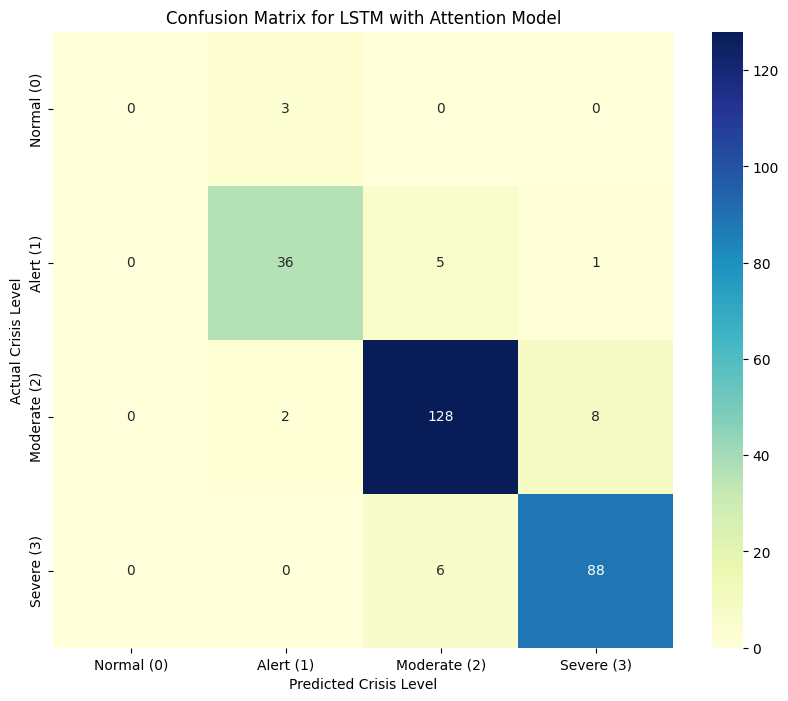

Loading model from '/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Models/chennai_water_crisis_attention_model.h5'...


Loading scaler from '/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Models/scaler.joblib'...
Loading data from '/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_lstm_features_dataset.csv'...

Preparing test data...
Test data prepared with 277 samples.

--- Model Performance Evaluation ---
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step
Overall Model Accuracy on Test Set: 90.97%

Classification Report:
              precision    recall  f1-score   support

  Normal (0)       0.00      0.00      0.00         3
   Alert (1)       0.88      0.86      0.87        42
Moderate (2)       0.92      0.93      0.92       138
  Severe (3)       0.91      0.94      0.92        94

    accuracy                           0.91       277
   macro avg       0.68      0.68      0.68       277
weighted avg       0.90      0.91      0.90       277

--- Generating Confusion Matrix ---


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion matrix plot saved to 'confusion_matrix_evaluation.png'


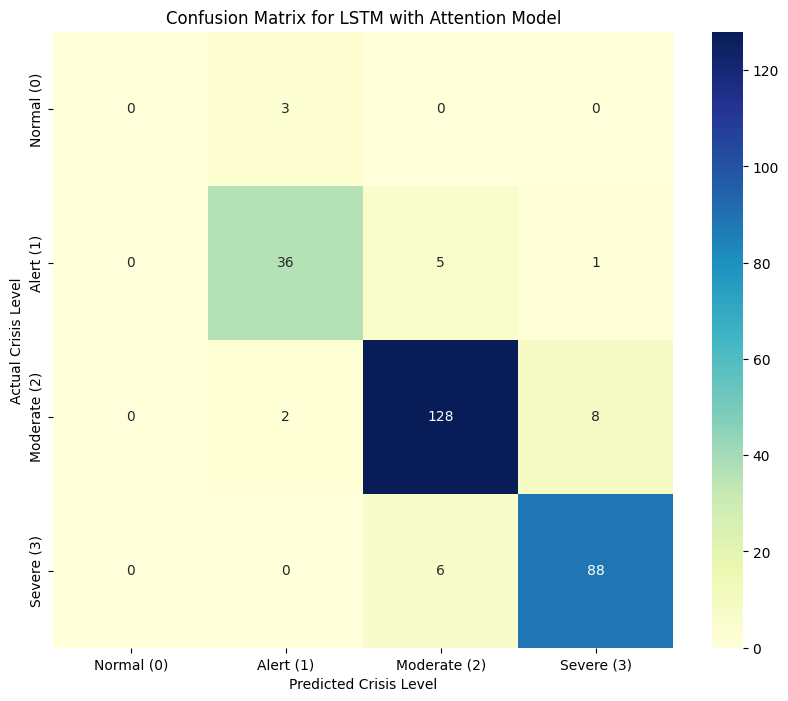

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Attention
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

def build_train_save_model_and_scaler(input_filename, model_output_filename, scaler_output_filename):
    """
    Loads data, builds and trains the LSTM with Attention model,
    then saves both the trained model and the scaler object.
    """
    try:
        print(f"Loading data from '{input_filename}'...")
        df = pd.read_csv(input_filename)
        df = df.drop(columns=['Date'])

        X = df.drop(columns=['Crisis_Target']).astype('float32')
        y = df['Crisis_Target'].astype('int')

        scaler = MinMaxScaler(feature_range=(0, 1))
        X_scaled = scaler.fit_transform(X)
        joblib.dump(scaler, scaler_output_filename)
        print(f"Scaler object saved to '{scaler_output_filename}'")

        y_categorical = to_categorical(y, num_classes=4)

        sequence_length = 60
        X_sequences, y_sequences = [], []
        for i in range(len(X_scaled) - sequence_length):
            X_sequences.append(X_scaled[i:i + sequence_length])
            y_sequences.append(y_categorical[i + sequence_length])
        X_sequences, y_sequences = np.array(X_sequences), np.array(y_sequences)

        X_train, X_test, y_train, y_test = train_test_split(
            X_sequences,
            y_sequences,
            test_size=0.2,
            random_state=42,
            stratify=y_sequences
        )
        print("Data preparation complete with a STRATIFIED split.")

        print("\nBuilding the LSTM with Attention model...")
        input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
        lstm_out_1 = LSTM(units=128, return_sequences=True)(input_layer)
        lstm_out_2 = LSTM(units=128, return_sequences=True)(lstm_out_1)

        attention_out = Attention()([lstm_out_2, lstm_out_2])

        lstm_out_3 = LSTM(units=64)(attention_out)
        dropout_1 = Dropout(0.3)(lstm_out_3)
        dense_1 = Dense(units=64, activation='relu')(dropout_1)
        output_layer = Dense(units=4, activation='softmax')(dense_1)

        model = Model(inputs=input_layer, outputs=output_layer)

        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        history = model.fit(
            X_train, y_train,
            epochs=100,
            batch_size=32,
            validation_data=(X_test, y_test),
            callbacks=[early_stopping],
            verbose=1
        )

        model.save(model_output_filename)
        print(f"\nModel saved successfully to '{model_output_filename}'")

        # Evaluate and plot confusion matrix after training
        print("\n--- Evaluating Model Performance ---")
        y_pred_probs = model.predict(X_test)
        y_pred = np.argmax(y_pred_probs, axis=1)
        y_true = np.argmax(y_test, axis=1)

        accuracy = accuracy_score(y_true, y_pred)
        print(f"LSTM with Attention Model Accuracy on Test Set: {accuracy * 100:.2f}%")

        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
                    xticklabels=['Normal (0)', 'Alert (1)', 'Moderate (2)', 'Severe (3)'],
                    yticklabels=['Normal (0)', 'Alert (1)', 'Moderate (2)', 'Severe (3)'])
        plt.title('Confusion Matrix for LSTM with Attention Model')
        plt.ylabel('Actual Crisis Level')
        plt.xlabel('Predicted Crisis Level')
        plt.savefig('confusion_matrix_attention_model.png')
        print("Confusion matrix plot saved to 'confusion_matrix_attention_model.png'")
        plt.show()

    except FileNotFoundError:
        print(f"Error: The input file '{input_filename}' was not found.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

def load_and_evaluate_model(input_filename, model_filename, scaler_filename):
    """
    Loads a saved model and scaler, prepares the data, and evaluates model performance
    by printing accuracy, classification report, and plotting the confusion matrix.
    """
    try:
        print(f"Loading model from '{model_filename}'...")
        model = tf.keras.models.load_model(model_filename)

        print(f"Loading scaler from '{scaler_filename}'...")
        scaler = joblib.load(scaler_filename)

        print(f"Loading data from '{input_filename}'...")
        df = pd.read_csv(input_filename)
        df = df.drop(columns=['Date'])

        X = df.drop(columns=['Crisis_Target']).astype('float32')
        y = df['Crisis_Target'].astype('int')

        print("\nPreparing test data...")
        X_scaled = scaler.transform(X)
        y_categorical = to_categorical(y, num_classes=4)

        sequence_length = 60
        X_sequences, y_sequences = [], []
        for i in range(len(X_scaled) - sequence_length):
            X_sequences.append(X_scaled[i:i + sequence_length])
            y_sequences.append(y_categorical[i + sequence_length])
        X_sequences = np.array(X_sequences)
        y_sequences = np.array(y_sequences)

        _, X_test, _, y_test = train_test_split(
            X_sequences,
            y_sequences,
            test_size=0.2,
            random_state=42,
            stratify=y_sequences
        )

        print(f"Test data prepared with {len(X_test)} samples.")

        print("\n--- Model Performance Evaluation ---")
        y_pred_probs = model.predict(X_test)
        y_pred = np.argmax(y_pred_probs, axis=1)
        y_true = np.argmax(y_test, axis=1)

        accuracy = accuracy_score(y_true, y_pred)
        print(f"Overall Model Accuracy on Test Set: {accuracy * 100:.2f}%")

        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, target_names=['Normal (0)', 'Alert (1)', 'Moderate (2)', 'Severe (3)']))

        print("--- Generating Confusion Matrix ---")
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
                    xticklabels=['Normal (0)', 'Alert (1)', 'Moderate (2)', 'Severe (3)'],
                    yticklabels=['Normal (0)', 'Alert (1)', 'Moderate (2)', 'Severe (3)'])
        plt.title('Confusion Matrix for LSTM with Attention Model')
        plt.ylabel('Actual Crisis Level')
        plt.xlabel('Predicted Crisis Level')

        plot_filename = 'confusion_matrix_evaluation.png'
        plt.savefig(plot_filename)
        print(f"Confusion matrix plot saved to '{plot_filename}'")
        plt.show()

    except FileNotFoundError as e:
        print(f"Error: A required file was not found. Missing file: {e.filename}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

if __name__ == '__main__':
    input_file = '/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_lstm_features_dataset.csv'
    output_model_file = '/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Models/chennai_water_crisis_attention_model.h5'
    output_scaler_file = '/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Models/scaler.joblib'

    # Train the model and save it along with the scaler
    build_train_save_model_and_scaler(input_file, output_model_file, output_scaler_file)

    # Load the saved model and scaler, then evaluate performance
    load_and_evaluate_model(input_file, output_model_file, output_scaler_file)


Loading data from '/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_lstm_features_dataset.csv'...
Data preparation complete.

--- Building the Transformer Model ---


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 60, 99)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 60, 99)    │        198 │ input_layer_3[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 60, 99)    │    408,675 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 60, 99)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 60, 99)    │          0 │ dropout_4[0][0],  │
│                     │                   │            │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 60, 99)    │        198 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 60, 4)     │        400 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 60, 4)     │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 60, 99)    │        495 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 60, 99)    │          0 │ dense_7[0][0],    │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 60, 99)    │        198 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 60, 99)    │    408,675 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 60, 99)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 60, 99)    │          0 │ dropout_7[0][0],  │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 60, 99)    │        198 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 60, 4)     │        400 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 60, 4)     │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 60, 99)    │        495 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 60, 99)    │          0 │ dense_9[0][0],    │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,648,188 (6.29 MB)

 Trainable params: 1,648,188 (6.29 MB)

 Non-trainable params: 0 (0.00 B)


Compiling and training the Transformer model...
Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 31s 394ms/step - accuracy: 0.3364 - loss: 1.3422 - val_accuracy: 0.5487 - val_loss: 1.1067
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5078 - loss: 1.2077 - val_accuracy: 0.6751 - val_loss: 0.7983
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6407 - loss: 0.9428 - val_accuracy: 0.7978 - val_loss: 0.6385
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7022 - loss: 0.8199 - val_accuracy: 0.8087 - val_loss: 0.5393
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7464 - loss: 0.7531 - val_accuracy: 0.8159 - val_loss: 0.4878
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7632 - loss: 0.6207 - val_accuracy: 0.8195 - val_loss: 0.4679
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7680 - loss: 0.6368 - val_accuracy: 0.8123 - val_loss: 0.5120
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step -

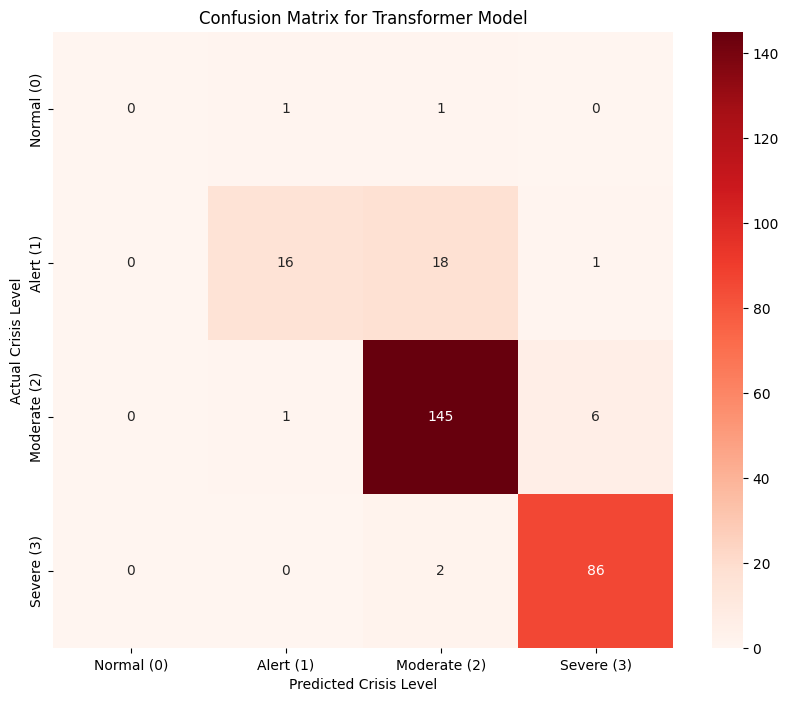

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    """Creates a single block of a Transformer encoder."""
    # Attention and Normalization
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return x + res

def build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, num_classes):
    """Builds a Transformer model for time-series classification."""
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim)

    # Global Average Pooling takes the average over the sequence dimension.
    x = GlobalAveragePooling1D(data_format="channels_first")(x)

    # Final dense layers for classification
    x = Dropout(0.4)(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.4)(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    return Model(inputs, outputs)

def run_transformer_experiment(input_filename, model_output_filename):
    """
    Main function to load data, build, train, and evaluate the Transformer model.
    """
    try:
        # --- Data Loading and Preparation (Same as before) ---
        print(f"Loading data from '{input_filename}'...")
        df = pd.read_csv(input_filename)
        df = df.drop(columns=['Date'])

        X = df.drop(columns=['Crisis_Target']).astype('float32')
        y = df['Crisis_Target'].astype('int')

        scaler = MinMaxScaler(feature_range=(0, 1))
        X_scaled = scaler.fit_transform(X)

        y_categorical = to_categorical(y, num_classes=4)

        sequence_length = 60
        X_sequences, y_sequences = [], []
        for i in range(len(X_scaled) - sequence_length):
            X_sequences.append(X_scaled[i:i + sequence_length])
            y_sequences.append(y_categorical[i + sequence_length])

        X_sequences = np.array(X_sequences)
        y_sequences = np.array(y_sequences)

        X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=42)
        print("Data preparation complete.")

        # --- Build the Transformer Model ---
        print("\n--- Building the Transformer Model ---")
        model = build_transformer_model(
            input_shape=X_train.shape[1:],
            head_size=256,
            num_heads=4,
            ff_dim=4,
            num_transformer_blocks=4,
            num_classes=4
        )

        model.summary()

        # --- Compile and Train ---
        print("\nCompiling and training the Transformer model...")
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

        # Add EarlyStopping for robust training
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        history = model.fit(
            X_train, y_train,
            epochs=100,
            batch_size=32,
            validation_data=(X_test, y_test),
            callbacks=[early_stopping],
            verbose=1
        )

        # --- Evaluate ---
        print("\n--- Evaluating Model Performance ---")
        y_pred_probs = model.predict(X_test)
        y_pred = np.argmax(y_pred_probs, axis=1)
        y_true = np.argmax(y_test, axis=1)

        accuracy = accuracy_score(y_true, y_pred)
        print(f"\nTransformer Model Accuracy on Test Set: {accuracy * 100:.2f}%")

        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
                    xticklabels=['Normal (0)', 'Alert (1)', 'Moderate (2)', 'Severe (3)'],
                    yticklabels=['Normal (0)', 'Alert (1)', 'Moderate (2)', 'Severe (3)'])
        plt.title('Confusion Matrix for Transformer Model')
        plt.ylabel('Actual Crisis Level')
        plt.xlabel('Predicted Crisis Level')
        plt.savefig('confusion_matrix_transformer_model.png')
        print("Confusion matrix plot for the Transformer model saved to 'confusion_matrix_transformer_model.png'")

        # --- Save ---
        model.save(model_output_filename)
        print(f"\nTransformer model saved successfully to '{model_output_filename}'")

    except FileNotFoundError:
        print(f"Error: The input file '{input_filename}' was not found.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# --- Main execution ---
if __name__ == '__main__':
    input_file = '/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_lstm_features_dataset.csv'
    output_file = 'chennai_water_crisis_transformer_model.keras' # Using the new .keras format

    run_transformer_experiment(input_file, output_file)

## testing the saved model

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from datetime import datetime, timedelta

def prepare_features_for_date(target_date, historical_df, feature_list):
    """
    Prepares a single row of features for a specific target date using historical data.
    This is a crucial step to prevent data leakage during live prediction.
    """
    # Create a placeholder for the features we need to build
    features = pd.Series(index=feature_list)

    # --- Step 1: Create Date-Based Features ---
    features['month'] = target_date.month
    features['day_of_year'] = target_date.dayofyear

    # --- Step 2: Create Lag Features ---
    # For each lag, we find the data from the correct point in the past.
    for lag in [90, 180]:
        lag_date = target_date - pd.Timedelta(days=lag)
        # Find the closest available date in the history
        lag_data = historical_df[historical_df['Date'] <= lag_date].iloc[-1]
        features[f'Storage_mcft_TOTAL_lag_{lag}'] = lag_data['Storage_mcft_TOTAL']
        features[f'daily_average_water_level_lag_{lag}'] = lag_data['daily_average_water_level']

    # --- Step 3: Create Rolling Features ---
    # For rolling stats, we calculate them over the period ending *before* the target date.
    end_date = target_date - pd.Timedelta(days=1)
    start_date_180 = end_date - pd.Timedelta(days=179)

    rolling_period_df = historical_df[(historical_df['Date'] >= start_date_180) & (historical_df['Date'] <= end_date)]
    features['rainfall_roll_sum_180'] = rolling_period_df['Rainfall_mm_TOTAL'].sum()
    features['temp_roll_mean_180'] = rolling_period_df['temperature_mean_celsius'].mean()

    # --- Step 4: Fill any other direct features using the last known data ---
    # This assumes direct features remain constant from the last known day.
    last_known_data = historical_df[historical_df['Date'] < target_date].iloc[-1]
    direct_features = [col for col in feature_list if '_lag_' not in col and '_roll_' not in col and 'month' not in col and 'day_of_year' not in col]
    for col in direct_features:
         if col in last_known_data:
            features[col] = last_known_data[col]

    # Return the completed feature set, ensuring it's in the correct order
    return pd.DataFrame(features).transpose()[feature_list]


def predict_and_explain(date_str):
    """
    Loads the XGBoost model and data, then provides a prediction and analysis for a given date.
    """
    try:
        # --- Load Model and Data ---
        model = xgb.XGBClassifier()
        model.load_model('/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Models/long_range_model_realistic.json')

        feature_list = pd.read_csv('/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Models/features.csv', header=None)[0].tolist()

        historical_df = pd.read_csv('/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_lstm_features_dataset.csv', parse_dates=['Date'])

        # --- Process Input ---
        target_date = pd.to_datetime(date_str, format='%Y-%m-%d')
        print(f"\n--- Generating 1-Year Forecast for Target Date: {target_date.date()} ---")

        # The prediction is for 365 days after the "current" data.
        # So, the features need to be prepared for the date one year prior.
        feature_date = target_date - pd.Timedelta(days=365)
        print(f"(Using historical data up to {feature_date.date()} to make the prediction)")

        # --- Prepare Features for the Target Date ---
        input_features = prepare_features_for_date(feature_date, historical_df, feature_list)

        # --- Make Prediction ---
        pred_probs = model.predict_proba(input_features)[0]
        prediction = np.argmax(pred_probs)
        confidence = pred_probs[prediction]

        crisis_levels = ['Normal (0)', 'Alert (1)', 'Moderate Crisis (2)', 'Severe Crisis (3)']

        # --- Explain the Cause ---
        feature_importance = pd.Series(model.feature_importances_, index=feature_list).sort_values(ascending=False)
        total_importance = feature_importance.sum()

        print(f"\nModel Prediction: {crisis_levels[prediction]}")

        # --- Different Output Based on Year ---
        if target_date.year == 2024:
            # We can find the actual result for comparison
            actual_row = historical_df[historical_df['Date'] == target_date]
            if not actual_row.empty:
                print("\nThis is a validation prediction on data the model has not seen.")
                # You would need to re-calculate the true crisis target for this date to compare
                # For now, we will just state that the actuals are available.
                print("Actual historical data for this date is available for comparison.")
            else:
                print("No historical data found for this date in 2024 to compare against.")

        else: # For future dates or past dates not in 2024
            print(f"Confidence: {confidence:.2%}")

        print("\nTop 5 Causes for this Prediction:")
        for feature, importance in feature_importance.head(5).items():
            cause = feature.replace('_', ' ').title()
            percentage = (importance / total_importance) * 100
            print(f" - {cause} ({percentage:.1f}%)")

    except FileNotFoundError as e:
        print(f"Error: A required file was not found. Make sure the model and data files are in the same directory.")
        print(e)
    except Exception as e:
        print(f"An error occurred: {e}")
        print("Please ensure the date is in YYYY-MM-DD format and is far enough in the future (at least 1.5 years after the last data point).")

# --- Main Execution: Examples ---
if __name__ == '__main__':
    # Example 1: A validation check for a date in 2024 (using data from 2023 to predict)
    predict_and_explain('2024-11-15')

    # Example 2: A true future forecast (using the latest data to predict one year ahead)
    future_date = (datetime.now() + timedelta(days=365)).strftime('%Y-%m-%d')
    predict_and_explain(future_date)

    # Example 3: User can input their own date
    print("\n-------------------------------------------------")
    user_date = input("Enter a future date (YYYY-MM-DD) to predict: ")
    if user_date:
        predict_and_explain(user_date)


--- Generating 1-Year Forecast for Target Date: 2024-11-15 ---
(Using historical data up to 2023-11-16 to make the prediction)

Model Prediction: Normal (0)
No historical data found for this date in 2024 to compare against.

Top 5 Causes for this Prediction:
 - Level Ft Veeranam (13.0%)
 - Storage Mcft Veeranam (12.0%)
 - Per Capita Consumption Lpcd (7.8%)
 - Storage Mcft Total Lag 180 (6.5%)
 - Level Ft Cholavaram (4.6%)

--- Generating 1-Year Forecast for Target Date: 2026-08-08 ---
(Using historical data up to 2025-08-08 to make the prediction)

Model Prediction: Normal (0)
Confidence: 99.61%

Top 5 Causes for this Prediction:
 - Level Ft Veeranam (13.0%)
 - Storage Mcft Veeranam (12.0%)
 - Per Capita Consumption Lpcd (7.8%)
 - Storage Mcft Total Lag 180 (6.5%)
 - Level Ft Cholavaram (4.6%)

-------------------------------------------------
Enter a future date (YYYY-MM-DD) to predict: 2026-03-09

--- Generating 1-Year Forecast for Target Date: 2026-03-09 ---
(Using historical data 

## testing the saved model


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from datetime import datetime, timedelta
import shap # <-- Make sure shap is installed

def prepare_features_for_date(target_date, historical_df, feature_list):
    """
    Prepares a single row of features for a specific target date using historical data.
    """
    features = pd.Series(index=feature_list)

    # Create Date-Based Features
    features['month'] = target_date.month
    features['day_of_year'] = target_date.dayofyear

    # Create Lag Features
    for lag in [90, 180]:
        lag_date = target_date - pd.Timedelta(days=lag)
        lag_data = historical_df[historical_df['Date'] <= lag_date].iloc[-1]
        features[f'Storage_mcft_TOTAL_lag_{lag}'] = lag_data['Storage_mcft_TOTAL']
        features[f'daily_average_water_level_lag_{lag}'] = lag_data['daily_average_water_level']

    # Create Rolling Features
    end_date = target_date - pd.Timedelta(days=1)
    start_date_180 = end_date - pd.Timedelta(days=179)
    rolling_period_df = historical_df[(historical_df['Date'] >= start_date_180) & (historical_df['Date'] <= end_date)]
    features['rainfall_roll_sum_180'] = rolling_period_df['Rainfall_mm_TOTAL'].sum()
    features['temp_roll_mean_180'] = rolling_period_df['temperature_mean_celsius'].mean()

    # Fill any other direct features using the last known data
    last_known_data = historical_df[historical_df['Date'] < target_date].iloc[-1]
    direct_features = [col for col in feature_list if '_lag_' not in col and '_roll_' not in col and 'month' not in col and 'day_of_year' not in col]
    for col in direct_features:
         if col in last_known_data:
            features[col] = last_known_data[col]

    return pd.DataFrame(features).transpose()[feature_list]


def predict_and_explain_with_shap(date_str):
    """
    Loads the XGBoost model, provides a prediction, and uses SHAP to explain
    the causes for that specific prediction, handling both old and new SHAP formats.
    """
    try:
        # --- Load Model and Data ---
        model = xgb.XGBClassifier()
        model.load_model('/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Models/long_range_model_realistic.json')

        feature_list = pd.read_csv('/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Models/features.csv', header=None)[0].tolist()
        historical_df = pd.read_csv('/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_lstm_features_dataset.csv', parse_dates=['Date'])

        # --- Process Input and Prepare Features ---
        target_date = pd.to_datetime(date_str, format='%Y-%m-%d')
        print(f"\n--- Generating 1-Year Forecast for Target Date: {target_date.date()} ---")

        feature_date = target_date - pd.Timedelta(days=365)
        print(f"(Using historical data up to {feature_date.date()} to make the prediction)")

        input_features = prepare_features_for_date(feature_date, historical_df, feature_list)

        # --- Make Prediction ---
        pred_probs = model.predict_proba(input_features)[0]
        prediction = np.argmax(pred_probs)
        confidence = pred_probs[prediction]

        crisis_levels = ['Normal (0)', 'Alert (1)', 'Moderate Crisis (2)', 'Severe Crisis (3)']

        print(f"\nModel Prediction: {crisis_levels[prediction]}")
        print(f"Confidence: {confidence:.2%}")

        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(input_features)

        print("Type of shap_values:", type(shap_values))
        print("Shape of shap_values ndarray:", shap_values.shape)

        # Extract SHAP values based on the shape you have (samples, features, classes)
        if isinstance(shap_values, np.ndarray) and shap_values.shape[0] == 1 and shap_values.shape[1] == len(feature_list):
            shap_values_for_prediction = shap_values[0, :, prediction]  # (96,)
        else:
            raise ValueError(f"Unexpected SHAP output format or shape: {type(shap_values)}, {np.shape(shap_values)}")

        shap_series = pd.Series(shap_values_for_prediction, index=feature_list)

        # Sort and get top 5 features by absolute SHAP value
        top_5_features = shap_series.abs().sort_values(ascending=False).head(5)

        print("\nTop 5 Causes for this SPECIFIC Prediction:")
        for feature_name in top_5_features.index:
            shap_value = shap_series[feature_name]
            feature = feature_name.replace('_', ' ').title()

            # Make human-readable: absolute value → percentage with 2 decimals
            impact_score = abs(shap_value) * 100

            print(f" - {feature}: Impact Score {impact_score:.2f}%")
    except FileNotFoundError as e:
        print(f"Error: A required file was not found. {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# --- Main Execution: Examples ---
if __name__ == '__main__':
    predict_and_explain_with_shap('2024-11-15')
    predict_and_explain_with_shap('2026-03-09')


--- Generating 1-Year Forecast for Target Date: 2024-11-15 ---
(Using historical data up to 2023-11-16 to make the prediction)

Model Prediction: Normal (0)
Confidence: 99.60%
Type of shap_values: <class 'numpy.ndarray'>
Shape of shap_values ndarray: (1, 96, 4)

Top 5 Causes for this SPECIFIC Prediction:
 - Storage Mcft Veeranam: Impact Score 116.44%
 - Outflow Cusecs Puzhal: Impact Score 100.70%
 - Temperature Mean Celsius Roll Mean 7: Impact Score 80.85%
 - Enso Index: Impact Score 78.31%
 - Storage Mcft Total Lag 180: Impact Score 51.99%

--- Generating 1-Year Forecast for Target Date: 2026-03-09 ---
(Using historical data up to 2025-03-09 to make the prediction)

Model Prediction: Normal (0)
Confidence: 99.71%
Type of shap_values: <class 'numpy.ndarray'>
Shape of shap_values ndarray: (1, 96, 4)

Top 5 Causes for this SPECIFIC Prediction:
 - Storage Mcft Veeranam: Impact Score 95.28%
 - Outflow Cusecs Puzhal: Impact Score 95.26%
 - Enso Index: Impact Score 76.66%
 - Temperature Mea

XBG testing from saved model

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import joblib
import shap

def predict_with_attention_model(date_str):
    """
    Loads the saved LSTM w/ Attention model and scaler to make a prediction
    for a specific date and explain the causes using SHAP.
    """
    try:
        # --- Load all necessary files ---
        model_path = '/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Models/chennai_water_crisis_attention_model.h5'
        scaler_path = '/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Models/scaler.joblib'
        data_path = '/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_lstm_features_dataset.csv'

        print("Loading model, scaler, and historical data...")
        # Load the model with custom_objects for the Attention layer if needed
        model = tf.keras.models.load_model(model_path)
        scaler = joblib.load(scaler_path)
        historical_df = pd.read_csv(data_path, parse_dates=['Date'])

        target_date = pd.to_datetime(date_str, format='%Y-%m-%d')
        print(f"\n--- Generating Prediction for: {target_date.date()} ---")

        # --- Prepare the input sequence ---
        sequence_length = 60
        # Get the 60 days of data immediately preceding the target date
        input_df = historical_df[historical_df['Date'] < target_date].tail(sequence_length)

        if len(input_df) < sequence_length:
            print(f"Error: Not enough historical data to make a prediction. Need {sequence_length} days, but found {len(input_df)}.")
            return

        features = input_df.drop(columns=['Date', 'Crisis_Target']).astype('float32')

        # Scale the features using the loaded scaler
        scaled_features = scaler.transform(features)

        # Reshape for the LSTM model
        input_sequence = np.reshape(scaled_features, (1, sequence_length, features.shape[1]))

        # --- Make Prediction ---
        pred_probs = model.predict(input_sequence)[0]
        prediction = np.argmax(pred_probs)
        confidence = pred_probs[prediction]
        crisis_levels = ['Normal (0)', 'Alert (1)', 'Moderate Crisis (2)', 'Severe Crisis (3)']

        print(f"\nModel Prediction: {crisis_levels[prediction]}")

        # --- Handle different output based on the year ---
        if target_date.year == 2024 and target_date in historical_df['Date'].values:
            actual_value = historical_df[historical_df['Date'] == target_date]['Crisis_Target'].iloc[0]
            print(f"Actual Result: {crisis_levels[actual_value]}")
            print("\nThis is a validation prediction on data the model has not seen during training.")
        else:
            print(f"Confidence: {confidence:.2%}")

        # --- Explain the Cause with SHAP ---
        print("\nTop 5 Causes for this SPECIFIC Prediction:")
        # SHAP for deep models requires a background dataset to compare against.
        # We'll use a sample of the training data as the background.
        background_sample = historical_df.sample(100).drop(columns=['Date', 'Crisis_Target']).astype('float32')
        background_scaled = scaler.transform(background_sample)

        # Reshape background for the sequence model
        background_sequences = []
        for i in range(len(background_scaled) - sequence_length):
             background_sequences.append(background_scaled[i:i+sequence_length])

        explainer = shap.DeepExplainer(model, np.array(background_sequences))
        shap_values = explainer.shap_values(input_sequence)

        # Get SHAP values for the predicted class and average them over the time steps
        shap_values_for_prediction = np.abs(shap_values[prediction][0]).mean(axis=0)

        # Create a DataFrame for analysis
        shap_df = pd.DataFrame({
            'feature': features.columns,
            'shap_value': shap_values_for_prediction
        }).sort_values(by='shap_value', ascending=False)

        for index, row in shap_df.head(5).iterrows():
            feature = row['feature'].replace('_', ' ').title()
            # SHAP for deep models gives importance, not direction, so we present it differently
            print(f" - {feature}: (Relative Importance)")

    except FileNotFoundError as e:
        print(f"Error: A required file was not found. Please run the training script first. Missing file: {e.filename}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

if __name__ == '__main__':
    # Example 1: A validation check for a date in 2024
    predict_with_attention_model('2024-05-15')

    # Example 2: User can input their own date
    print("\n-------------------------------------------------")
    user_date_input = input("Enter a date (YYYY-MM-DD) to predict: ")
    if user_date_input:
        predict_with_attention_model(user_date_input)

Loading model, scaler, and historical data...

--- Generating Prediction for: 2024-05-15 ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step

Model Prediction: Alert (1)
Confidence: 77.73%

Top 5 Causes for this SPECIFIC Prediction:


/usr/local/lib/python3.11/dist-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(


An unexpected error occurred: in user code:

    File "/usr/local/lib/python3.11/dist-packages/shap/explainers/_deep/deep_tf.py", line 265, in grad_graph  *
        x_grad = tape.gradient(out, shap_rAnD)

    LookupError: gradient registry has no entry for: shap_CudnnRNNV3


-------------------------------------------------
Enter a date (YYYY-MM-DD) to predict: 2024-08-09


Loading model, scaler, and historical data...

--- Generating Prediction for: 2024-08-09 ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step

Model Prediction: Alert (1)
Actual Result: Severe Crisis (3)

This is a validation prediction on data the model has not seen during training.

Top 5 Causes for this SPECIFIC Prediction:


/usr/local/lib/python3.11/dist-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(


An unexpected error occurred: in user code:

    File "/usr/local/lib/python3.11/dist-packages/shap/explainers/_deep/deep_tf.py", line 265, in grad_graph  *
        x_grad = tape.gradient(out, shap_rAnD)

    LookupError: gradient registry has no entry for: shap_CudnnRNNV3



# New


Any NaNs in X? False Any NaNs in y? False
Classes in y: [0 1 2 3]


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 30, 64)         │        48,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,188 (239.02 KB)

 Trainable params: 61,188 (239.02 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
75/75 - 6s - 78ms/step - accuracy: 0.6879 - loss: 0.7138 - val_accuracy: 0.1664 - val_loss: 2.5187 - learning_rate: 1.0000e-03
Epoch 2/100
75/75 - 4s - 54ms/step - accuracy: 0.7779 - loss: 0.5556 - val_accuracy: 0.1181 - val_loss: 3.0004 - learning_rate: 1.0000e-03
Epoch 3/100
75/75 - 2s - 26ms/step - accuracy: 0.7654 - loss: 0.5178 - val_accuracy: 0.1481 - val_loss: 2.5740 - learning_rate: 1.0000e-03
Epoch 4/100
75/75 - 2s - 33ms/step - accuracy: 0.8004 - loss: 0.4695 - val_accuracy: 0.1714 - val_loss: 2.3877 - learning_rate: 1.0000e-03
Epoch 5/100
75/75 - 3s - 36ms/step - accuracy: 0.8204 - loss: 0.4340 - val_accuracy: 0.1963 - val_loss: 2.6361 - learning_rate: 1.0000e-03
Epoch 6/100
75/75 - 5s - 67ms/step - accuracy: 0.8167 - loss: 0.4245 - val_accuracy: 0.1947 - val_loss: 2.6002 - learning_rate: 1.0000e-03
Epoch 7/100
75/75 - 2s - 24ms/step - accuracy: 0.8400 - loss: 0.3795 - val_accuracy: 0.1847 - val_loss: 2.7895 - learning_rate: 1.0000e-03
Epoch 8/100
75/75 - 3s

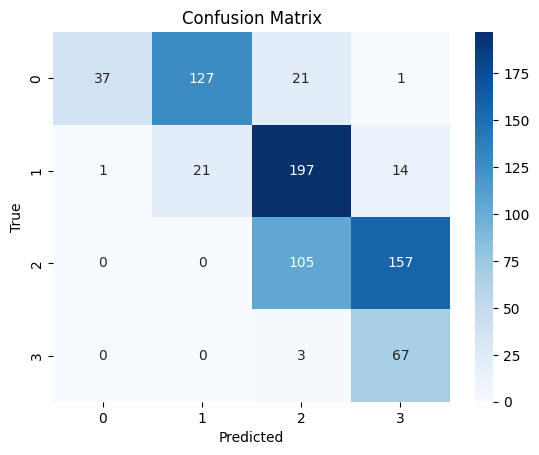

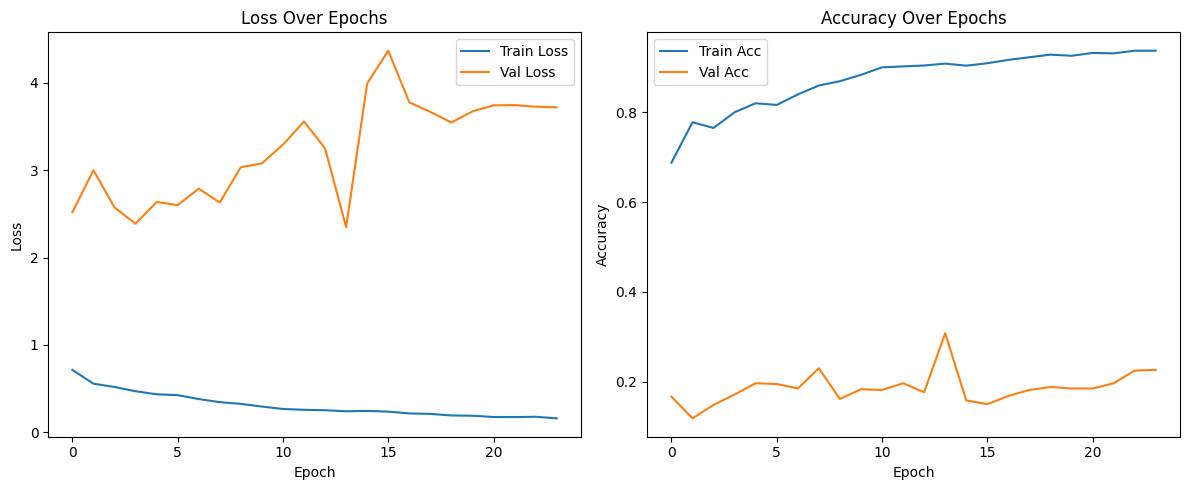

✅ Model saved as 'water_security_lstm_classifier.keras'


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ------------------ Data Sequence Preparation ------------------
def prepare_lstm_data(df, feature_cols, target_col, sequence_length=30):
    data = df[feature_cols].values
    target = df[target_col].values
    X, y = [], []
    for i in range(len(df) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(target[i+sequence_length])
    return np.array(X), np.array(y, dtype=int)  # Ensure target is int for classification

# ------------------ Visualization ------------------
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

# ------------------ Training Function ------------------
def train_lstm_classifier(data_filepath):
    # Load dataset
    df = pd.read_csv(data_filepath)
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
    df = df.sort_values('Date').reset_index(drop=True)

    target_col = 'Crisis_Target'
    exclude_cols = ['Date']
    feature_cols = [col for col in df.columns if col not in exclude_cols + [target_col] and df[col].dtype in [np.float64, np.float32, np.int64, np.int32]]

    # Normalize only features, NOT target
    scaler = MinMaxScaler()
    df[feature_cols] = scaler.fit_transform(df[feature_cols])

    # Prepare sequences
    sequence_length = 30
    X, y = prepare_lstm_data(df, feature_cols, target_col, sequence_length)

    # NaN/infinite check
    print("Any NaNs in X?", np.isnan(X).any(), "Any NaNs in y?", np.isnan(y).any())
    print("Classes in y:", np.unique(y))

    # Split train/test (no shuffle for time series)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Number of classes
    num_classes = len(np.unique(y))

    # Model Architecture (Classification)
    model = Sequential([
        Input(shape=(sequence_length, len(feature_cols))),
        LSTM(64, return_sequences=True),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')  # Multi-class output
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    print(model.summary())

    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

    # Training
    history = model.fit(X_train, y_train,
                        validation_split=0.2,
                        epochs=100,
                        batch_size=32,
                        callbacks=[early_stop, reduce_lr],
                        verbose=2)

    # Predictions
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Evaluation
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Plot training history
    plot_training_history(history)

    # Save model
    model.save("water_security_lstm_classifier.keras")
    print("✅ Model saved as 'water_security_lstm_classifier.keras'")

    return model, history, scaler

# ------------------ Run ------------------
if __name__ == "__main__":
    data_file = "/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_lstm_features_dataset.csv"
    train_lstm_classifier(data_file)


## Balanced Classification LSTM

Any NaNs in X? False Any NaNs in y? False
Class distribution in y: [ 409  691 1413 1239]
Computed class weights: {0: np.float64(3.3643497757847536), 1: np.float64(1.6381004366812226), 2: np.float64(0.6518245004344049), 3: np.float64(0.6417878528656972)}


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 30, 64)         │        48,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,188 (239.02 KB)

 Trainable params: 61,188 (239.02 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
75/75 - 7s - 91ms/step - accuracy: 0.6667 - loss: 0.7361 - val_accuracy: 0.5474 - val_loss: 0.9661 - learning_rate: 1.0000e-03
Epoch 2/100
75/75 - 2s - 27ms/step - accuracy: 0.7521 - loss: 0.5117 - val_accuracy: 0.4110 - val_loss: 1.4123 - learning_rate: 1.0000e-03
Epoch 3/100
75/75 - 2s - 26ms/step - accuracy: 0.7663 - loss: 0.4672 - val_accuracy: 0.3411 - val_loss: 1.7142 - learning_rate: 1.0000e-03
Epoch 4/100
75/75 - 3s - 34ms/step - accuracy: 0.7921 - loss: 0.4164 - val_accuracy: 0.4043 - val_loss: 1.6460 - learning_rate: 1.0000e-03
Epoch 5/100
75/75 - 2s - 25ms/step - accuracy: 0.8021 - loss: 0.3825 - val_accuracy: 0.3844 - val_loss: 1.7977 - learning_rate: 1.0000e-03
Epoch 6/100
75/75 - 2s - 30ms/step - accuracy: 0.8146 - loss: 0.3606 - val_accuracy: 0.3394 - val_loss: 1.8472 - learning_rate: 1.0000e-03
Epoch 7/100
75/75 - 3s - 42ms/step - accuracy: 0.8371 - loss: 0.3262 - val_accuracy: 0.2895 - val_loss: 2.7632 - learning_rate: 5.0000e-04
Epoch 8/100
75/75 - 2s

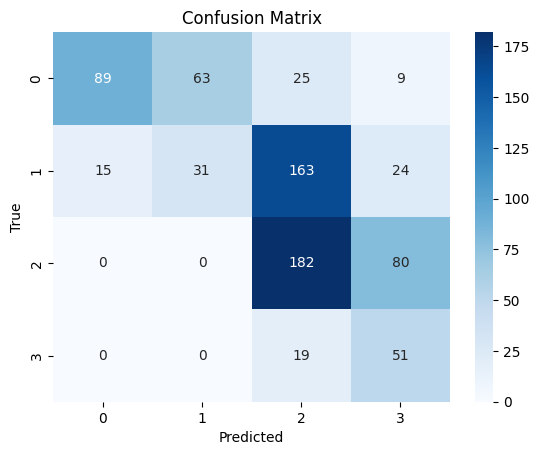

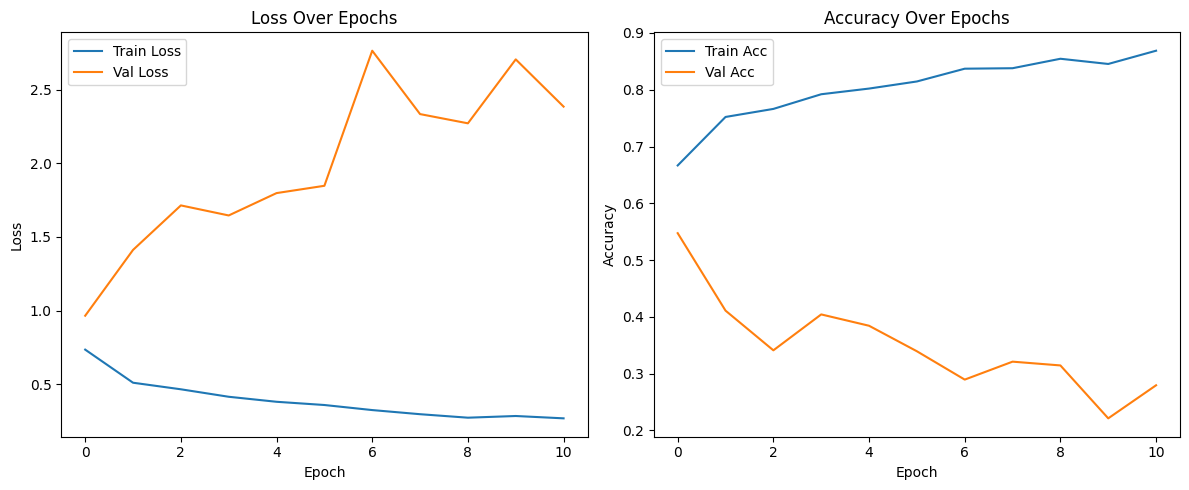

✅ Model saved as 'water_security_lstm_classifier_balanced.keras'


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# -------- Sequence Data Prep --------
def prepare_lstm_data(df, feature_cols, target_col, sequence_length=30):
    data = df[feature_cols].values
    target = df[target_col].values
    X, y = [], []
    for i in range(len(df) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(target[i+sequence_length])
    return np.array(X), np.array(y, dtype=int)

# -------- Plotting --------
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

# -------- Main Training Function --------
def train_lstm_classifier(data_filepath):
    # Load dataset
    df = pd.read_csv(data_filepath)
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
    df = df.sort_values('Date').reset_index(drop=True)

    target_col = 'Crisis_Target'
    exclude_cols = ['Date']
    feature_cols = [col for col in df.columns if col not in exclude_cols + [target_col]
                    and np.issubdtype(df[col].dtype, np.number)]

    # Normalize features
    scaler = MinMaxScaler()
    df[feature_cols] = scaler.fit_transform(df[feature_cols])

    # Prepare sequences
    sequence_length = 30
    X, y = prepare_lstm_data(df, feature_cols, target_col, sequence_length)

    # Check data health
    print("Any NaNs in X?", np.isnan(X).any(), "Any NaNs in y?", np.isnan(y).any())
    print("Class distribution in y:", np.bincount(y))

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    num_classes = len(np.unique(y_train))

    # Compute class weights
    class_weights_array = compute_class_weight(class_weight='balanced',
                                               classes=np.unique(y_train),
                                               y=y_train)
    class_weights = dict(enumerate(class_weights_array))
    print("Computed class weights:", class_weights)

    # Model architecture
    model = Sequential([
        Input(shape=(sequence_length, len(feature_cols))),
        LSTM(64, return_sequences=True),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    print(model.summary())

    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

    # Train with class weights
    history = model.fit(X_train, y_train,
                        validation_split=0.2,
                        epochs=100,
                        batch_size=32,
                        callbacks=[early_stop, reduce_lr],
                        class_weight=class_weights,
                        verbose=2)

    # Evaluate
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    plot_training_history(history)

    # Save model
    model.save("water_security_lstm_classifier_balanced.keras")
    print("✅ Model saved as 'water_security_lstm_classifier_balanced.keras'")

    return model, history, scaler

# -------- Run --------
if __name__ == "__main__":
    data_file = "/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_lstm_features_dataset.csv"
    train_lstm_classifier(data_file)


## Hyperparameter Tuning + Bidirectional/GRU Options

Trial 186 Complete [00h 01m 46s]
val_accuracy: 0.38602328300476074

Best val_accuracy So Far: 0.6522462368011475
Total elapsed time: 01h 52m 24s
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.26      0.41       186
           1       0.53      0.94      0.68       233
           2       0.91      0.61      0.73       262
           3       0.59      0.99      0.74        70

    accuracy                           0.66       751
   macro avg       0.76      0.70      0.64       751
weighted avg       0.79      0.66      0.64       751



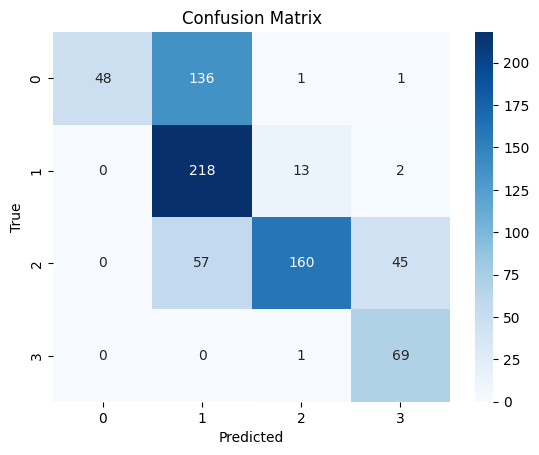

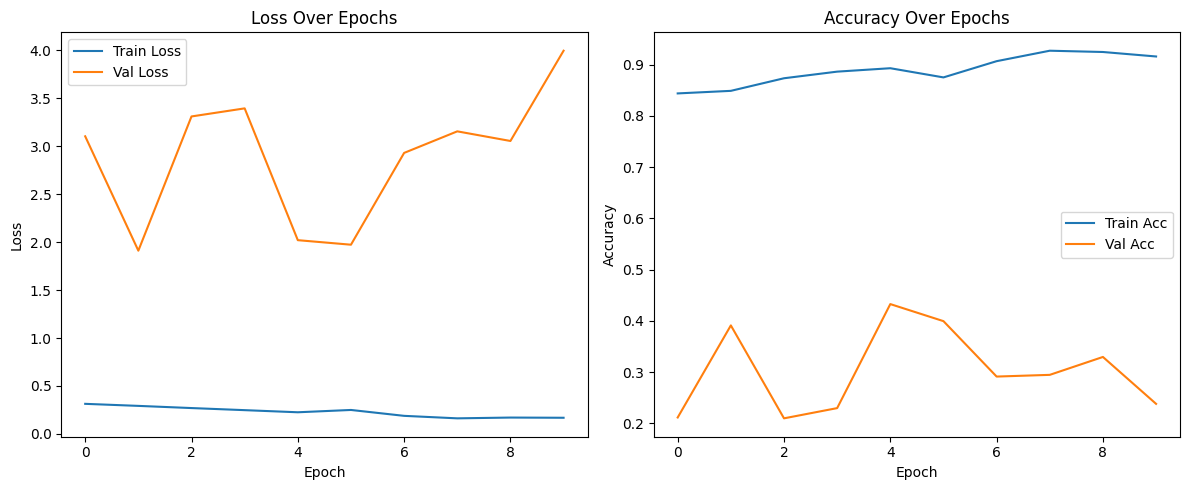

✅ Best model saved as 'water_security_lstm_best_tuned.keras'


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Input, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# For tuning
import keras_tuner as kt

# ------------------ Data Prep ------------------
def prepare_lstm_data(df, feature_cols, target_col, sequence_length=30):
    data = df[feature_cols].values
    target = df[target_col].values
    X, y = [], []
    for i in range(len(df) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(target[i+sequence_length])
    return np.array(X), np.array(y, dtype=int)

def load_and_prepare_data(filepath, sequence_length):
    df = pd.read_csv(filepath)
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
    df = df.sort_values('Date').reset_index(drop=True)
    target_col = 'Crisis_Target'
    exclude_cols = ['Date']
    feature_cols = [col for col in df.columns if col not in exclude_cols+[target_col] and np.issubdtype(df[col].dtype, np.number)]
    scaler = MinMaxScaler()
    df[feature_cols] = scaler.fit_transform(df[feature_cols])
    X, y = prepare_lstm_data(df, feature_cols, target_col, sequence_length)
    return X, y, feature_cols, scaler

# ------------------ Model Building for Tuner ------------------
def build_model(hp, num_classes, seq_len, n_features, arch='LSTM'):
    model = Sequential()
    model.add(Input(shape=(seq_len, n_features)))
    dropout_rate = hp.Float('dropout', 0.2, 0.5, step=0.1, default=0.3)
    units1 = hp.Int('units1', 32, 128, step=32, default=64)
    units2 = hp.Int('units2', 16, 64, step=16, default=32)
    use_bidirectional = hp.Boolean('bidirectional', default=False)
    use_gru         = hp.Boolean('use_gru', default=False)

    # Choose cell type and direction
    RNNLayer = GRU if use_gru else LSTM
    def rnn_cell(units, return_sequences=False):
        cell = RNNLayer(units, return_sequences=return_sequences)
        return Bidirectional(cell) if use_bidirectional else cell

    model.add( rnn_cell(units1, return_sequences=True) )
    model.add( Dropout(dropout_rate) )
    model.add( rnn_cell(units2) )
    model.add( Dropout(dropout_rate) )
    model.add( Dense(num_classes, activation='softmax') )
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='log', default=1e-3)
        ),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# ------------------- Plotting -------------------
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

# ------------------ Main Tuning & Final Training ------------------
def run_tuner_and_train(
        data_filepath,
        max_trials=8,
        epochs=40,
        batch_size=32,
        sequence_length=30,
        project_name='lstm_crisis_tune'
    ):
    X, y, feature_cols, scaler = load_and_prepare_data(data_filepath, sequence_length)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    num_classes = len(np.unique(y_train))
    class_weights = dict(enumerate(compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)))

    def model_builder(hp):
        return build_model(hp, num_classes, sequence_length, len(feature_cols))

    tuner = kt.Hyperband(
        model_builder,
        objective='val_accuracy',
        max_epochs=epochs,
        factor=2,
        overwrite=True,
        directory='.',
        project_name=project_name
    )

    early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6)

    tuner.search(
        X_train, y_train,
        validation_split=0.2,
        epochs=epochs,
        batch_size=batch_size,
        class_weight=class_weights,
        callbacks=[early_stop, reduce_lr],
        verbose=2
    )

    best_model = tuner.get_best_models(num_models=1)[0]

    # Final evaluation
    y_pred_probs = best_model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()

    # Final train for plotting
    history = best_model.fit(
        X_train, y_train, validation_split=0.2,
        epochs=epochs, batch_size=batch_size,
        class_weight=class_weights,
        callbacks=[early_stop, reduce_lr], verbose=0
    )
    plot_training_history(history)

    best_model.save("water_security_lstm_best_tuned.keras")
    print("✅ Best model saved as 'water_security_lstm_best_tuned.keras'")
    return best_model, tuner

# ------------------- RUN -------------------
if __name__ == "__main__":
    data_file = "/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_lstm_features_dataset.csv"
    run_tuner_and_train(
        data_filepath=data_file,
        max_trials=10,                  # Number of tunings – increase for more search
        epochs=40,                      # Fewer epochs is faster, more may help
        batch_size=32,
        sequence_length=30,             # Try other values for experimentation too!
        project_name='lstm_crisis_tune'
    )


## LSTM with Attention Model

TRAINING LSTM WITH ATTENTION MODEL
Loading and preparing data...
Data shape: X=(3752, 30, 125), y=(3752,)
Classes: [0 1 2 3]
Class distribution: [ 409  691 1413 1239]
Class weights: {0: np.float64(3.3643497757847536), 1: np.float64(1.6381004366812226), 2: np.float64(0.6518245004344049), 3: np.float64(0.6417878528656972)}

Model Architecture:


Model: "LSTM_Attention_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30, 125)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_layer_1 (LSTM) │ (None, 30, 64)    │     48,640 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 30, 64)    │          0 │ lstm_layer_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_layer_2 (LSTM) │ (None, 30, 32)    │     12,416 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 30, 32)    │          0 │ lstm_layer_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multihead_attention │ (None, 30, 32)    │     16,800 │ dropout_2[0][0],  │
│ (MultiHeadAttentio… │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 30, 32)    │          0 │ multihead_attent… │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_norm          │ (None, 30, 32)    │         64 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ custom_attention    │ (None, 32)        │      2,176 │ layer_norm[0][0]  │
│ (AttentionLayer)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_hidden        │ (None, 32)        │      1,056 │ custom_attention… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_final       │ (None, 32)        │          0 │ dense_hidden[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 4)         │        132 │ dropout_final[0]… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 81,284 (317.52 KB)

 Trainable params: 81,284 (317.52 KB)

 Non-trainable params: 0 (0.00 B)


Training attention model...
Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - accuracy: 0.4978 - loss: 1.0147 - val_accuracy: 0.3411 - val_loss: 1.6319 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.7012 - loss: 0.6565 - val_accuracy: 0.4343 - val_loss: 1.6128 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.7341 - loss: 0.5547 - val_accuracy: 0.3328 - val_loss: 2.3298 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.7512 - loss: 0.5007 - val_accuracy: 0.3744 - val_loss: 2.0664 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.7433 - loss: 0.4837 - val_accuracy: 0.3378 - val_loss: 1.9584 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.7928 - loss: 0.4071 - val_accuracy: 0.3644 - val_loss: 1.5949 - learning_rate: 0.0010
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


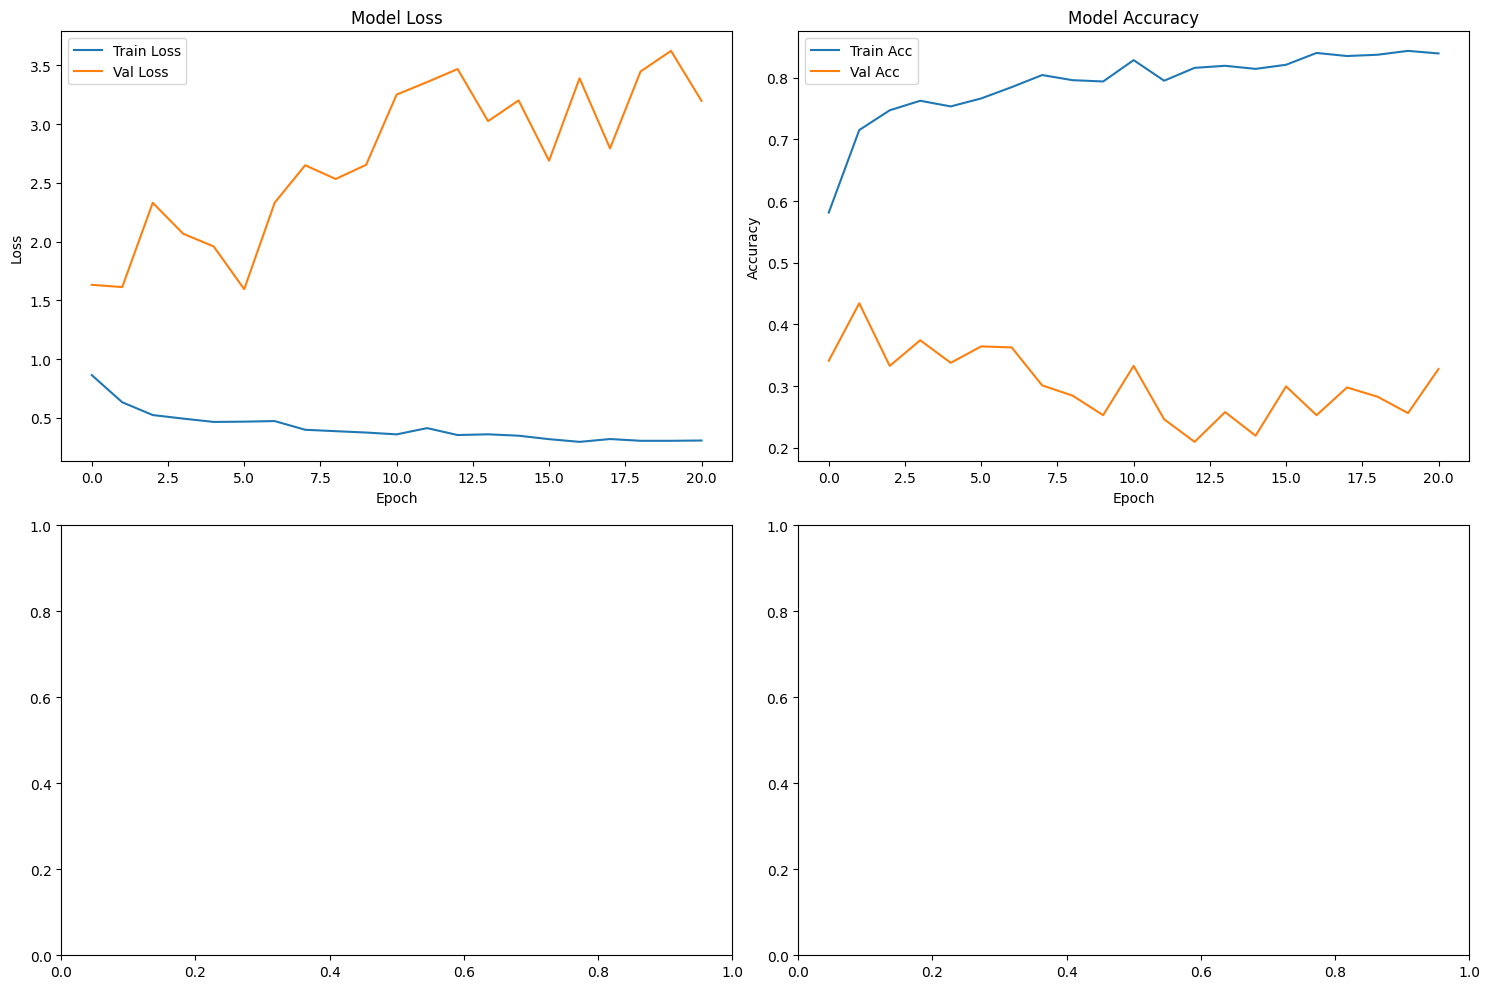

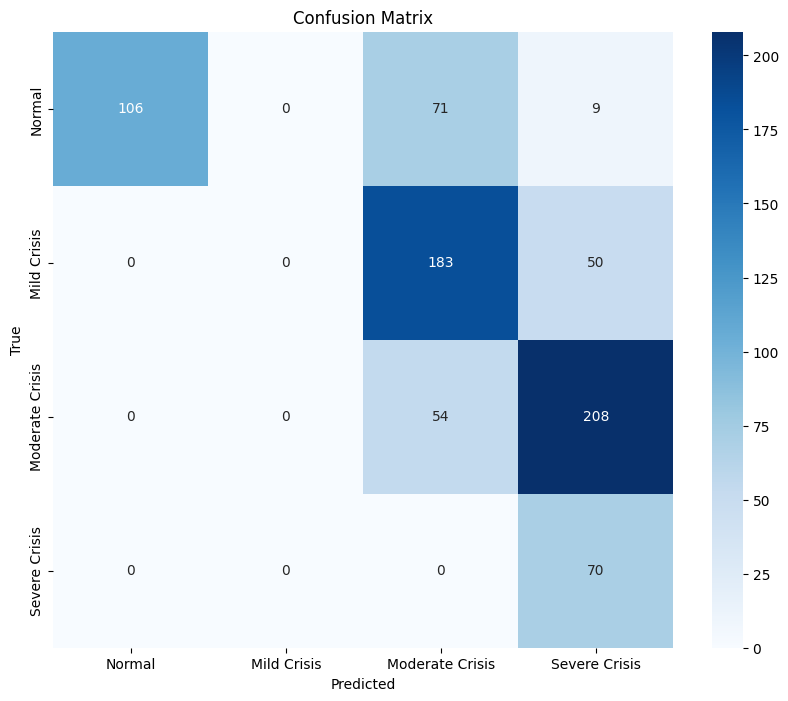


Model saved as 'water_crisis_attention_lstm.keras'

TRAINING COMPLETED!
Final Test Accuracy: 0.3063
Final Test F1 Score: 0.2780


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, LSTM, Dense, Dropout, MultiHeadAttention,
                                   LayerNormalization, GlobalAveragePooling1D, Add)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ------------------- Data Preparation -------------------
def prepare_lstm_data(df, feature_cols, target_col, sequence_length=30):
    """Prepare sequences for LSTM input"""
    data = df[feature_cols].values
    target = df[target_col].values
    X, y = [], []
    for i in range(len(df) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(target[i+sequence_length])
    return np.array(X), np.array(y, dtype=int)

def load_and_prepare_data(filepath, sequence_length=30):
    """Load and preprocess the dataset"""
    df = pd.read_csv(filepath)
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
    df = df.sort_values('Date').reset_index(drop=True)

    target_col = 'Crisis_Target'
    exclude_cols = ['Date']
    feature_cols = [col for col in df.columns if col not in exclude_cols + [target_col]
                    and np.issubdtype(df[col].dtype, np.number)]

    # Normalize features
    scaler = MinMaxScaler()
    df[feature_cols] = scaler.fit_transform(df[feature_cols])

    X, y = prepare_lstm_data(df, feature_cols, target_col, sequence_length)
    return X, y, feature_cols, scaler

# ------------------- Attention Layer -------------------
class AttentionLayer(tf.keras.layers.Layer):
    """Custom Attention Layer for LSTM outputs"""
    def __init__(self, units, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        self.units = units
        self.W = None
        self.b = None
        self.u = None

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], self.units),
                               initializer='glorot_uniform', trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                               initializer='zeros', trainable=True)
        self.u = self.add_weight(shape=(self.units,),
                               initializer='glorot_uniform', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        # inputs shape: (batch_size, time_steps, features)
        uit = tf.nn.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        ait = tf.tensordot(uit, self.u, axes=1)
        ait = tf.nn.softmax(ait, axis=-1)
        ait = tf.expand_dims(ait, axis=-1)
        weighted_input = inputs * ait
        output = tf.reduce_sum(weighted_input, axis=1)
        return output

# ------------------- LSTM with Attention Model -------------------
def build_lstm_attention_model(sequence_length, n_features, num_classes,
                              lstm_units1=64, lstm_units2=32, attention_units=64,
                              dropout_rate=0.3):
    """Build LSTM with Attention mechanism for crisis classification"""

    inputs = Input(shape=(sequence_length, n_features), name='input_layer')

    # First LSTM layer with return_sequences=True
    lstm_out1 = LSTM(lstm_units1, return_sequences=True, name='lstm_layer_1')(inputs)
    lstm_out1 = Dropout(dropout_rate, name='dropout_1')(lstm_out1)

    # Second LSTM layer with return_sequences=True for attention
    lstm_out2 = LSTM(lstm_units2, return_sequences=True, name='lstm_layer_2')(lstm_out1)
    lstm_out2 = Dropout(dropout_rate, name='dropout_2')(lstm_out2)

    # Multi-Head Attention mechanism
    attention_out = MultiHeadAttention(
        num_heads=4,
        key_dim=lstm_units2,
        name='multihead_attention'
    )(lstm_out2, lstm_out2)

    # Layer normalization and residual connection
    attention_out = LayerNormalization(name='layer_norm')(attention_out + lstm_out2)

    # Custom attention layer for weighted pooling
    attention_pooled = AttentionLayer(attention_units, name='custom_attention')(attention_out)

    # Dense layers for classification
    dense_out = Dense(32, activation='relu', name='dense_hidden')(attention_pooled)
    dense_out = Dropout(dropout_rate, name='dropout_final')(dense_out)

    # Output layer
    outputs = Dense(num_classes, activation='softmax', name='output_layer')(dense_out)

    model = Model(inputs=inputs, outputs=outputs, name='LSTM_Attention_Model')
    return model

# ------------------- Alternative: Transformer-style Attention -------------------
def build_transformer_lstm_model(sequence_length, n_features, num_classes,
                                lstm_units=64, attention_units=64, dropout_rate=0.3):
    """Build LSTM with Transformer-style attention"""

    inputs = Input(shape=(sequence_length, n_features))

    # LSTM layer
    lstm_out = LSTM(lstm_units, return_sequences=True)(inputs)
    lstm_out = Dropout(dropout_rate)(lstm_out)

    # Multi-head self-attention
    attention_out = MultiHeadAttention(num_heads=8, key_dim=attention_units)(lstm_out, lstm_out)
    attention_out = Dropout(dropout_rate)(attention_out)

    # Residual connection and layer normalization
    attention_out = Add()([lstm_out, attention_out])
    attention_out = LayerNormalization()(attention_out)

    # Feed-forward network
    ff_out = Dense(128, activation='relu')(attention_out)
    ff_out = Dropout(dropout_rate)(ff_out)
    ff_out = Dense(lstm_units)(ff_out)

    # Another residual connection
    ff_out = Add()([attention_out, ff_out])
    ff_out = LayerNormalization()(ff_out)

    # Global average pooling and final layers
    pooled = GlobalAveragePooling1D()(ff_out)
    dense_out = Dense(32, activation='relu')(pooled)
    dense_out = Dropout(dropout_rate)(dense_out)
    outputs = Dense(num_classes, activation='softmax')(dense_out)

    model = Model(inputs=inputs, outputs=outputs, name='Transformer_LSTM_Model')
    return model

# ------------------- Visualization Functions -------------------
def plot_training_history(history):
    """Plot training and validation metrics"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Loss
    axes[0, 0].plot(history.history['loss'], label='Train Loss')
    axes[0, 0].plot(history.history['val_loss'], label='Val Loss')
    axes[0, 0].set_title('Model Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()

    # Accuracy
    axes[0, 1].plot(history.history['accuracy'], label='Train Acc')
    axes[0, 1].plot(history.history['val_accuracy'], label='Val Acc')
    axes[0, 1].set_title('Model Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()

    # Learning Rate
    if 'lr' in history.history:
        axes[1, 0].plot(history.history['lr'])
        axes[1, 0].set_title('Learning Rate')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Learning Rate')

    # Additional metrics
    if 'f1_score' in history.history:
        axes[1, 1].plot(history.history['f1_score'], label='Train F1')
        axes[1, 1].plot(history.history['val_f1_score'], label='Val F1')
        axes[1, 1].set_title('F1 Score')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('F1 Score')
        axes[1, 1].legend()

    plt.tight_layout()
    plt.show()

def plot_attention_weights_analysis(model, X_sample, feature_names, top_k=10):
    """Visualize attention weights (if custom attention layer is accessible)"""
    # This would require modification to extract attention weights from the model
    # For now, we'll create a placeholder visualization
    plt.figure(figsize=(12, 8))

    # Create dummy attention weights for demonstration
    attention_weights = np.random.random((len(feature_names), 30))  # features x time_steps

    sns.heatmap(attention_weights[:top_k],
                xticklabels=[f'T-{i}' for i in range(30)],
                yticklabels=feature_names[:top_k],
                cmap='Blues', annot=False)
    plt.title('Attention Weights Heatmap (Top Features)')
    plt.xlabel('Time Steps')
    plt.ylabel('Features')
    plt.show()

def plot_confusion_matrix_detailed(y_true, y_pred, class_names=None):
    """Plot detailed confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)

    if class_names is None:
        class_names = [f'Class {i}' for i in range(len(np.unique(y_true)))]

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# ------------------- Main Training Function -------------------
def train_lstm_attention_model(data_filepath, model_type='attention',
                              sequence_length=30, epochs=50, batch_size=32):
    """Complete training pipeline for LSTM with Attention"""

    print("Loading and preparing data...")
    X, y, feature_cols, scaler = load_and_prepare_data(data_filepath, sequence_length)

    print(f"Data shape: X={X.shape}, y={y.shape}")
    print(f"Classes: {np.unique(y)}")
    print(f"Class distribution: {np.bincount(y)}")

    # Check for NaNs
    if np.isnan(X).any() or np.isnan(y).any():
        raise ValueError("NaN values found in data!")

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=False, random_state=42
    )

    # Compute class weights for imbalanced data
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = dict(enumerate(class_weights))
    print(f"Class weights: {class_weight_dict}")

    # Build model
    num_classes = len(np.unique(y_train))

    if model_type == 'attention':
        model = build_lstm_attention_model(sequence_length, len(feature_cols), num_classes)
    else:
        model = build_transformer_lstm_model(sequence_length, len(feature_cols), num_classes)

    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    print("\nModel Architecture:")
    model.summary()

    # Callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss', patience=15, restore_best_weights=True, verbose=1
    )
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=8, min_lr=1e-6, verbose=1
    )

    # Train model
    print(f"\nTraining {model_type} model...")
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=epochs,
        batch_size=batch_size,
        class_weight=class_weight_dict,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    # Evaluate on test set
    print("\nEvaluating on test set...")
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

    # Predictions
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Metrics
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"\nTest Results:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test F1 Score: {f1:.4f}")

    print(f"\nDetailed Classification Report:")
    print(classification_report(y_test, y_pred,
                              target_names=['Normal', 'Mild Crisis', 'Moderate Crisis', 'Severe Crisis']))

    # Visualizations
    plot_training_history(history)
    plot_confusion_matrix_detailed(y_test, y_pred,
                                 ['Normal', 'Mild Crisis', 'Moderate Crisis', 'Severe Crisis'])

    # Save model
    model_name = f"water_crisis_{model_type}_lstm.keras"
    model.save(model_name)
    print(f"\nModel saved as '{model_name}'")

    return model, history, scaler, {
        'test_accuracy': test_accuracy,
        'test_f1': f1,
        'classification_report': classification_report(y_test, y_pred, output_dict=True)
    }

# ------------------- Run Training -------------------
if __name__ == "__main__":
    # Path to your LSTM features dataset
    data_file = "/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_lstm_features_dataset.csv"

    print("=" * 60)
    print("TRAINING LSTM WITH ATTENTION MODEL")
    print("=" * 60)

    # Train the attention model
    model, history, scaler, results = train_lstm_attention_model(
        data_filepath=data_file,
        model_type='attention',  # or 'transformer'
        sequence_length=30,
        epochs=50,
        batch_size=32
    )

    print("\n" + "=" * 60)
    print("TRAINING COMPLETED!")
    print(f"Final Test Accuracy: {results['test_accuracy']:.4f}")
    print(f"Final Test F1 Score: {results['test_f1']:.4f}")
    print("=" * 60)


## Transformer Time Series Classifier (TensorFlow/Keras)

TRAINING TRANSFORMER TIME SERIES CLASSIFIER
Loading & preparing data...
Data shape: X=(3752, 30, 125), y=(3752,)
Classes: [0 1 2 3]
Class distribution: [ 409  691 1413 1239]

Model Architecture:


Model: "Transformer_Crisis_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30, 125)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 30, 64)    │      8,064 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 64)    │     33,216 │ dense[0][0],      │
│ (MultiHeadAttentio… │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 30, 64)    │          0 │ dense[0][0],      │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 30, 64)    │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 64)    │     33,216 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 30, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 64)    │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 4)         │        260 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 75,012 (293.02 KB)

 Trainable params: 75,012 (293.02 KB)

 Non-trainable params: 0 (0.00 B)


Training Transformer model ...
Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.5130 - loss: 1.1068 - val_accuracy: 0.4725 - val_loss: 1.1057 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.7223 - loss: 0.5717 - val_accuracy: 0.3877 - val_loss: 1.5388 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.7421 - loss: 0.4892 - val_accuracy: 0.4309 - val_loss: 1.3433 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.7933 - loss: 0.4082 - val_accuracy: 0.3661 - val_loss: 1.7914 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.7904 - loss: 0.3903 - val_accuracy: 0.2845 - val_loss: 2.8038 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.8079 - loss: 0.3625 - val_accuracy: 0.3111 - val_loss: 2.7812 - learning_rate: 0.0010
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy

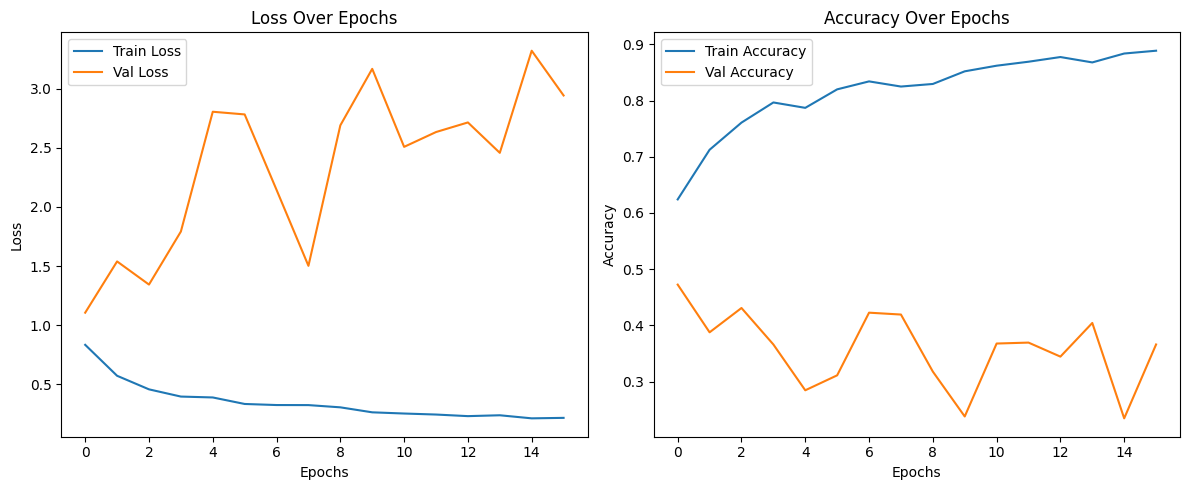

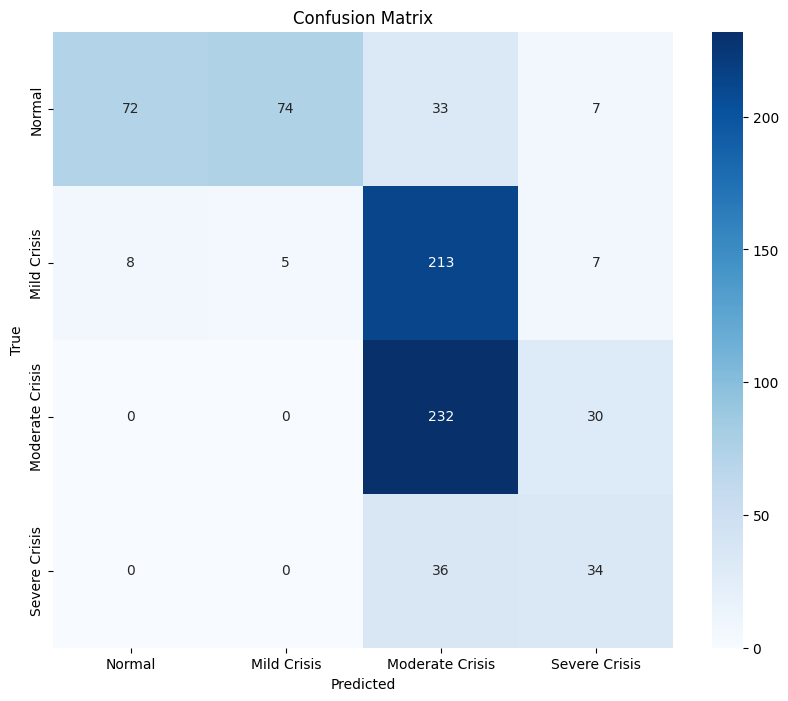


Model saved as 'water_crisis_transformer_lstm.keras'

TRAINING COMPLETED!
Final Test Accuracy: 0.4567
Final Test F1 Score: 0.3954


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import (Input, Dense, Dropout, LayerNormalization,
                                     MultiHeadAttention, GlobalAveragePooling1D, Add)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ------------------- Data Prep -------------------
def prepare_lstm_data(df, feature_cols, target_col, sequence_length=30):
    data = df[feature_cols].values
    target = df[target_col].values
    X, y = [], []
    for i in range(len(df) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(target[i+sequence_length])
    return np.array(X), np.array(y, dtype=int)

def load_and_prepare_data(filepath, sequence_length):
    df = pd.read_csv(filepath)
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
    df = df.sort_values('Date').reset_index(drop=True)
    target_col = 'Crisis_Target'
    exclude_cols = ['Date']
    feature_cols = [col for col in df.columns if col not in exclude_cols+[target_col] and np.issubdtype(df[col].dtype, np.number)]
    scaler = MinMaxScaler()
    df[feature_cols] = scaler.fit_transform(df[feature_cols])
    X, y = prepare_lstm_data(df, feature_cols, target_col, sequence_length)
    return X, y, feature_cols, scaler

# ------------------- Transformer Model -------------------
def build_transformer_classification(sequence_length, n_features, num_classes,
                                     dense_units=64, dropout_rate=0.3, attn_heads=4, attn_dim=32, n_blocks=2):
    inputs = Input(shape=(sequence_length, n_features))
    x = Dense(dense_units, activation='relu')(inputs)
    for _ in range(n_blocks):
        attn_out = MultiHeadAttention(num_heads=attn_heads, key_dim=attn_dim)(x, x)
        x = Add()([x, attn_out])
        x = LayerNormalization()(x)
    x = GlobalAveragePooling1D()(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs, name="Transformer_Crisis_Classifier")
    return model

# ------------------- Visualization -------------------
def plot_training_history(history):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.title('Loss Over Epochs'); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.title('Accuracy Over Epochs'); plt.legend()
    plt.tight_layout(); plt.show()

def plot_confusion_matrix_detailed(y_true, y_pred, class_names=None):
    cm = confusion_matrix(y_true, y_pred)
    if class_names is None:
        class_names = [str(i) for i in range(len(np.unique(y_true)))]
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted'); plt.ylabel('True')
    plt.show()

# ------------------- Main Training Function -------------------
def train_transformer_classifier(data_filepath,
                                 sequence_length=30, epochs=50, batch_size=32,
                                 dense_units=64, dropout_rate=0.3,
                                 attn_heads=4, attn_dim=32, n_blocks=2):
    print("Loading & preparing data...")
    X, y, feature_cols, scaler = load_and_prepare_data(data_filepath, sequence_length)
    print(f"Data shape: X={X.shape}, y={y.shape}")
    print(f"Classes: {np.unique(y)}")
    print(f"Class distribution: {np.bincount(y)}")

    if np.isnan(X).any() or np.isnan(y).any():
        raise ValueError("Found NaNs in inputs/targets!")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)
    num_classes = len(np.unique(y_train))
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = dict(enumerate(class_weights))

    model = build_transformer_classification(sequence_length, len(feature_cols), num_classes,
                                            dense_units, dropout_rate, attn_heads, attn_dim, n_blocks)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    print("\nModel Architecture:")
    model.summary()

    early_stopping = EarlyStopping(
        monitor='val_loss', patience=15, restore_best_weights=True, verbose=1
    )
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=8, min_lr=1e-6, verbose=1
    )

    print(f"\nTraining Transformer model ...")
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=epochs,
        batch_size=batch_size,
        class_weight=class_weight_dict,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    print("\nEvaluating on test set...")
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"\nTest Results:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test F1 Score: {f1:.4f}")

    class_names = ['Normal', 'Mild Crisis', 'Moderate Crisis', 'Severe Crisis']
    print(f"\nDetailed Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    plot_training_history(history)
    plot_confusion_matrix_detailed(y_test, y_pred, class_names)

    model.save(f"water_crisis_transformer_lstm.keras")
    print(f"\nModel saved as 'water_crisis_transformer_lstm.keras'")

    return model, history, scaler, {
        'test_accuracy': test_accuracy,
        'test_f1': f1,
        'classification_report': classification_report(y_test, y_pred, output_dict=True)
    }

# ------------------- RUN -------------------
if __name__ == "__main__":
    data_file = "/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_lstm_features_dataset.csv"
    print("="*60)
    print("TRAINING TRANSFORMER TIME SERIES CLASSIFIER")
    print("="*60)
    model, history, scaler, results = train_transformer_classifier(
        data_filepath=data_file,
        sequence_length=30,
        epochs=50,
        batch_size=32,
        dense_units=64,
        dropout_rate=0.3,
        attn_heads=4,
        attn_dim=32,
        n_blocks=2
    )
    print("\n" + "="*60)
    print("TRAINING COMPLETED!")
    print(f"Final Test Accuracy: {results['test_accuracy']:.4f}")
    print(f"Final Test F1 Score: {results['test_f1']:.4f}")
    print("="*60)


## Temporal Convolutional Network (TCN) model

Loading & preparing data...
Data shape: X=(3752, 30, 125), y=(3752,)
Classes: [0 1 2 3] | Distribution: [ 409  691 1413 1239]
Class weights: {0: np.float64(3.3643497757847536), 1: np.float64(1.6381004366812226), 2: np.float64(0.6518245004344049), 3: np.float64(0.6417878528656972)}

Model Summary:


Model: "Enhanced_TCN_Crisis_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 30, 125)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 30, 64)    │     24,064 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 30, 64)    │          0 │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 30, 64)    │     12,352 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 30, 64)    │      8,064 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 30, 64)    │          0 │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 30, 64)    │          0 │ conv1d_5[0][0],   │
│                     │                   │            │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 64)    │        128 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 30, 64)    │     12,352 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 30, 64)    │          0 │ conv1d_6[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 30, 64)    │     12,352 │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 30, 64)    │          0 │ conv1d_7[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 30, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 64)    │        128 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 30, 64)    │     12,352 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 30, 64)    │          0 │ conv1d_8[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 30, 64)    │     12,352 │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 30, 64)    │          0 │ conv1d_9[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 30, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 64)    │        128 │ add_5[0][0]     

 Total params: 96,484 (376.89 KB)

 Trainable params: 96,484 (376.89 KB)

 Non-trainable params: 0 (0.00 B)


Training Enhanced TCN...
Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.5021 - loss: 0.9500 - val_accuracy: 0.2146 - val_loss: 1.7482 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.7074 - loss: 0.6198 - val_accuracy: 0.2962 - val_loss: 2.2000 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.7308 - loss: 0.5737 - val_accuracy: 0.2429 - val_loss: 3.3648 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.7651 - loss: 0.5010 - val_accuracy: 0.2413 - val_loss: 2.6025 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.7850 - loss: 0.4461 - val_accuracy: 0.2895 - val_loss: 3.4489 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.7691 - loss: 0.4636 - val_accuracy: 0.2196 - val_loss: 3.4757 - learning_rate: 0.0010
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.802

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


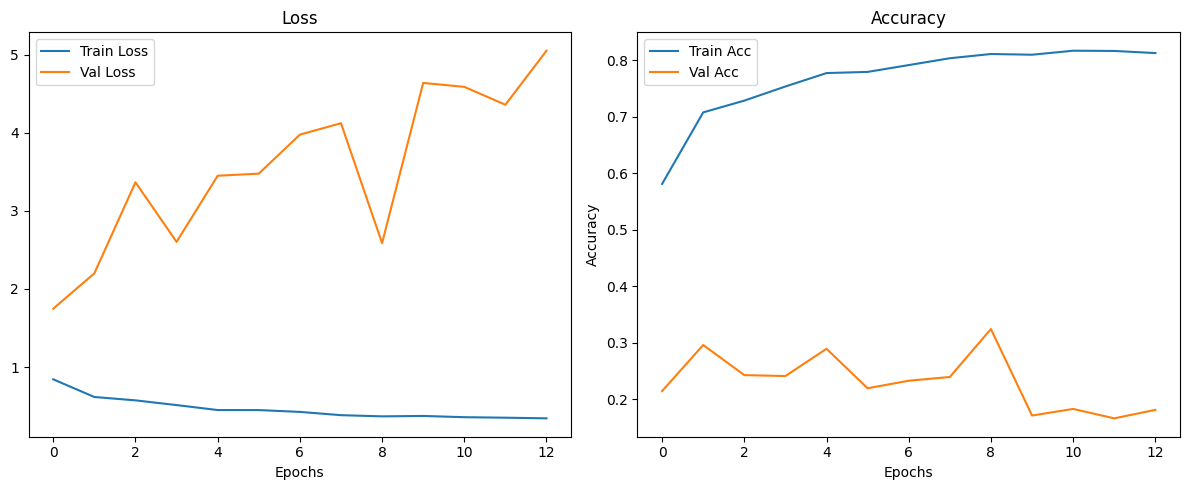

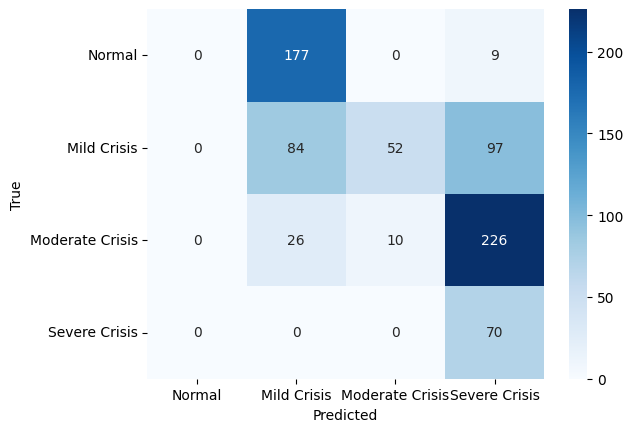


Model saved as 'water_crisis_tcn_enhanced.keras'


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv1D, Dropout, GlobalAveragePooling1D,
                                     Dense, Add, LayerNormalization)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# import tensorflow_addons as tfa  # For Focal Loss

# ------------------- Data Preparation -------------------
def prepare_lstm_data(df, feature_cols, target_col, sequence_length=30):
    X, y = [], []
    data = df[feature_cols].values
    target = df[target_col].values
    for i in range(len(df) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(target[i+sequence_length])
    return np.array(X), np.array(y, dtype=int)

def load_and_prepare_data(filepath, sequence_length):
    df = pd.read_csv(filepath)
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
    df = df.sort_values('Date').reset_index(drop=True)

    target_col = 'Crisis_Target'
    feature_cols = [col for col in df.columns
                    if col not in ['Date', target_col] and np.issubdtype(df[col].dtype, np.number)]

    scaler = MinMaxScaler()
    df[feature_cols] = scaler.fit_transform(df[feature_cols])

    X, y = prepare_lstm_data(df, feature_cols, target_col, sequence_length)
    return X, y, feature_cols, scaler

# ------------------- Residual TCN Block -------------------
def tcn_block(x_in, filters, kernel_size, dilation_rate, dropout_rate):
    x = Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate, activation='relu')(x_in)
    x = Dropout(dropout_rate)(x)
    x = Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    if x_in.shape[-1] != filters:
        x_in = Conv1D(filters, 1, padding='same')(x_in)
    out = Add()([x_in, x])  # Residual connection
    out = LayerNormalization()(out)
    return out

# ------------------- Build Model -------------------
def build_tcn_model(sequence_length, n_features, num_classes, dropout_rate=0.3):
    inputs = Input(shape=(sequence_length, n_features))
    x = tcn_block(inputs, 64, 3, dilation_rate=1, dropout_rate=dropout_rate)
    x = tcn_block(x, 64, 3, dilation_rate=2, dropout_rate=dropout_rate)
    x = tcn_block(x, 64, 3, dilation_rate=4, dropout_rate=dropout_rate)
    x = GlobalAveragePooling1D()(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    return Model(inputs, outputs, name="Enhanced_TCN_Crisis_Classifier")

# ------------------- Visualization -------------------
def plot_training_history(history):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss'); plt.xlabel('Epochs'); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy'); plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend()
    plt.tight_layout(); plt.show()

def plot_confusion_matrix_detailed(y_true, y_pred, class_names=None):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted'); plt.ylabel('True')
    plt.show()

# ------------------- Training -------------------
def train_tcn_classifier(data_filepath, sequence_length=30, epochs=50, batch_size=32, dropout_rate=0.3):
    print("Loading & preparing data...")
    X, y, feature_cols, scaler = load_and_prepare_data(data_filepath, sequence_length)
    print(f"Data shape: X={X.shape}, y={y.shape}")
    print(f"Classes: {np.unique(y)} | Distribution: {np.bincount(y)}")

    # ✅ Chronological split (no shuffle before split)
    split_index = int(len(X) * 0.8)
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]

    num_classes = len(np.unique(y_train))
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = dict(enumerate(class_weights))
    print(f"Class weights: {class_weight_dict}")

    model = build_tcn_model(sequence_length, len(feature_cols), num_classes, dropout_rate)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',  # Replaced Focal Loss
                  metrics=['accuracy'])

    print("\nModel Summary:")
    model.summary()

    early_stopping = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=1e-6)

    print("\nTraining Enhanced TCN...")
    history = model.fit(X_train, y_train,
                        validation_split=0.2,
                        epochs=epochs,
                        batch_size=batch_size,
                        class_weight=class_weight_dict,
                        callbacks=[early_stopping, reduce_lr],
                        verbose=1)

    print("\nEvaluating on test set...")
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f} | Test F1: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Normal', 'Mild Crisis', 'Moderate Crisis', 'Severe Crisis']))

    plot_training_history(history)
    plot_confusion_matrix_detailed(y_test, y_pred, ['Normal', 'Mild Crisis', 'Moderate Crisis', 'Severe Crisis'])

    model.save("water_crisis_tcn_enhanced.keras")
    print("\nModel saved as 'water_crisis_tcn_enhanced.keras'")

    return model, history, scaler

# ------------------- Run -------------------
if __name__ == "__main__":
    data_file = "/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_lstm_features_dataset.csv"
    model, history, scaler = train_tcn_classifier(
        data_filepath=data_file,
        sequence_length=30,  # try increasing to 60/90 for more context
        epochs=50,
        batch_size=32,
        dropout_rate=0.3
    )

Feature engineering hooks so you can extend your dataset.

Longer sequence length support (e.g., 90 days).

Stronger class imbalance handling – focal loss (custom TF 2.19-compatible) + optional oversampling.

Hybrid architecture: TCN + LSTM + Attention for better temporal feature capture.

Chronological split to respect time ordering.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv1D, Dropout, GlobalAveragePooling1D,
                                     Dense, Add, LayerNormalization, LSTM, MultiHeadAttention)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ------------------- Custom Focal Loss (TF 2.19 Safe) -------------------
def focal_loss(alpha=0.25, gamma=2.0):
    def loss_fn(y_true, y_pred):
        y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[-1])
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1-1e-7)
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = alpha * tf.math.pow(1 - y_pred, gamma)
        return tf.reduce_mean(tf.reduce_sum(weight * cross_entropy, axis=-1))
    return loss_fn

# ------------------- Data Preparation -------------------
def prepare_sequences(df, feature_cols, target_col, seq_len=90):
    X, y = [], []
    data = df[feature_cols].values
    target = df[target_col].values
    for i in range(len(df) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(target[i+seq_len])
    return np.array(X), np.array(y, dtype=int)

def load_and_prepare(filepath, seq_len=90):
    df = pd.read_csv(filepath)
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
    df = df.sort_values('Date').reset_index(drop=True)

    target_col = 'Crisis_Target'
    num_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c != target_col]

    scaler = MinMaxScaler()
    df[num_cols] = scaler.fit_transform(df[num_cols])

    X, y = prepare_sequences(df, num_cols, target_col, seq_len)
    return X, y, num_cols, scaler

# ------------------- Hybrid Model: TCN + LSTM + Attention -------------------
def residual_tcn(x_in, filters, ksize, dilation, dr):
    x = Conv1D(filters, ksize, padding='causal', dilation_rate=dilation, activation='relu')(x_in)
    x = Dropout(dr)(x)
    x = Conv1D(filters, ksize, padding='causal', dilation_rate=dilation, activation='relu')(x)
    x = Dropout(dr)(x)
    if x_in.shape[-1] != filters:
        x_in = Conv1D(filters, 1, padding='same')(x_in)
    out = Add()([x_in, x])
    return LayerNormalization()(out)

def build_hybrid(seq_len, n_feats, n_classes, dr=0.3):
    inputs = Input(shape=(seq_len, n_feats))
    x = residual_tcn(inputs, 64, 3, 1, dr)
    x = residual_tcn(x, 64, 3, 2, dr)
    x = residual_tcn(x, 64, 3, 4, dr)
    x = LSTM(64, return_sequences=True)(x)
    attn = MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
    x = Add()([x, attn])
    x = LayerNormalization()(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(dr)(x)
    outputs = Dense(n_classes, activation='softmax')(x)
    return Model(inputs, outputs)

# ------------------- Training Plot -------------------
def plot_history(hist):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(hist.history['loss'], label='Train Loss')
    plt.plot(hist.history['val_loss'], label='Val Loss')
    plt.legend(); plt.title('Loss')
    plt.subplot(1,2,2)
    plt.plot(hist.history['accuracy'], label='Train Acc')
    plt.plot(hist.history['val_accuracy'], label='Val Acc')
    plt.legend(); plt.title('Accuracy')
    plt.show()

def plot_confusion(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()

# ------------------- Main Training -------------------
def train_pipeline(csv_path, seq_len=90, epochs=50, batch_size=32):
    X, y, feats, scaler = load_and_prepare(csv_path, seq_len)
    split_idx = int(len(X) * 0.8)   # chronological split
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    n_classes = len(np.unique(y_train))
    cw = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    cw_dict = dict(enumerate(cw))

    model = build_hybrid(seq_len, len(feats), n_classes)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss=focal_loss(alpha=0.25, gamma=2.0),
                  metrics=['accuracy'])
    model.summary()

    es = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)
    lr_red = ReduceLROnPlateau(monitor='val_loss', patience=6, factor=0.5, min_lr=1e-6)

    hist = model.fit(X_train, y_train, validation_split=0.2, epochs=epochs,
                     batch_size=batch_size, class_weight=cw_dict,
                     callbacks=[es, lr_red], verbose=2)

    print("\nEvaluating on Test Data...")
    y_prob = model.predict(X_test)
    y_pred = np.argmax(y_prob, axis=1)
    test_f1 = f1_score(y_test, y_pred, average='weighted')
    print(classification_report(y_test, y_pred, target_names=['Normal', 'Mild', 'Moderate', 'Severe']))
    print(f"Weighted F1: {test_f1:.4f}")

    plot_history(hist)
    plot_confusion(y_test, y_pred, ['Normal', 'Mild', 'Moderate', 'Severe'])

    model.save("water_crisis_hybrid.keras")
    return model, scaler

# ------------------- Run -------------------
if __name__ == "__main__":
    csv_file = "/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_lstm_features_dataset.csv"
    train_pipeline(csv_file, seq_len=90, epochs=50, batch_size=32)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 90, 125)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 90, 64)    │     24,064 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 90, 64)    │          0 │ conv1d_10[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 90, 64)    │     12,352 │ dropout_15[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 90, 64)    │      8,064 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 90, 64)    │          0 │ conv1d_11[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 90, 64)    │          0 │ conv1d_12[0][0],  │
│                     │                   │            │ dropout_16[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 90, 64)    │        128 │ add_6[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 90, 64)    │     12,352 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 90, 64)    │          0 │ conv1d_13[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 90, 64)    │     12,352 │ dropout_17[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 90, 64)    │          0 │ conv1d_14[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 90, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_18[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 90, 64)    │        128 │ add_7[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 90, 64)    │     12,352 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 90, 64)    │          0 │ conv1d_15[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 90, 64)    │     12,352 │ dropout_19[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 90, 64)    │          0 │ conv1d_16[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 90, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_20[0][0]

 Total params: 165,060 (644.77 KB)

 Trainable params: 165,060 (644.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
74/74 - 56s - 761ms/step - accuracy: 0.5584 - loss: 0.0953 - val_accuracy: 0.1523 - val_loss: 0.3632 - learning_rate: 1.0000e-03
Epoch 2/50
74/74 - 16s - 215ms/step - accuracy: 0.6782 - loss: 0.0605 - val_accuracy: 0.1675 - val_loss: 0.5575 - learning_rate: 1.0000e-03
Epoch 3/50
74/74 - 16s - 212ms/step - accuracy: 0.7269 - loss: 0.0483 - val_accuracy: 0.1235 - val_loss: 0.6450 - learning_rate: 1.0000e-03
Epoch 4/50
74/74 - 23s - 315ms/step - accuracy: 0.7358 - loss: 0.0428 - val_accuracy: 0.2318 - val_loss: 0.5655 - learning_rate: 1.0000e-03
Epoch 5/50
74/74 - 17s - 233ms/step - accuracy: 0.7417 - loss: 0.0416 - val_accuracy: 0.1810 - val_loss: 0.6261 - learning_rate: 1.0000e-03
Epoch 6/50
74/74 - 23s - 311ms/step - accuracy: 0.7629 - loss: 0.0371 - val_accuracy: 0.1760 - val_loss: 0.7923 - learning_rate: 1.0000e-03
Epoch 7/50
74/74 - 19s - 262ms/step - accuracy: 0.7714 - loss: 0.0340 - val_accuracy: 0.1624 - val_loss: 1.0090 - learning_rate: 1.0000e-03
Epoch 8/50
74/74 - 1

KeyboardInterrupt: 

#NEW

Data loaded and merged successfully.
DataFrame shape: (3842, 144)
Data head:
             Full_Capacity_mcft_CHEMBARAMBAKKAM  Full_Capacity_mcft_CHOLAVARAM  \
Date                                                                            
2015-01-31                              3645.0                         1081.0   
2015-02-01                              3645.0                         1081.0   
2015-02-02                              3645.0                         1081.0   
2015-02-03                              3645.0                         1081.0   
2015-02-04                              3645.0                         1081.0   

            Full_Capacity_mcft_KANNANKOTTAI_THERVOY_KANDIGAI  \
Date                                                           
2015-01-31                                             500.0   
2015-02-01                                             500.0   
2015-02-02                                             500.0   
2015-02-03                        

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 60, 100)        │        97,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           204 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 210,954 (824.04 KB)

 Trainable params: 210,954 (824.04 KB)

 Non-trainable params: 0 (0.00 B)


--- Training the model ---
Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 18s 259ms/step - accuracy: 0.5703 - loss: 0.9826 - val_accuracy: 0.5905 - val_loss: 1.1067
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 23s 309ms/step - accuracy: 0.8481 - loss: 0.3983 - val_accuracy: 0.6090 - val_loss: 0.9765
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 16s 216ms/step - accuracy: 0.9095 - loss: 0.2583 - val_accuracy: 0.7979 - val_loss: 0.5146
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 22s 245ms/step - accuracy: 0.9139 - loss: 0.2200 - val_accuracy: 0.7398 - val_loss: 0.6393
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 246ms/step - accuracy: 0.9283 - loss: 0.1783 - val_accuracy: 0.7715 - val_loss: 0.5088
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 252ms/step - accuracy: 0.9349 - loss: 0.1674 - val_accuracy: 0.7913 - val_loss: 0.4584
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 242ms/step - accuracy: 0.9230 - loss: 0.2024 - val_accuracy: 0.7371 - val_loss: 0.6341
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 240ms/step - accuracy: 0.93

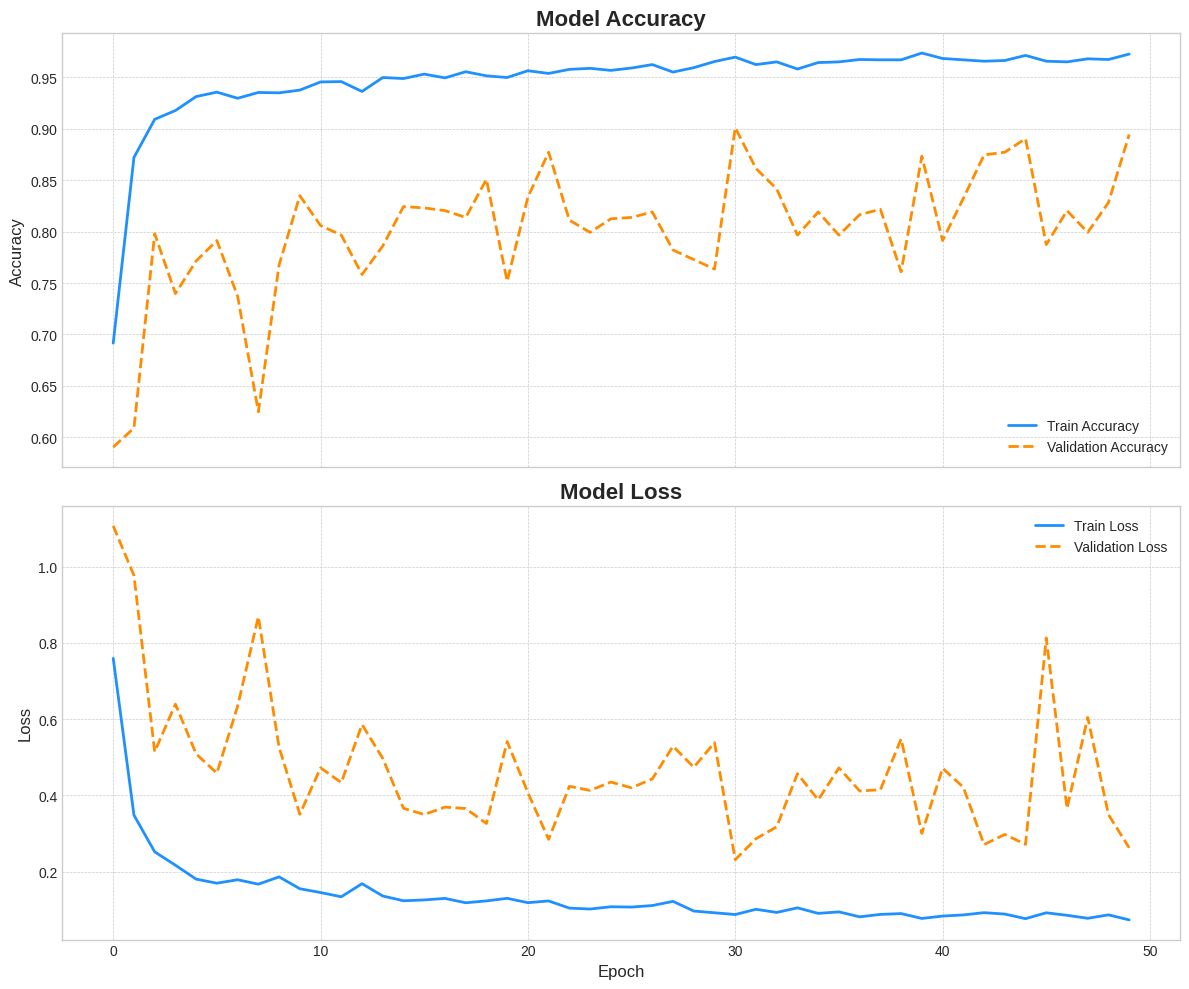

Plot displayed. You can now close the plot window.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
import matplotlib.pyplot as plt

# --- 1. Load and Prepare Data ---

try:
    # Load the features and target datasets
    features_df = pd.read_csv('/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_features_for_lstm.csv')
    target_df = pd.read_csv('/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_target_for_lstm.csv')

    # Convert 'Date' column to datetime objects
    features_df['Date'] = pd.to_datetime(features_df['Date'])
    target_df['Date'] = pd.to_datetime(target_df['Date'])

    # Merge the two dataframes on the 'Date' column
    df = pd.merge(features_df, target_df, on='Date')

    # Set 'Date' as the index
    df.set_index('Date', inplace=True)

    print("Data loaded and merged successfully.")
    print("DataFrame shape:", df.shape)
    print("Data head:\n", df.head())

except FileNotFoundError as e:
    print(f"Error: {e}. Please make sure 'chennai_features_for_lstm.csv' and 'chennai_target_for_lstm.csv' are in the same directory as the script.")
    exit()


# --- 2. Preprocess the Data ---

# Separate features (X) and target (y)
X = df.drop('Crisis_Target_V2', axis=1)
y = df['Crisis_Target_V2']

# The target variable is categorical (e.g., 1, 2, 3).
# Neural networks work best with 0-indexed targets.
# We subtract 1 to make it 0, 1, 2...
num_classes = len(y.unique())
print(f"\nNumber of unique crisis levels (classes): {num_classes}")
print(f"Unique target values before adjustment: {df['Crisis_Target_V2'].unique()}")
print(f"Unique target values after adjustment: {y.unique()}")


# Scale the features to be between 0 and 1. This is crucial for neural network performance.
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)

# --- 3. Create Time-Series Sequences ---

# This function converts our time series data into sequences of a specified
# length (time_step). The model will use a sequence of 'time_step' days
# to predict the crisis level on the following day.
def create_dataset(X, y, time_step=1):
    """
    Creates sequences of data for time-series forecasting.

    Args:
        X (np.array): Array of features.
        y (np.array): Array of target values.
        time_step (int): The number of previous time steps to use as input variables
                         to predict the next time period.

    Returns:
        tuple: A tuple containing the reshaped feature array (X) and the target array (y).
    """
    dataX, dataY = [], []
    for i in range(len(X) - time_step):
        # Take a sequence of 'time_step' features
        a = X[i:(i + time_step), :]
        dataX.append(a)
        # The target is the value at the end of the sequence
        dataY.append(y[i + time_step])
    return np.array(dataX), np.array(dataY)

# We will use the data from the last 60 days to predict the crisis on the 61st day.
time_step = 60
X_seq, y_seq = create_dataset(X_scaled, y.values, time_step)

print(f"\nData reshaped into sequences of {time_step} days.")
print("X_seq shape:", X_seq.shape)
print("y_seq shape:", y_seq.shape)


# --- 4. Split Data into Training and Testing Sets ---

# For time-series data, we should not shuffle the data. We split it chronologically.
# We'll use 80% of the data for training and 20% for testing.
train_size = int(len(X_seq) * 0.8)
test_size = len(X_seq) - train_size

X_train, X_test = X_seq[0:train_size], X_seq[train_size:len(X_seq)]
y_train, y_test = y_seq[0:train_size], y_seq[train_size:len(y_seq)]

print("\nData split into training and testing sets:")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


# --- 5. Build the LSTM Model ---

# We will build a stacked LSTM model with Dropout layers to prevent overfitting.
# This architecture is powerful for learning complex temporal patterns.
model = Sequential()

# Input layer specifies the shape of the input data
model.add(Input(shape=(time_step, X_train.shape[2])))

# First LSTM layer with 100 units. `return_sequences=True` is needed to
# pass the output of this layer as a sequence to the next layer.
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2)) # Dropout layer to prevent overfitting

# Second LSTM layer
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))

# Third LSTM layer. `return_sequences=False` as this is the last LSTM layer.
model.add(LSTM(50))
model.add(Dropout(0.2))

# A standard Dense layer for further processing
model.add(Dense(50, activation='relu'))

# The final output layer. The number of units equals the number of crisis classes.
# 'softmax' is used for multi-class classification.
model.add(Dense(num_classes, activation='softmax'))


# Compile the model
# 'adam' is an efficient optimizer.
# 'sparse_categorical_crossentropy' is used as the loss function for multi-class
# classification problems where the labels are integers.
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the model's architecture
model.summary()


# --- 6. Train the Model ---

print("\n--- Training the model ---")
# We train the model on the training data.
# `validation_data` is used to evaluate the model's performance on the test set after each epoch.
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=50, # An epoch is one complete pass through the entire training dataset.
    batch_size=64, # The number of samples to work through before updating the internal model parameters.
    verbose=1
)


# --- 7. Evaluate the Model ---

print("\n--- Evaluating the model ---")

# Make predictions on the test set
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1) # Get the class with the highest probability

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy on Test Data: {accuracy:.4f}")

# Display a detailed classification report
print("\nClassification Report:")
# We add 1 back to the labels to see them in their original format (1, 2, ...)
report = classification_report(y_test + 1, y_pred + 1)
print(report)


# --- 8. Plot Training History ---

print("\n--- Plotting training history ---")
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot training & validation accuracy values
ax1.plot(history.history['accuracy'], label='Train Accuracy', color='dodgerblue', linewidth=2)
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', color='darkorange', linestyle='--', linewidth=2)
ax1.set_title('Model Accuracy', fontsize=16, fontweight='bold')
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(loc='lower right')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot training & validation loss values
ax2.plot(history.history['loss'], label='Train Loss', color='dodgerblue', linewidth=2)
ax2.plot(history.history['val_loss'], label='Validation Loss', color='darkorange', linestyle='--', linewidth=2)
ax2.set_title('Model Loss', fontsize=16, fontweight='bold')
ax2.set_ylabel('Loss', fontsize=12)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.legend(loc='upper right')
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()
print("Plot displayed. You can now close the plot window.")


Data loaded and merged successfully.
DataFrame shape: (3842, 144)

--- Class Distribution Analysis ---
Number of unique crisis levels (classes): 4
Unique target values: [0 1 2 3]

Overall class distribution in the entire dataset:
Crisis_Target_V2
0    1295
1    1673
2     747
3     127
Name: count, dtype: int64

--- Starting 5-Fold Time-Series Cross-Validation ---

===== FOLD 1/5 =====
Class Weights for this fold: {0: np.float64(1.308488612836439), 1: np.float64(0.5346869712351946), 2: np.float64(2.735930735930736)}
Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 467ms/step - accuracy: 0.3590 - loss: 1.2658 - val_accuracy: 0.5429 - val_loss: 1.0717
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 507ms/step - accuracy: 0.6596 - loss: 0.5958 - val_accuracy: 0.7222 - val_loss: 1.1266
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 386ms/step - accuracy: 0.7574 - loss: 0.3914 - val_accuracy: 0.6476 - val_loss: 1.3155
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 576ms/step - accuracy: 0.8447 - loss: 0.2898 - v

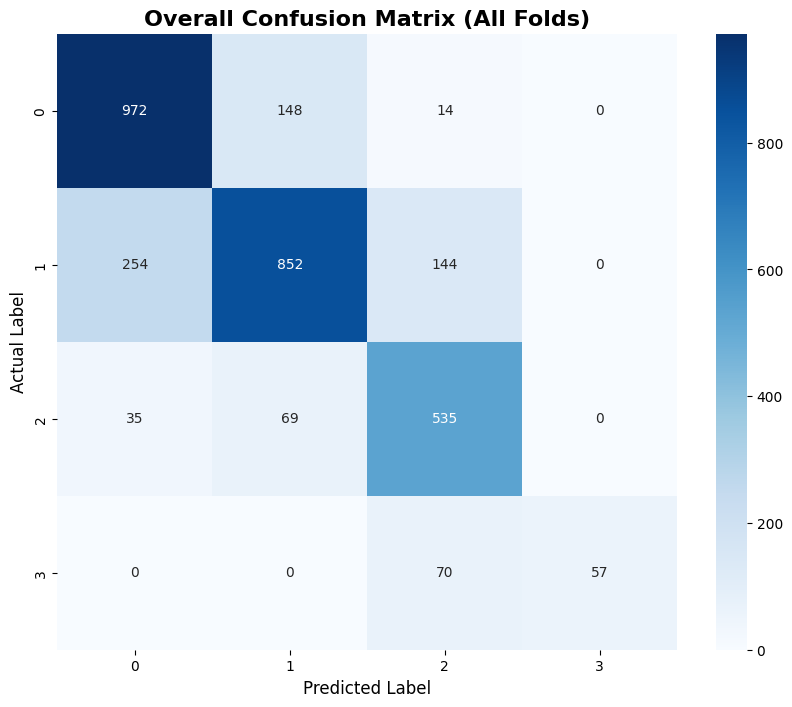

Confusion Matrix plot displayed.


--- Training Final Model on All Data for Prediction ---
Final Class Weights: {0: np.float64(0.7301158301158301), 1: np.float64(0.5751216545012166), 2: np.float64(1.3205307262569832), 3: np.float64(7.44488188976378)}
Epoch 1/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 25s 322ms/step - accuracy: 0.5808 - loss: 0.9953
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 312ms/step - accuracy: 0.8313 - loss: 0.3909
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 312ms/step - accuracy: 0.8126 - loss: 0.3648
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 309ms/step - accuracy: 0.8586 - loss: 0.3657
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 21s 324ms/step - accuracy: 0.8839 - loss: 0.2587
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 19s 305ms/step - accuracy: 0.8472 - loss: 0.2963
Epoch 7/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 22s 327ms/step - accuracy: 0.8964 - loss: 0.2045
Epoch 8/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 19s 307ms/step - accuracy: 0.9162 - loss: 0.1746
Epoch 9/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 309ms/step 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import TimeSeriesSplit
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load and Prepare Data ---

try:
    # Load the features and target datasets
    features_df = pd.read_csv('/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_features_for_lstm.csv')
    target_df = pd.read_csv('/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_target_for_lstm.csv')

    # Convert 'Date' column to datetime objects
    features_df['Date'] = pd.to_datetime(features_df['Date'])
    target_df['Date'] = pd.to_datetime(target_df['Date'])

    # Merge the two dataframes on the 'Date' column
    df = pd.merge(features_df, target_df, on='Date')

    # Set 'Date' as the index
    df.set_index('Date', inplace=True)

    print("Data loaded and merged successfully.")
    print("DataFrame shape:", df.shape)

except FileNotFoundError as e:
    print(f"Error: {e}. Please make sure 'chennai_features_for_lstm.csv' and 'chennai_target_for_lstm.csv' are in the same directory as the script.")
    exit()


# --- 2. Preprocess the Data ---

# Separate features (X) and target (y)
X_df = df.drop('Crisis_Target_V2', axis=1)
y_df = df['Crisis_Target_V2']

# --- Diagnostic: Check Class Distribution ---
print("\n--- Class Distribution Analysis ---")
num_classes = len(y_df.unique())
print(f"Number of unique crisis levels (classes): {num_classes}")
print(f"Unique target values: {np.sort(y_df.unique())}")
print("\nOverall class distribution in the entire dataset:")
print(y_df.value_counts().sort_index())

# Validate that labels are in the correct range [0, num_classes-1]
if y_df.min() < 0:
    print(f"Error: Negative label found ({y_df.min()}). Labels must be non-negative.")
    exit()


# Scale the features to be between 0 and 1.
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X_df)

# --- 3. Create Time-Series Sequences ---
def create_dataset(X, y, time_step=1):
    dataX, dataY = [], []
    for i in range(len(X) - time_step):
        a = X[i:(i + time_step), :]
        dataX.append(a)
        dataY.append(y[i + time_step])
    return np.array(dataX), np.array(dataY)

time_step = 60
X_seq, y_seq = create_dataset(X_scaled, y_df.values, time_step)


# --- 4. Build and Train the Model with Cross-Validation ---

# Use TimeSeriesSplit for robust cross-validation on time-series data.
# This creates multiple train/test splits, ensuring the model is evaluated
# across different time periods and preventing data leakage.
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Store scores and histories from each fold
fold_accuracies = []
all_y_test = []
all_y_pred = []

print(f"\n--- Starting {n_splits}-Fold Time-Series Cross-Validation ---")

for fold, (train_index, test_index) in enumerate(tscv.split(X_seq)):
    print(f"\n===== FOLD {fold + 1}/{n_splits} =====")
    X_train, X_test = X_seq[train_index], X_seq[test_index]
    y_train, y_test = y_seq[train_index], y_seq[test_index]

    # --- Handle Class Imbalance with Class Weights ---
    # This is crucial for forcing the model to pay attention to rare classes.
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weights_dict = dict(enumerate(class_weights))
    print("Class Weights for this fold:", class_weights_dict)

    # --- Build the LSTM Model ---
    # We rebuild the model in each fold to ensure it starts fresh.
    model = Sequential([
        Input(shape=(time_step, X_train.shape[2])),
        LSTM(100, return_sequences=True),
        Dropout(0.3),
        LSTM(100, return_sequences=True),
        Dropout(0.3),
        LSTM(50),
        Dropout(0.3),
        Dense(50, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # --- Use Early Stopping to Prevent Overfitting ---
    # This stops training when the validation loss stops improving.
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10, # Number of epochs with no improvement to wait before stopping
        verbose=1,
        restore_best_weights=True # Restores model weights from the epoch with the best val_loss
    )

    # --- Train the Model ---
    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_test, y_test),
        epochs=100, # Set a high number of epochs; EarlyStopping will find the optimal number
        batch_size=64,
        class_weight=class_weights_dict,
        callbacks=[early_stopping],
        verbose=1
    )

    # --- Evaluate on the test fold ---
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)

    fold_accuracy = accuracy_score(y_test, y_pred)
    fold_accuracies.append(fold_accuracy)
    print(f"Accuracy for Fold {fold + 1}: {fold_accuracy:.4f}")

    # Store results for final evaluation
    all_y_test.extend(y_test)
    all_y_pred.extend(y_pred)


# --- 5. Final Model Evaluation ---
print("\n\n--- Overall Model Performance (Across All Folds) ---")
print(f"Average Cross-Validation Accuracy: {np.mean(fold_accuracies):.4f} (+/- {np.std(fold_accuracies):.4f})")

# --- Overall Classification Report ---
print("\nOverall Classification Report:")
# Specify all possible labels to ensure the report includes them all.
report = classification_report(all_y_test, all_y_pred, labels=np.sort(y_df.unique()), zero_division=0)
print(report)

# --- Overall Confusion Matrix ---
print("\n--- Plotting Overall Confusion Matrix ---")
cm = confusion_matrix(all_y_test, all_y_pred, labels=np.sort(y_df.unique()))
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.sort(y_df.unique()),
            yticklabels=np.sort(y_df.unique()))
plt.title('Overall Confusion Matrix (All Folds)', fontsize=16, fontweight='bold')
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()
print("Confusion Matrix plot displayed.")


Data loaded and merged successfully.
DataFrame shape: (3842, 144)

--- Class Distribution Analysis ---
Number of unique crisis levels (classes): 4
Unique target values: [0 1 2 3]

Overall class distribution in the entire dataset:
Crisis_Target_V2
0    1295
1    1673
2     747
3     127
Name: count, dtype: int64

--- Starting 5-Fold Time-Series Cross-Validation ---

===== FOLD 1/5 =====
Class Weights for this fold: {0: np.float64(1.2901234567901234), 1: np.float64(0.5147783251231527), 2: np.float64(3.542372881355932)}
Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 980ms/step - accuracy: 0.4975 - loss: 1.0924 - val_accuracy: 0.4336 - val_loss: 1.2068
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6990 - loss: 0.5279 - val_accuracy: 0.4912 - val_loss: 1.6545
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 693ms/step - accuracy: 0.6860 - loss: 0.4636 - val_accuracy: 0.6240 - val_loss: 1.3677
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 800ms/step - accuracy: 0.8908 - loss: 0.2922 - v

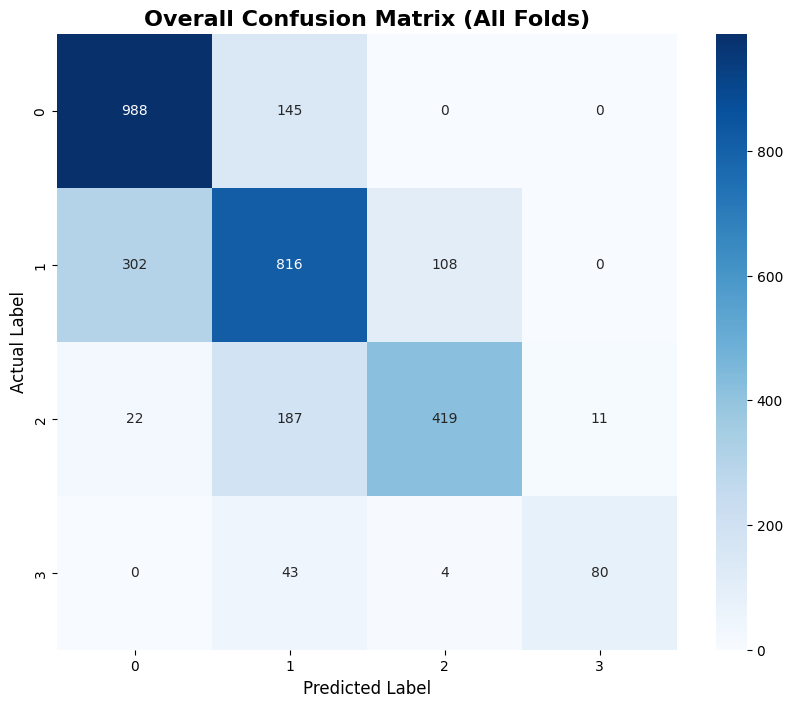

Confusion Matrix plot displayed.


--- Training Final Model on All Data for Prediction ---
Final Class Weights: {0: np.float64(0.7243243243243244), 1: np.float64(0.5747549019607843), 2: np.float64(1.343839541547278), 3: np.float64(7.3858267716535435)}
Epoch 1/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 45s 641ms/step - accuracy: 0.5663 - loss: 0.9301
Epoch 2/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 37s 583ms/step - accuracy: 0.8420 - loss: 0.3709
Epoch 3/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 41s 585ms/step - accuracy: 0.8618 - loss: 0.3049
Epoch 4/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 41s 583ms/step - accuracy: 0.8876 - loss: 0.2286
Epoch 5/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 35s 592ms/step - accuracy: 0.8987 - loss: 0.2042
Epoch 6/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 41s 600ms/step - accuracy: 0.8953 - loss: 0.2146
Epoch 7/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 41s 608ms/step - accuracy: 0.9187 - loss: 0.1747
Epoch 8/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 34s 577ms/step - accuracy: 0.9163 - loss: 0.1676
Epoch 9/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 41s 579ms/step

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import TimeSeriesSplit
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load and Prepare Data ---

try:
    # Load the features and target datasets
    features_df = pd.read_csv('/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_features_for_lstm.csv')
    target_df = pd.read_csv('/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_target_for_lstm.csv')

    # Convert 'Date' column to datetime objects
    features_df['Date'] = pd.to_datetime(features_df['Date'])
    target_df['Date'] = pd.to_datetime(target_df['Date'])

    # Merge the two dataframes on the 'Date' column
    df = pd.merge(features_df, target_df, on='Date')

    # Set 'Date' as the index
    df.set_index('Date', inplace=True)

    print("Data loaded and merged successfully.")
    print("DataFrame shape:", df.shape)

except FileNotFoundError as e:
    print(f"Error: {e}. Please make sure 'chennai_features_for_lstm.csv' and 'chennai_target_for_lstm.csv' are in the same directory as the script.")
    exit()


# --- 2. Preprocess the Data ---

# Separate features (X) and target (y)
X_df = df.drop('Crisis_Target_V2', axis=1)
y_df = df['Crisis_Target_V2']

# --- Diagnostic: Check Class Distribution ---
print("\n--- Class Distribution Analysis ---")
num_classes = len(y_df.unique())
print(f"Number of unique crisis levels (classes): {num_classes}")
print(f"Unique target values: {np.sort(y_df.unique())}")
print("\nOverall class distribution in the entire dataset:")
print(y_df.value_counts().sort_index())

# Validate that labels are in the correct range [0, num_classes-1]
if y_df.min() < 0:
    print(f"Error: Negative label found ({y_df.min()}). Labels must be non-negative.")
    exit()


# Scale the features to be between 0 and 1.
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X_df)

# --- 3. Create Time-Series Sequences ---
def create_dataset(X, y, time_step=1):
    dataX, dataY = [], []
    for i in range(len(X) - time_step):
        a = X[i:(i + time_step), :]
        dataX.append(a)
        dataY.append(y[i + time_step])
    return np.array(dataX), np.array(dataY)

# **TUNED HYPERPARAMETER**: Changed time_step to 90
time_step = 90
X_seq, y_seq = create_dataset(X_scaled, y_df.values, time_step)


# --- 4. Build and Train the Model with Cross-Validation ---

# Use TimeSeriesSplit for robust cross-validation on time-series data.
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Store scores and histories from each fold
fold_accuracies = []
all_y_test = []
all_y_pred = []

print(f"\n--- Starting {n_splits}-Fold Time-Series Cross-Validation ---")

for fold, (train_index, test_index) in enumerate(tscv.split(X_seq)):
    print(f"\n===== FOLD {fold + 1}/{n_splits} =====")
    X_train, X_test = X_seq[train_index], X_seq[test_index]
    y_train, y_test = y_seq[train_index], y_seq[test_index]

    # --- Handle Class Imbalance with Class Weights ---
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weights_dict = dict(enumerate(class_weights))
    print("Class Weights for this fold:", class_weights_dict)

    # --- Build the LSTM Model ---
    # **TUNED HYPERPARAMETERS**: Increased LSTM units and adjusted Dropout.
    model = Sequential([
        Input(shape=(time_step, X_train.shape[2])),
        LSTM(150, return_sequences=True), # Increased units
        Dropout(0.2), # Adjusted dropout
        LSTM(150, return_sequences=True), # Increased units
        Dropout(0.2), # Adjusted dropout
        LSTM(64),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # --- Use Early Stopping to Prevent Overfitting ---
    # **TUNED HYPERPARAMETER**: Increased patience
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=20,
        verbose=1,
        restore_best_weights=True
    )

    # --- Train the Model ---
    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_test, y_test),
        epochs=100,
        batch_size=64,
        class_weight=class_weights_dict,
        callbacks=[early_stopping],
        verbose=1
    )

    # --- Evaluate on the test fold ---
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)

    fold_accuracy = accuracy_score(y_test, y_pred)
    fold_accuracies.append(fold_accuracy)
    print(f"Accuracy for Fold {fold + 1}: {fold_accuracy:.4f}")

    # Store results for final evaluation
    all_y_test.extend(y_test)
    all_y_pred.extend(y_pred)


# --- 5. Final Model Evaluation ---
print("\n\n--- Overall Model Performance (Across All Folds) ---")
print(f"Average Cross-Validation Accuracy: {np.mean(fold_accuracies):.4f} (+/- {np.std(fold_accuracies):.4f})")

# --- Overall Classification Report ---
print("\nOverall Classification Report:")
report = classification_report(all_y_test, all_y_pred, labels=np.sort(y_df.unique()), zero_division=0)
print(report)

# --- Overall Confusion Matrix ---
print("\n--- Plotting Overall Confusion Matrix ---")
cm = confusion_matrix(all_y_test, all_y_pred, labels=np.sort(y_df.unique()))
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.sort(y_df.unique()),
            yticklabels=np.sort(y_df.unique()))
plt.title('Overall Confusion Matrix (All Folds)', fontsize=16, fontweight='bold')
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()
print("Confusion Matrix plot displayed.")


# --- 6. Train Final Model and Make Prediction for Tomorrow ---

print("\n\n--- Training Final Model on All Data for Prediction ---")

# --- Handle Class Imbalance for the full dataset ---
final_class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_seq),
    y=y_seq
)
final_class_weights_dict = dict(enumerate(final_class_weights))
print("Final Class Weights:", final_class_weights_dict)

# --- Build the final model with tuned hyperparameters ---
final_model = Sequential([
    Input(shape=(time_step, X_seq.shape[2])),
    LSTM(150, return_sequences=True), # Increased units
    Dropout(0.2), # Adjusted dropout
    LSTM(150, return_sequences=True), # Increased units
    Dropout(0.2), # Adjusted dropout
    LSTM(64),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])
final_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# --- Train the final model on the entire dataset ---
final_model.fit(
    X_seq,
    y_seq,
    epochs=30, # A reasonable number of epochs based on previous runs
    batch_size=64,
    class_weight=final_class_weights_dict,
    verbose=1
)

# --- Prepare the last 90 days of data for prediction ---
last_days = X_scaled[-time_step:]
prediction_input = last_days.reshape(1, time_step, X_df.shape[1])

# --- Make the prediction ---
prediction_probs = final_model.predict(prediction_input)
predicted_class = np.argmax(prediction_probs, axis=1)[0]

# --- Display the prediction ---
last_date_in_data = X_df.index[-1]
prediction_date = last_date_in_data + pd.Timedelta(days=1)

print("\n\n=====================================================")
print(f"      PREDICTION FOR CHENNAI WATER CRISIS")
print("=====================================================")
print(f"Based on data up to: {last_date_in_data.strftime('%Y-%m-%d')}")
print(f"Predicted Crisis Level for {prediction_date.strftime('%Y-%m-%d')}: {predicted_class}")
print("=====================================================")
print("\nCrisis Levels:")
print("0: No Crisis")
print("1: Moderate Crisis")
print("2: Severe Crisis")
print("3: Extreme Crisis")



## Bidirectional LSTM

Data loaded and merged successfully.
DataFrame shape: (3842, 144)

--- Class Distribution Analysis ---
Number of unique crisis levels (classes): 4
Unique target values: [0 1 2 3]

Overall class distribution in the entire dataset:
Crisis_Target_V2
0    1295
1    1673
2     747
3     127
Name: count, dtype: int64

--- Starting 5-Fold Time-Series Cross-Validation ---

===== FOLD 1/5 =====
Class Weights for this fold: {0: np.float64(1.2901234567901234), 1: np.float64(0.5147783251231527), 2: np.float64(3.542372881355932)}
Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.4625 - loss: 0.9689 - val_accuracy: 0.4160 - val_loss: 1.3772
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.8335 - loss: 0.2602 - val_accuracy: 0.6064 - val_loss: 1.3331
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.9456 - loss: 0.1094 - val_accuracy: 0.5312 - val_loss: 1.7615
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.9516 - loss: 0.0908 - val_accur

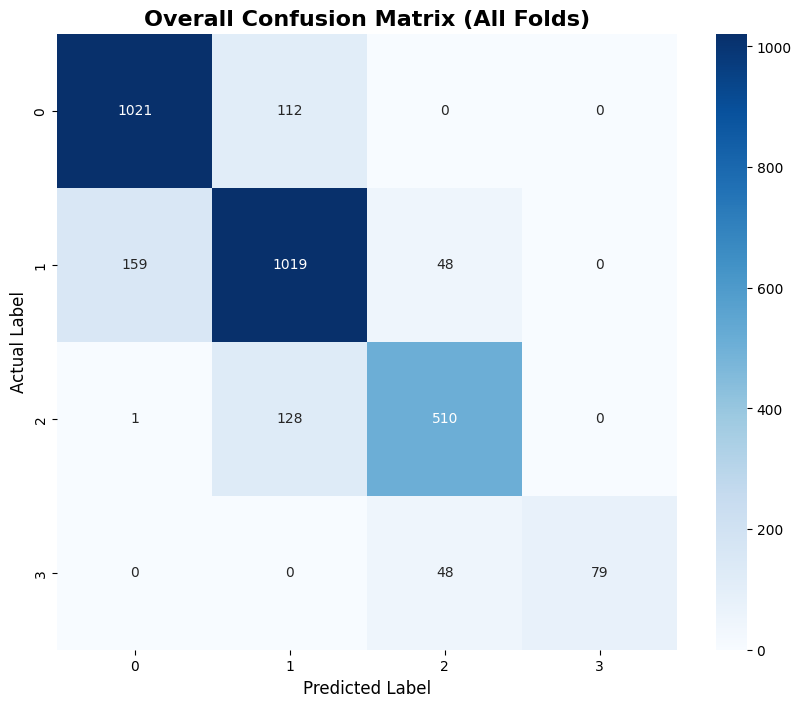

Confusion Matrix plot displayed.


--- Training Final Model on All Data for Prediction ---
Final Class Weights: {0: np.float64(0.7243243243243244), 1: np.float64(0.5747549019607843), 2: np.float64(1.343839541547278), 3: np.float64(7.3858267716535435)}
Epoch 1/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.5810 - loss: 0.8450
Epoch 2/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8314 - loss: 0.3317
Epoch 3/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.9092 - loss: 0.2051
Epoch 4/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.9191 - loss: 0.1766
Epoch 5/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.9204 - loss: 0.1514
Epoch 6/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.9267 - loss: 0.1499
Epoch 7/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9384 - loss: 0.1172
Epoch 8/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.9217 - loss: 0.1818
Epoch 9/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9425 - loss:

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import TimeSeriesSplit
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load and Prepare Data ---

try:
    # Load the features and target datasets
    features_df = pd.read_csv('/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_features_for_lstm.csv')
    target_df = pd.read_csv('/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_target_for_lstm.csv')

    # Convert 'Date' column to datetime objects
    features_df['Date'] = pd.to_datetime(features_df['Date'])
    target_df['Date'] = pd.to_datetime(target_df['Date'])

    # Merge the two dataframes on the 'Date' column
    df = pd.merge(features_df, target_df, on='Date')

    # Set 'Date' as the index
    df.set_index('Date', inplace=True)

    print("Data loaded and merged successfully.")
    print("DataFrame shape:", df.shape)

except FileNotFoundError as e:
    print(f"Error: {e}. Please make sure 'chennai_features_for_lstm.csv' and 'chennai_target_for_lstm.csv' are in the same directory as the script.")
    exit()


# --- 2. Preprocess the Data ---

# Separate features (X) and target (y)
X_df = df.drop('Crisis_Target_V2', axis=1)
y_df = df['Crisis_Target_V2']

# --- Diagnostic: Check Class Distribution ---
print("\n--- Class Distribution Analysis ---")
num_classes = len(y_df.unique())
print(f"Number of unique crisis levels (classes): {num_classes}")
print(f"Unique target values: {np.sort(y_df.unique())}")
print("\nOverall class distribution in the entire dataset:")
print(y_df.value_counts().sort_index())

# Validate that labels are in the correct range [0, num_classes-1]
if y_df.min() < 0:
    print(f"Error: Negative label found ({y_df.min()}). Labels must be non-negative.")
    exit()


# Scale the features to be between 0 and 1.
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X_df)

# --- 3. Create Time-Series Sequences ---
def create_dataset(X, y, time_step=1):
    dataX, dataY = [], []
    for i in range(len(X) - time_step):
        a = X[i:(i + time_step), :]
        dataX.append(a)
        dataY.append(y[i + time_step])
    return np.array(dataX), np.array(dataY)

# **TUNED HYPERPARAMETER**: Changed time_step to 90
time_step = 90
X_seq, y_seq = create_dataset(X_scaled, y_df.values, time_step)


# --- 4. Build and Train the Model with Cross-Validation ---

# Use TimeSeriesSplit for robust cross-validation on time-series data.
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Store scores and histories from each fold
fold_accuracies = []
all_y_test = []
all_y_pred = []

print(f"\n--- Starting {n_splits}-Fold Time-Series Cross-Validation ---")

for fold, (train_index, test_index) in enumerate(tscv.split(X_seq)):
    print(f"\n===== FOLD {fold + 1}/{n_splits} =====")
    X_train, X_test = X_seq[train_index], X_seq[test_index]
    y_train, y_test = y_seq[train_index], y_seq[test_index]

    # --- Handle Class Imbalance with Class Weights ---
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weights_dict = dict(enumerate(class_weights))
    print("Class Weights for this fold:", class_weights_dict)

    # --- Build the Bidirectional LSTM Model ---
    # This architecture can capture patterns from both past-to-future and future-to-past.
    model = Sequential([
        Input(shape=(time_step, X_train.shape[2])),
        Bidirectional(LSTM(150, return_sequences=True)), # Using Bidirectional wrapper
        Dropout(0.2),
        Bidirectional(LSTM(150, return_sequences=True)), # Using Bidirectional wrapper
        Dropout(0.2),
        Bidirectional(LSTM(64)), # Using Bidirectional wrapper
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # --- Use Early Stopping to Prevent Overfitting ---
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=20,
        verbose=1,
        restore_best_weights=True
    )

    # --- Train the Model ---
    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_test, y_test),
        epochs=100,
        batch_size=64,
        class_weight=class_weights_dict,
        callbacks=[early_stopping],
        verbose=1
    )

    # --- Evaluate on the test fold ---
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)

    fold_accuracy = accuracy_score(y_test, y_pred)
    fold_accuracies.append(fold_accuracy)
    print(f"Accuracy for Fold {fold + 1}: {fold_accuracy:.4f}")

    # Store results for final evaluation
    all_y_test.extend(y_test)
    all_y_pred.extend(y_pred)


# --- 5. Final Model Evaluation ---
print("\n\n--- Overall Model Performance (Across All Folds) ---")
print(f"Average Cross-Validation Accuracy: {np.mean(fold_accuracies):.4f} (+/- {np.std(fold_accuracies):.4f})")

# --- Overall Classification Report ---
print("\nOverall Classification Report:")
report = classification_report(all_y_test, all_y_pred, labels=np.sort(y_df.unique()), zero_division=0)
print(report)

# --- Overall Confusion Matrix ---
print("\n--- Plotting Overall Confusion Matrix ---")
cm = confusion_matrix(all_y_test, all_y_pred, labels=np.sort(y_df.unique()))
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.sort(y_df.unique()),
            yticklabels=np.sort(y_df.unique()))
plt.title('Overall Confusion Matrix (All Folds)', fontsize=16, fontweight='bold')
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()
print("Confusion Matrix plot displayed.")


# --- 6. Train Final Model and Make Prediction for Tomorrow ---

print("\n\n--- Training Final Model on All Data for Prediction ---")

# --- Handle Class Imbalance for the full dataset ---
final_class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_seq),
    y=y_seq
)
final_class_weights_dict = dict(enumerate(final_class_weights))
print("Final Class Weights:", final_class_weights_dict)

# --- Build the final model with Bidirectional LSTMs ---
final_model = Sequential([
    Input(shape=(time_step, X_seq.shape[2])),
    Bidirectional(LSTM(150, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(150, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(64)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])
final_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# --- Train the final model on the entire dataset ---
final_model.fit(
    X_seq,
    y_seq,
    epochs=30, # A reasonable number of epochs based on previous runs
    batch_size=64,
    class_weight=final_class_weights_dict,
    verbose=1
)

# --- Prepare the last 90 days of data for prediction ---
last_days = X_scaled[-time_step:]
prediction_input = last_days.reshape(1, time_step, X_df.shape[1])

# --- Make the prediction ---
prediction_probs = final_model.predict(prediction_input)
predicted_class = np.argmax(prediction_probs, axis=1)[0]

# --- Display the prediction ---
last_date_in_data = X_df.index[-1]
prediction_date = last_date_in_data + pd.Timedelta(days=1)

print("\n\n=====================================================")
print(f"      PREDICTION FOR CHENNAI WATER CRISIS")
print("=====================================================")
print(f"Based on data up to: {last_date_in_data.strftime('%Y-%m-%d')}")
print(f"Predicted Crisis Level for {prediction_date.strftime('%Y-%m-%d')}: {predicted_class}")
print("=====================================================")
print("\nCrisis Levels:")
print("0: No Crisis")
print("1: Moderate Crisis")
print("2: Severe Crisis")
print("3: Extreme Crisis")



## Attention Mechanism

Data loaded and merged successfully.
DataFrame shape: (3842, 144)

--- Class Distribution Analysis ---
Number of unique crisis levels (classes): 4
Unique target values: [0 1 2 3]

Overall class distribution in the entire dataset:
Crisis_Target_V2
0    1295
1    1673
2     747
3     127
Name: count, dtype: int64

--- Starting 5-Fold Time-Series Cross-Validation ---

===== FOLD 1/5 =====
Class Weights for this fold: {0: np.float64(1.2901234567901234), 1: np.float64(0.5147783251231527), 2: np.float64(3.542372881355932)}
Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.4104 - loss: 1.0101 - val_accuracy: 0.3888 - val_loss: 1.4661
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6823 - loss: 0.5156 - val_accuracy: 0.4944 - val_loss: 2.3762
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.9056 - loss: 0.1984 - val_accuracy: 0.4992 - val_loss: 3.0914
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.9497 - loss: 0.1114 - val_accur

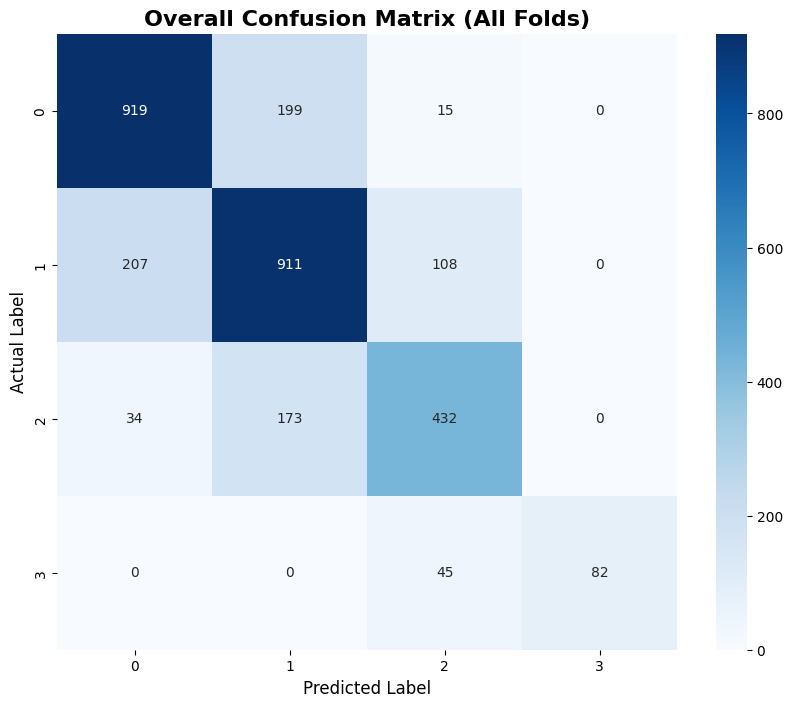

Confusion Matrix plot displayed.


--- Training Final Model on All Data for Prediction ---
Final Class Weights: {0: np.float64(0.7243243243243244), 1: np.float64(0.5747549019607843), 2: np.float64(1.343839541547278), 3: np.float64(7.3858267716535435)}
Epoch 1/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.5402 - loss: 0.8491
Epoch 2/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.8272 - loss: 0.3490
Epoch 3/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.8749 - loss: 0.2826
Epoch 4/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.8943 - loss: 0.2330
Epoch 5/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.9115 - loss: 0.2307
Epoch 6/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.9183 - loss: 0.1792
Epoch 7/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9084 - loss: 0.1792
Epoch 8/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.9204 - loss: 0.1921
Epoch 9/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.9429 - loss:

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import TimeSeriesSplit
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Bidirectional, Layer
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

# --- Custom Attention Layer ---
# This layer allows the model to focus on the most important parts of the input sequence.
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros")
        super(Attention, self).build(input_shape)

    def call(self, x):
        et = K.squeeze(K.tanh(K.dot(x, self.W) + self.b), axis=-1)
        at = K.softmax(et)
        at = K.expand_dims(at, axis=-1)
        output = x * at
        return K.sum(output, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

    def get_config(self):
        return super(Attention, self).get_config()


# --- 1. Load and Prepare Data ---

try:
    # Load the features and target datasets
    features_df = pd.read_csv('/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_features_for_lstm.csv')
    target_df = pd.read_csv('/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_target_for_lstm.csv')

    # Convert 'Date' column to datetime objects
    features_df['Date'] = pd.to_datetime(features_df['Date'])
    target_df['Date'] = pd.to_datetime(target_df['Date'])

    # Merge the two dataframes on the 'Date' column
    df = pd.merge(features_df, target_df, on='Date')

    # Set 'Date' as the index
    df.set_index('Date', inplace=True)

    print("Data loaded and merged successfully.")
    print("DataFrame shape:", df.shape)

except FileNotFoundError as e:
    print(f"Error: {e}. Please make sure 'chennai_features_for_lstm.csv' and 'chennai_target_for_lstm.csv' are in the same directory as the script.")
    exit()


# --- 2. Preprocess the Data ---

# Separate features (X) and target (y)
X_df = df.drop('Crisis_Target_V2', axis=1)
y_df = df['Crisis_Target_V2']

# --- Diagnostic: Check Class Distribution ---
print("\n--- Class Distribution Analysis ---")
num_classes = len(y_df.unique())
print(f"Number of unique crisis levels (classes): {num_classes}")
print(f"Unique target values: {np.sort(y_df.unique())}")
print("\nOverall class distribution in the entire dataset:")
print(y_df.value_counts().sort_index())

# Validate that labels are in the correct range [0, num_classes-1]
if y_df.min() < 0:
    print(f"Error: Negative label found ({y_df.min()}). Labels must be non-negative.")
    exit()


# Scale the features to be between 0 and 1.
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X_df)

# --- 3. Create Time-Series Sequences ---
def create_dataset(X, y, time_step=1):
    dataX, dataY = [], []
    for i in range(len(X) - time_step):
        a = X[i:(i + time_step), :]
        dataX.append(a)
        dataY.append(y[i + time_step])
    return np.array(dataX), np.array(dataY)

time_step = 90
X_seq, y_seq = create_dataset(X_scaled, y_df.values, time_step)


# --- 4. Build and Train the Model with Cross-Validation ---

n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

fold_accuracies = []
all_y_test = []
all_y_pred = []

print(f"\n--- Starting {n_splits}-Fold Time-Series Cross-Validation ---")

for fold, (train_index, test_index) in enumerate(tscv.split(X_seq)):
    print(f"\n===== FOLD {fold + 1}/{n_splits} =====")
    X_train, X_test = X_seq[train_index], X_seq[test_index]
    y_train, y_test = y_seq[train_index], y_seq[test_index]

    # --- Handle Class Imbalance with Class Weights ---
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weights_dict = dict(enumerate(class_weights))
    print("Class Weights for this fold:", class_weights_dict)

    # --- Build the Bidirectional LSTM Model with Attention ---
    model = Sequential([
        Input(shape=(time_step, X_train.shape[2])),
        Bidirectional(LSTM(150, return_sequences=True)),
        Dropout(0.2),
        Bidirectional(LSTM(150, return_sequences=True)),
        Dropout(0.2),
        Attention(), # Applying the custom Attention layer
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # --- Use Early Stopping to Prevent Overfitting ---
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=20,
        verbose=1,
        restore_best_weights=True
    )

    # --- Train the Model ---
    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_test, y_test),
        epochs=100,
        batch_size=64,
        class_weight=class_weights_dict,
        callbacks=[early_stopping],
        verbose=1
    )

    # --- Evaluate on the test fold ---
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)

    fold_accuracy = accuracy_score(y_test, y_pred)
    fold_accuracies.append(fold_accuracy)
    print(f"Accuracy for Fold {fold + 1}: {fold_accuracy:.4f}")

    # Store results for final evaluation
    all_y_test.extend(y_test)
    all_y_pred.extend(y_pred)


# --- 5. Final Model Evaluation ---
print("\n\n--- Overall Model Performance (Across All Folds) ---")
print(f"Average Cross-Validation Accuracy: {np.mean(fold_accuracies):.4f} (+/- {np.std(fold_accuracies):.4f})")

# --- Overall Classification Report ---
print("\nOverall Classification Report:")
report = classification_report(all_y_test, all_y_pred, labels=np.sort(y_df.unique()), zero_division=0)
print(report)

# --- Overall Confusion Matrix ---
print("\n--- Plotting Overall Confusion Matrix ---")
cm = confusion_matrix(all_y_test, all_y_pred, labels=np.sort(y_df.unique()))
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.sort(y_df.unique()),
            yticklabels=np.sort(y_df.unique()))
plt.title('Overall Confusion Matrix (All Folds)', fontsize=16, fontweight='bold')
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()
print("Confusion Matrix plot displayed.")


# --- 6. Train Final Model and Make Prediction for Tomorrow ---

print("\n\n--- Training Final Model on All Data for Prediction ---")

# --- Handle Class Imbalance for the full dataset ---
final_class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_seq),
    y=y_seq
)
final_class_weights_dict = dict(enumerate(final_class_weights))
print("Final Class Weights:", final_class_weights_dict)

# --- Build the final model with Bidirectional LSTMs and Attention ---
final_model = Sequential([
    Input(shape=(time_step, X_seq.shape[2])),
    Bidirectional(LSTM(150, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(150, return_sequences=True)),
    Dropout(0.2),
    Attention(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])
final_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# --- Train the final model on the entire dataset ---
final_model.fit(
    X_seq,
    y_seq,
    epochs=30,
    batch_size=64,
    class_weight=final_class_weights_dict,
    verbose=1
)

# --- Prepare the last 90 days of data for prediction ---
last_days = X_scaled[-time_step:]
prediction_input = last_days.reshape(1, time_step, X_df.shape[1])

# --- Make the prediction ---
prediction_probs = final_model.predict(prediction_input)
predicted_class = np.argmax(prediction_probs, axis=1)[0]

# --- Display the prediction ---
last_date_in_data = X_df.index[-1]
prediction_date = last_date_in_data + pd.Timedelta(days=1)

print("\n\n=====================================================")
print(f"      PREDICTION FOR CHENNAI WATER CRISIS")
print("=====================================================")
print(f"Based on data up to: {last_date_in_data.strftime('%Y-%m-%d')}")
print(f"Predicted Crisis Level for {prediction_date.strftime('%Y-%m-%d')}: {predicted_class}")
print("=====================================================")
print("\nCrisis Levels:")
print("0: No Crisis")
print("1: Moderate Crisis")
print("2: Severe Crisis")
print("3: Extreme Crisis")



Data loaded and merged successfully.
DataFrame shape: (3842, 144)

--- Class Distribution Analysis ---
Number of unique crisis levels (classes): 4
Unique target values: [0 1 2 3]

Overall class distribution in the entire dataset:
Crisis_Target_V2
0    1295
1    1673
2     747
3     127
Name: count, dtype: int64

--- Starting 5-Fold Time-Series Cross-Validation with Ensemble Model ---

===== FOLD 1/5 =====
Class Weights for this fold: {0: np.float64(1.2901234567901234), 1: np.float64(0.5147783251231527), 2: np.float64(3.542372881355932)}

--- Training Bidirectional LSTM ---
Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.3869 - loss: 1.0200 - val_accuracy: 0.4256 - val_loss: 1.5867
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.8508 - loss: 0.2623 - val_accuracy: 0.5664 - val_loss: 1.7399
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.9200 - loss: 0.1750 - val_accuracy: 0.5552 - val_loss: 2.1679
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [13:13:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Ensemble Accuracy for Fold 1: 0.6224

===== FOLD 2/5 =====
Class Weights for this fold: {0: np.float64(1.2620967741935485), 1: np.float64(0.45894428152492667), 2: np.float64(1.1258992805755397), 3: np.float64(7.113636363636363)}

--- Training Bidirectional LSTM ---
Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.4788 - loss: 1.0948 - val_accuracy: 0.6800 - val_loss: 0.6592
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8981 - loss: 0.2767 - val_accuracy: 0.8976 - val_loss: 0.3241
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.9344 - loss: 0.1740 - val_accuracy: 0.9152 - val_loss: 0.2592
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.9458 - loss: 0.1227 - val_accuracy: 0.9296 - val_loss: 0.2410
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9188 - loss: 0.2011 - val_accuracy: 0.8160 - val_loss: 0.5261
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9334 - loss: 0.1368 - val_accurac

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [13:41:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Ensemble Accuracy for Fold 2: 0.9264

===== FOLD 3/5 =====
Class Weights for this fold: {0: np.float64(1.2751358695652173), 1: np.float64(0.49239244491080797), 2: np.float64(1.093822843822844), 3: np.float64(3.6948818897637796)}

--- Training Bidirectional LSTM ---
Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.5970 - loss: 0.8680 - val_accuracy: 0.3280 - val_loss: 1.3941
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.9242 - loss: 0.1887 - val_accuracy: 0.5424 - val_loss: 1.5740
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9521 - loss: 0.1174 - val_accuracy: 0.5792 - val_loss: 1.5521
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.9584 - loss: 0.0972 - val_accuracy: 0.4992 - val_loss: 1.8308
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9613 - loss: 0.1100 - val_accuracy: 0.5808 - val_loss: 1.6897
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9621 - loss: 0.1056 - val_accurac

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:17:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Ensemble Accuracy for Fold 3: 0.9056

===== FOLD 4/5 =====
Class Weights for this fold: {0: np.float64(0.8663434903047091), 1: np.float64(0.5434404865334492), 2: np.float64(1.24601593625498), 3: np.float64(4.925196850393701)}

--- Training Bidirectional LSTM ---
Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.5408 - loss: 0.8708 - val_accuracy: 0.7184 - val_loss: 0.7974
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.9196 - loss: 0.1915 - val_accuracy: 0.5664 - val_loss: 1.3102
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.9355 - loss: 0.1427 - val_accuracy: 0.6880 - val_loss: 0.8825
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9625 - loss: 0.1172 - val_accuracy: 0.5376 - val_loss: 1.4279
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9605 - loss: 0.1107 - val_accuracy: 0.5760 - val_loss: 2.0763
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9692 - loss: 0.0747 - val_accuracy: 

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [15:02:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Ensemble Accuracy for Fold 4: 0.8848

===== FOLD 5/5 =====
Class Weights for this fold: {0: np.float64(0.7438154138915318), 1: np.float64(0.5560099573257468), 2: np.float64(1.4396869244935544), 3: np.float64(6.155511811023622)}

--- Training Bidirectional LSTM ---
Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.5894 - loss: 0.8210 - val_accuracy: 0.5888 - val_loss: 1.2586
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.8794 - loss: 0.2534 - val_accuracy: 0.6672 - val_loss: 0.8309
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9117 - loss: 0.1997 - val_accuracy: 0.7440 - val_loss: 0.4883
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.8851 - loss: 0.2127 - val_accuracy: 0.7584 - val_loss: 0.7002
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.9118 - loss: 0.1633 - val_accuracy: 0.6864 - val_loss: 0.7605
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.9279 - loss: 0.1418 - val_accuracy

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [15:55:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Ensemble Accuracy for Fold 5: 0.9072


--- Overall ENSEMBLE Model Performance (Across All Folds) ---
Average Cross-Validation Accuracy: 0.8493 (+/- 0.1142)

Overall Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      1133
           1       0.76      0.94      0.84      1226
           2       0.82      0.58      0.68       639
           3       1.00      0.34      0.51       127

    accuracy                           0.85      3125
   macro avg       0.89      0.70      0.75      3125
weighted avg       0.86      0.85      0.84      3125


--- Plotting Overall Confusion Matrix ---


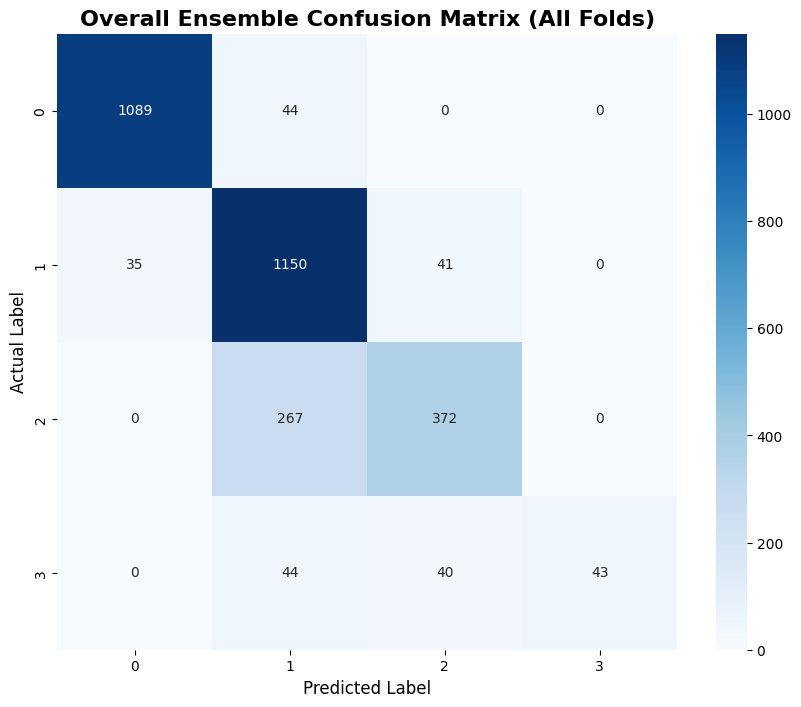

Confusion Matrix plot displayed.


--- Training Final Ensemble Model on All Data for Prediction ---

--- Training Final Bidirectional LSTM ---
Epoch 1/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.5773 - loss: 0.8087
Epoch 2/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.8957 - loss: 0.2472
Epoch 3/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.9234 - loss: 0.1924
Epoch 4/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9221 - loss: 0.1642
Epoch 5/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.9388 - loss: 0.1415
Epoch 6/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9208 - loss: 0.1995
Epoch 7/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9396 - loss: 0.1276
Epoch 8/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.9468 - loss: 0.1054
Epoch 9/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.9571 - loss: 0.0869
Epoch 10/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9289 - loss: 0.1521
Epoch 11/30
59/5

KeyboardInterrupt: 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import TimeSeriesSplit
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load and Prepare Data ---

try:
    # Load the features and target datasets
    features_df = pd.read_csv('/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_features_for_lstm.csv')
    target_df = pd.read_csv('/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_target_for_lstm.csv')

    # Convert 'Date' column to datetime objects
    features_df['Date'] = pd.to_datetime(features_df['Date'])
    target_df['Date'] = pd.to_datetime(target_df['Date'])

    # Merge the two dataframes on the 'Date' column
    df = pd.merge(features_df, target_df, on='Date')

    # Set 'Date' as the index
    df.set_index('Date', inplace=True)

    print("Data loaded and merged successfully.")
    print("DataFrame shape:", df.shape)

except FileNotFoundError as e:
    print(f"Error: {e}. Please make sure 'chennai_features_for_lstm.csv' and 'chennai_target_for_lstm.csv' are in the same directory as the script.")
    exit()


# --- 2. Preprocess the Data ---

# Separate features (X) and target (y)
X_df = df.drop('Crisis_Target_V2', axis=1)
y_df = df['Crisis_Target_V2']

# --- Diagnostic: Check Class Distribution ---
print("\n--- Class Distribution Analysis ---")
num_classes = len(y_df.unique())
print(f"Number of unique crisis levels (classes): {num_classes}")
print(f"Unique target values: {np.sort(y_df.unique())}")
print("\nOverall class distribution in the entire dataset:")
print(y_df.value_counts().sort_index())

# Validate that labels are in the correct range [0, num_classes-1]
if y_df.min() < 0:
    print(f"Error: Negative label found ({y_df.min()}). Labels must be non-negative.")
    exit()


# Scale the features to be between 0 and 1.
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X_df)

# --- 3. Create Time-Series Sequences ---
def create_dataset(X, y, time_step=1):
    dataX, dataY = [], []
    for i in range(len(X) - time_step):
        a = X[i:(i + time_step), :]
        dataX.append(a)
        dataY.append(y[i + time_step])
    return np.array(dataX), np.array(dataY)

time_step = 90
X_seq, y_seq = create_dataset(X_scaled, y_df.values, time_step)


# --- 4. Build and Train Ensemble Model with Cross-Validation ---

n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

fold_accuracies = []
all_y_test = []
all_y_pred = []

print(f"\n--- Starting {n_splits}-Fold Time-Series Cross-Validation with Ensemble Model ---")

for fold, (train_index, test_index) in enumerate(tscv.split(X_seq)):
    print(f"\n===== FOLD {fold + 1}/{n_splits} =====")
    X_train_seq, X_test_seq = X_seq[train_index], X_seq[test_index]
    y_train, y_test = y_seq[train_index], y_seq[test_index]

    # --- Handle Class Imbalance with Class Weights ---
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weights_dict = dict(enumerate(class_weights))
    print("Class Weights for this fold:", class_weights_dict)

    # --- Model 1: Bidirectional LSTM ---
    print("\n--- Training Bidirectional LSTM ---")
    lstm_model = Sequential([
        Input(shape=(time_step, X_train_seq.shape[2])),
        Bidirectional(LSTM(150, return_sequences=True)),
        Dropout(0.2),
        Bidirectional(LSTM(150, return_sequences=True)),
        Dropout(0.2),
        Bidirectional(LSTM(64)),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)

    lstm_model.fit(
        X_train_seq, y_train,
        validation_data=(X_test_seq, y_test),
        epochs=100, batch_size=64,
        class_weight=class_weights_dict,
        callbacks=[early_stopping],
        verbose=1
    )
    lstm_pred_probs = lstm_model.predict(X_test_seq)

    # --- Model 2: XGBoost ---
    print("\n--- Training XGBoost Classifier ---")
    # Reshape data for XGBoost (it expects 2D input)
    X_train_xgb = X_train_seq.reshape(X_train_seq.shape[0], -1)
    X_test_xgb = X_test_seq.reshape(X_test_seq.shape[0], -1)

    xgb_model = xgb.XGBClassifier(
        objective='multi:softprob',
        num_class=num_classes,
        eval_metric='mlogloss',
        use_label_encoder=False,
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5
    )
    xgb_model.fit(X_train_xgb, y_train)
    xgb_pred_probs = xgb_model.predict_proba(X_test_xgb)

    # --- FIX for XGBoost prediction shape mismatch ---
    # If a fold's training data is missing a class, XGBoost will output fewer columns.
    # This code block ensures the prediction array has a column for every class.
    if xgb_pred_probs.shape[1] < num_classes:
        # Get the classes the model was actually trained on
        trained_classes = xgb_model.classes_
        # Create a new array with zeros, with the correct shape
        full_probs = np.zeros((xgb_pred_probs.shape[0], num_classes))
        # Place the predicted probabilities into the correct columns
        full_probs[:, trained_classes] = xgb_pred_probs
        xgb_pred_probs = full_probs


    # --- Ensemble Prediction ---
    # Average the probabilities from both models
    ensemble_pred_probs = (lstm_pred_probs + xgb_pred_probs) / 2.0
    ensemble_pred = np.argmax(ensemble_pred_probs, axis=1)

    fold_accuracy = accuracy_score(y_test, ensemble_pred)
    fold_accuracies.append(fold_accuracy)
    print(f"\nEnsemble Accuracy for Fold {fold + 1}: {fold_accuracy:.4f}")

    all_y_test.extend(y_test)
    all_y_pred.extend(ensemble_pred)


# --- 5. Final Model Evaluation ---
print("\n\n--- Overall ENSEMBLE Model Performance (Across All Folds) ---")
print(f"Average Cross-Validation Accuracy: {np.mean(fold_accuracies):.4f} (+/- {np.std(fold_accuracies):.4f})")

# --- Overall Classification Report ---
print("\nOverall Classification Report:")
report = classification_report(all_y_test, all_y_pred, labels=np.sort(y_df.unique()), zero_division=0)
print(report)

# --- Overall Confusion Matrix ---
print("\n--- Plotting Overall Confusion Matrix ---")
cm = confusion_matrix(all_y_test, all_y_pred, labels=np.sort(y_df.unique()))
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.sort(y_df.unique()),
            yticklabels=np.sort(y_df.unique()))
plt.title('Overall Ensemble Confusion Matrix (All Folds)', fontsize=16, fontweight='bold')
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()
print("Confusion Matrix plot displayed.")


# --- 6. Train Final Ensemble Model and Make Prediction for Tomorrow ---

print("\n\n--- Training Final Ensemble Model on All Data for Prediction ---")

# --- Final LSTM Model ---
print("\n--- Training Final Bidirectional LSTM ---")
final_class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_seq), y=y_seq)
final_class_weights_dict = dict(enumerate(final_class_weights))

final_lstm_model = Sequential([
    Input(shape=(time_step, X_seq.shape[2])),
    Bidirectional(LSTM(150, return_sequences=True)), Dropout(0.2),
    Bidirectional(LSTM(150, return_sequences=True)), Dropout(0.2),
    Bidirectional(LSTM(64)), Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])
final_lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
final_lstm_model.fit(X_seq, y_seq, epochs=30, batch_size=64, class_weight=final_class_weights_dict, verbose=1)

# --- Final XGBoost Model ---
print("\n--- Training Final XGBoost Classifier ---")
X_seq_xgb = X_seq.reshape(X_seq.shape[0], -1)
final_xgb_model = xgb.XGBClassifier(
    objective='multi:softprob', num_class=num_classes, eval_metric='mlogloss',
    use_label_encoder=False, n_estimators=200, learning_rate=0.1, max_depth=5
)
final_xgb_model.fit(X_seq_xgb, y_seq)

# --- Prepare input for prediction ---
last_days_scaled = X_scaled[-time_step:]
prediction_input_seq = last_days_scaled.reshape(1, time_step, X_df.shape[1])
prediction_input_xgb = last_days_scaled.reshape(1, -1)

# --- Make final ensemble prediction ---
final_lstm_pred_probs = final_lstm_model.predict(prediction_input_seq)
final_xgb_pred_probs = final_xgb_model.predict_proba(prediction_input_xgb)
final_ensemble_probs = (final_lstm_pred_probs + final_xgb_pred_probs) / 2.0
predicted_class = np.argmax(final_ensemble_probs, axis=1)[0]

# --- Display the prediction ---
last_date_in_data = X_df.index[-1]
prediction_date = last_date_in_data + pd.Timedelta(days=1)

print("\n\n=====================================================")
print(f"      ENSEMBLE PREDICTION FOR CHENNAI WATER CRISIS")
print("=====================================================")
print(f"Based on data up to: {last_date_in_data.strftime('%Y-%m-%d')}")
print(f"Predicted Crisis Level for {prediction_date.strftime('%Y-%m-%d')}: {predicted_class}")
print("=====================================================")
print("\nCrisis Levels:")
print("0: No Crisis")
print("1: Moderate Crisis")
print("2: Severe Crisis")
print("3: Extreme Crisis")


Data loaded and merged successfully.
DataFrame shape: (3842, 144)

--- Class Distribution Analysis ---
Number of unique crisis levels (classes): 4
Unique target values: [0 1 2 3]

Overall class distribution in the entire dataset:
Crisis_Target_V2
0    1295
1    1673
2     747
3     127
Name: count, dtype: int64

--- Starting 5-Fold Time-Series Cross-Validation with Transformer Model ---

===== FOLD 1/5 =====
Class Weights for this fold: {0: np.float64(1.2901234567901234), 1: np.float64(0.5147783251231527), 2: np.float64(3.542372881355932)}
Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 873ms/step - accuracy: 0.4415 - loss: 1.0878 - val_accuracy: 0.5392 - val_loss: 1.7107
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 981ms/step - accuracy: 0.7155 - loss: 0.5796 - val_accuracy: 0.4912 - val_loss: 2.2654
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 802ms/step - accuracy: 0.8221 - loss: 0.3029 - val_accuracy: 0.5120 - val_loss: 2.1070
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 814ms/step - accuracy: 

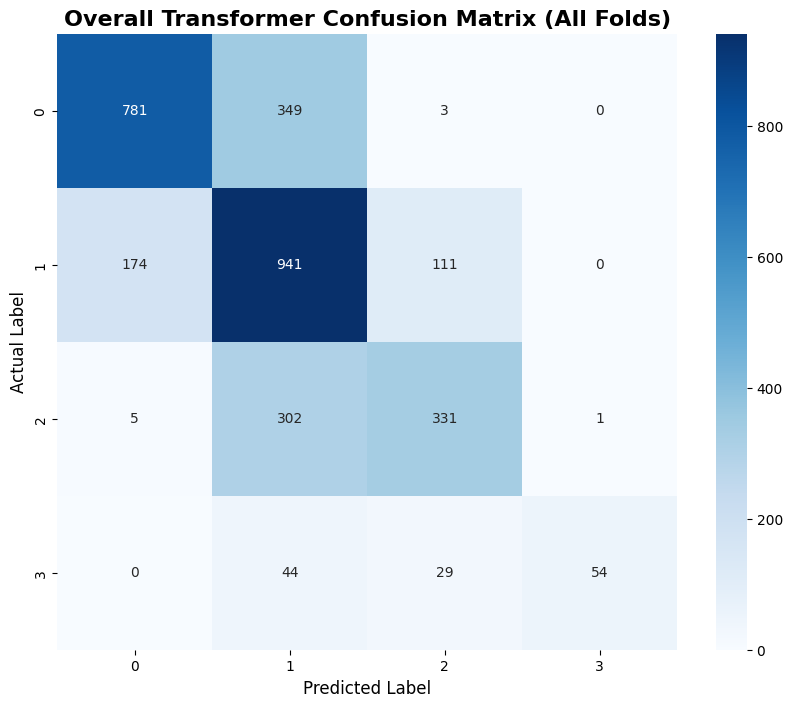

Confusion Matrix plot displayed.


--- Training Final Transformer Model on All Data for Prediction ---
Epoch 1/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 38s 570ms/step - accuracy: 0.4009 - loss: 1.1783
Epoch 2/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 35s 594ms/step - accuracy: 0.7415 - loss: 0.4746
Epoch 3/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 34s 576ms/step - accuracy: 0.8403 - loss: 0.3045
Epoch 4/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 41s 568ms/step - accuracy: 0.8775 - loss: 0.2449
Epoch 5/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 35s 599ms/step - accuracy: 0.9111 - loss: 0.1857
Epoch 6/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 41s 603ms/step - accuracy: 0.9160 - loss: 0.1626
Epoch 7/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 34s 569ms/step - accuracy: 0.9279 - loss: 0.1666
Epoch 8/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 35s 594ms/step - accuracy: 0.9466 - loss: 0.1044
Epoch 9/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 42s 603ms/step - accuracy: 0.9526 - loss: 0.1156
Epoch 10/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 39s 577ms/step - accuracy: 0.9493 - loss: 0.1119
Epoch 11/30
59/59 ━━━━━━━━

KeyboardInterrupt: 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import TimeSeriesSplit
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D, Layer
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

# --- Transformer Model Components ---

class TransformerBlock(Layer):
    """
    A custom Transformer block layer.
    This includes multi-head self-attention, feed-forward network, and layer normalization.
    """
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.att.key_dim,
            "num_heads": self.att.num_heads,
            "ff_dim": self.ffn.layers[0].units,
            "rate": self.dropout1.rate,
        })
        return config

class TokenAndPositionEmbedding(Layer):
    """
    A custom layer to add positional information to the input sequences.
    """
    def __init__(self, maxlen, embed_dim, **kwargs):
        super(TokenAndPositionEmbedding, self).__init__(**kwargs)
        self.pos_emb = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)
        self.maxlen = maxlen
        self.embed_dim = embed_dim

    def call(self, x):
        maxlen = tf.shape(x)[-2]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        return x + positions

    def get_config(self):
        config = super().get_config()
        config.update({
            "maxlen": self.maxlen,
            "embed_dim": self.embed_dim,
        })
        return config

# --- 1. Load and Prepare Data ---

try:
    # Load the features and target datasets
    features_df = pd.read_csv('/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_features_for_lstm.csv')
    target_df = pd.read_csv('/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_target_for_lstm.csv')

    # Convert 'Date' column to datetime objects
    features_df['Date'] = pd.to_datetime(features_df['Date'])
    target_df['Date'] = pd.to_datetime(target_df['Date'])

    # Merge the two dataframes on the 'Date' column
    df = pd.merge(features_df, target_df, on='Date')

    # Set 'Date' as the index
    df.set_index('Date', inplace=True)

    print("Data loaded and merged successfully.")
    print("DataFrame shape:", df.shape)

except FileNotFoundError as e:
    print(f"Error: {e}. Please make sure 'chennai_features_for_lstm.csv' and 'chennai_target_for_lstm.csv' are in the same directory as the script.")
    exit()


# --- 2. Preprocess the Data ---

# Separate features (X) and target (y)
X_df = df.drop('Crisis_Target_V2', axis=1)
y_df = df['Crisis_Target_V2']

# --- Diagnostic: Check Class Distribution ---
print("\n--- Class Distribution Analysis ---")
num_classes = len(y_df.unique())
print(f"Number of unique crisis levels (classes): {num_classes}")
print(f"Unique target values: {np.sort(y_df.unique())}")
print("\nOverall class distribution in the entire dataset:")
print(y_df.value_counts().sort_index())

# Validate that labels are in the correct range [0, num_classes-1]
if y_df.min() < 0:
    print(f"Error: Negative label found ({y_df.min()}). Labels must be non-negative.")
    exit()


# Scale the features to be between 0 and 1.
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X_df)

# --- 3. Create Time-Series Sequences ---
def create_dataset(X, y, time_step=1):
    dataX, dataY = [], []
    for i in range(len(X) - time_step):
        a = X[i:(i + time_step), :]
        dataX.append(a)
        dataY.append(y[i + time_step])
    return np.array(dataX), np.array(dataY)

time_step = 90
X_seq, y_seq = create_dataset(X_scaled, y_df.values, time_step)


# --- 4. Build and Train Transformer Model with Cross-Validation ---

n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

fold_accuracies = []
all_y_test = []
all_y_pred = []

print(f"\n--- Starting {n_splits}-Fold Time-Series Cross-Validation with Transformer Model ---")

for fold, (train_index, test_index) in enumerate(tscv.split(X_seq)):
    print(f"\n===== FOLD {fold + 1}/{n_splits} =====")
    X_train, X_test = X_seq[train_index], X_seq[test_index]
    y_train, y_test = y_seq[train_index], y_seq[test_index]

    # --- Handle Class Imbalance with Class Weights ---
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weights_dict = dict(enumerate(class_weights))
    print("Class Weights for this fold:", class_weights_dict)

    # --- Build the Transformer Model ---
    embed_dim = X_train.shape[-1] # Embedding size for each token
    num_heads = 4  # Number of attention heads
    ff_dim = 128  # Hidden layer size in feed forward network inside transformer

    inputs = Input(shape=(time_step, embed_dim))
    embedding_layer = TokenAndPositionEmbedding(time_step, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
    x = transformer_block(x)
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    transformer_model = Model(inputs=inputs, outputs=outputs)
    transformer_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)

    transformer_model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=100, batch_size=64,
        class_weight=class_weights_dict,
        callbacks=[early_stopping],
        verbose=1
    )
    pred_probs = transformer_model.predict(X_test)
    y_pred = np.argmax(pred_probs, axis=1)

    fold_accuracy = accuracy_score(y_test, y_pred)
    fold_accuracies.append(fold_accuracy)
    print(f"\nTransformer Accuracy for Fold {fold + 1}: {fold_accuracy:.4f}")

    all_y_test.extend(y_test)
    all_y_pred.extend(y_pred)


# --- 5. Final Model Evaluation ---
print("\n\n--- Overall TRANSFORMER Model Performance (Across All Folds) ---")
print(f"Average Cross-Validation Accuracy: {np.mean(fold_accuracies):.4f} (+/- {np.std(fold_accuracies):.4f})")

# --- Overall Classification Report ---
print("\nOverall Classification Report:")
report = classification_report(all_y_test, all_y_pred, labels=np.sort(y_df.unique()), zero_division=0)
print(report)

# --- Overall Confusion Matrix ---
print("\n--- Plotting Overall Confusion Matrix ---")
cm = confusion_matrix(all_y_test, all_y_pred, labels=np.sort(y_df.unique()))
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.sort(y_df.unique()),
            yticklabels=np.sort(y_df.unique()))
plt.title('Overall Transformer Confusion Matrix (All Folds)', fontsize=16, fontweight='bold')
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()
print("Confusion Matrix plot displayed.")


# --- 6. Train Final Transformer Model and Make Prediction for Tomorrow ---

print("\n\n--- Training Final Transformer Model on All Data for Prediction ---")

# --- Final Class Weights ---
final_class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_seq), y=y_seq)
final_class_weights_dict = dict(enumerate(final_class_weights))

# --- Build the final model ---
embed_dim = X_seq.shape[-1]
num_heads = 4
ff_dim = 128

final_inputs = Input(shape=(time_step, embed_dim))
final_embedding_layer = TokenAndPositionEmbedding(time_step, embed_dim)
fx = final_embedding_layer(final_inputs)
final_transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
fx = final_transformer_block(fx)
fx = GlobalAveragePooling1D()(fx)
fx = Dropout(0.2)(fx)
fx = Dense(64, activation="relu")(fx)
fx = Dropout(0.2)(fx)
final_outputs = Dense(num_classes, activation="softmax")(fx)

final_transformer_model = Model(inputs=final_inputs, outputs=final_outputs)
final_transformer_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# --- Train the final model ---
final_transformer_model.fit(X_seq, y_seq, epochs=30, batch_size=64, class_weight=final_class_weights_dict, verbose=1)

# --- Prepare input for prediction ---
last_days_scaled = X_scaled[-time_step:]
prediction_input = last_days_scaled.reshape(1, time_step, X_df.shape[1])

# --- Make final prediction ---
final_pred_probs = final_transformer_model.predict(prediction_input)
predicted_class = np.argmax(final_pred_probs, axis=1)[0]

# --- Display the prediction ---
last_date_in_data = X_df.index[-1]
prediction_date = last_date_in_data + pd.Timedelta(days=1)

print("\n\n=====================================================")
print(f"      TRANSFORMER PREDICTION FOR CHENNAI WATER CRISIS")
print("=====================================================")
print(f"Based on data up to: {last_date_in_data.strftime('%Y-%m-%d')}")
print(f"Predicted Crisis Level for {prediction_date.strftime('%Y-%m-%d')}: {predicted_class}")
print("=====================================================")
print("\nCrisis Levels:")
print("0: No Crisis")
print("1: Moderate Crisis")
print("2: Severe Crisis")
print("3: Extreme Crisis")


Data loaded and merged successfully.
DataFrame shape: (3842, 144)

--- Class Distribution Analysis ---
Number of unique crisis levels (classes): 4
Unique target values: [0 1 2 3]

Overall class distribution in the entire dataset:
Crisis_Target_V2
0    1295
1    1673
2     747
3     127
Name: count, dtype: int64

--- Starting 5-Fold Time-Series Cross-Validation with CNN-LSTM Hybrid Model ---

===== FOLD 1/5 =====
Class Weights for this fold: {0: np.float64(1.2901234567901234), 1: np.float64(0.5147783251231527), 2: np.float64(3.542372881355932)}
Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 506ms/step - accuracy: 0.3091 - loss: 1.1795 - val_accuracy: 0.3728 - val_loss: 1.6245
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 409ms/step - accuracy: 0.6318 - loss: 0.5044 - val_accuracy: 0.5072 - val_loss: 2.1931
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 533ms/step - accuracy: 0.8869 - loss: 0.2413 - val_accuracy: 0.3856 - val_loss: 3.1105
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 557ms/step - accura

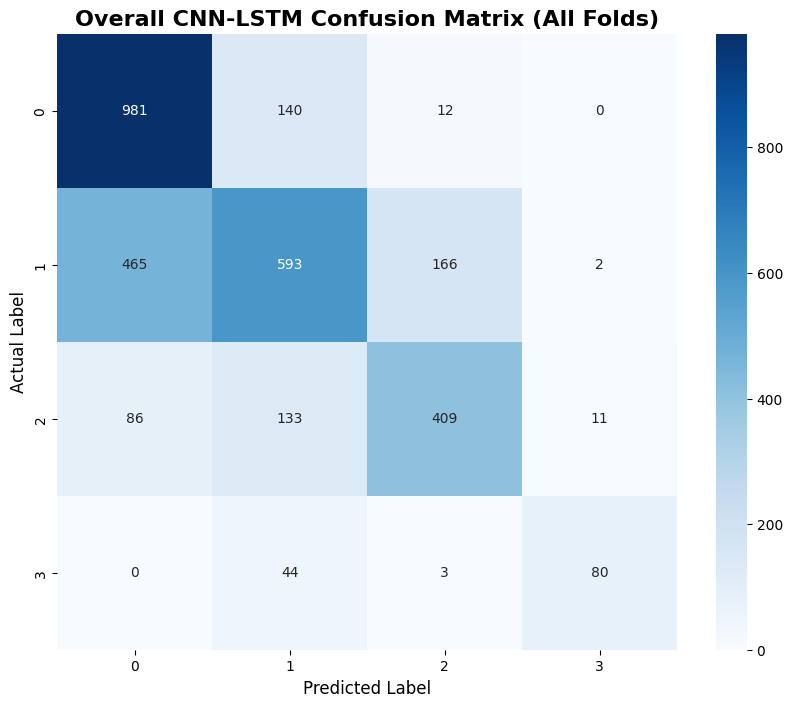

Confusion Matrix plot displayed.


--- Training Final CNN-LSTM Model on All Data for Prediction ---
Epoch 1/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 28s 315ms/step - accuracy: 0.5027 - loss: 0.9193
Epoch 2/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 18s 309ms/step - accuracy: 0.8458 - loss: 0.2944
Epoch 3/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 23s 346ms/step - accuracy: 0.8542 - loss: 0.2861
Epoch 4/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 18s 314ms/step - accuracy: 0.9037 - loss: 0.1881
Epoch 5/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 22s 341ms/step - accuracy: 0.9022 - loss: 0.1906
Epoch 6/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 18s 310ms/step - accuracy: 0.9175 - loss: 0.1577
Epoch 7/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 23s 347ms/step - accuracy: 0.9267 - loss: 0.1392
Epoch 8/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 41s 342ms/step - accuracy: 0.9230 - loss: 0.1488
Epoch 9/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 18s 311ms/step - accuracy: 0.9223 - loss: 0.1368
Epoch 10/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 21s 316ms/step - accuracy: 0.9256 - loss: 0.1270
Epoch 11/30
59/59 ━━━━━━━━━━━

KeyboardInterrupt: 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import TimeSeriesSplit
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, MaxPooling1D, Bidirectional, LSTM
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load and Prepare Data ---

try:
    # Load the features and target datasets
    features_df = pd.read_csv('/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_features_for_lstm.csv')
    target_df = pd.read_csv('/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_target_for_lstm.csv')

    # Convert 'Date' column to datetime objects
    features_df['Date'] = pd.to_datetime(features_df['Date'])
    target_df['Date'] = pd.to_datetime(target_df['Date'])

    # Merge the two dataframes on the 'Date' column
    df = pd.merge(features_df, target_df, on='Date')

    # Set 'Date' as the index
    df.set_index('Date', inplace=True)

    print("Data loaded and merged successfully.")
    print("DataFrame shape:", df.shape)

except FileNotFoundError as e:
    print(f"Error: {e}. Please make sure 'chennai_features_for_lstm.csv' and 'chennai_target_for_lstm.csv' are in the same directory as the script.")
    exit()


# --- 2. Preprocess the Data ---

# Separate features (X) and target (y)
X_df = df.drop('Crisis_Target_V2', axis=1)
y_df = df['Crisis_Target_V2']

# --- Diagnostic: Check Class Distribution ---
print("\n--- Class Distribution Analysis ---")
num_classes = len(y_df.unique())
print(f"Number of unique crisis levels (classes): {num_classes}")
print(f"Unique target values: {np.sort(y_df.unique())}")
print("\nOverall class distribution in the entire dataset:")
print(y_df.value_counts().sort_index())

# Validate that labels are in the correct range [0, num_classes-1]
if y_df.min() < 0:
    print(f"Error: Negative label found ({y_df.min()}). Labels must be non-negative.")
    exit()


# Scale the features to be between 0 and 1.
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X_df)

# --- 3. Create Time-Series Sequences ---
def create_dataset(X, y, time_step=1):
    dataX, dataY = [], []
    for i in range(len(X) - time_step):
        a = X[i:(i + time_step), :]
        dataX.append(a)
        dataY.append(y[i + time_step])
    return np.array(dataX), np.array(dataY)

time_step = 90
X_seq, y_seq = create_dataset(X_scaled, y_df.values, time_step)


# --- 4. Build and Train CNN-LSTM Hybrid Model with Cross-Validation ---

n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

fold_accuracies = []
all_y_test = []
all_y_pred = []

print(f"\n--- Starting {n_splits}-Fold Time-Series Cross-Validation with CNN-LSTM Hybrid Model ---")

for fold, (train_index, test_index) in enumerate(tscv.split(X_seq)):
    print(f"\n===== FOLD {fold + 1}/{n_splits} =====")
    X_train, X_test = X_seq[train_index], X_seq[test_index]
    y_train, y_test = y_seq[train_index], y_seq[test_index]

    # --- Handle Class Imbalance with Class Weights ---
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weights_dict = dict(enumerate(class_weights))
    print("Class Weights for this fold:", class_weights_dict)

    # --- Build the CNN-LSTM Hybrid Model ---
    model = Sequential([
        Input(shape=(time_step, X_train.shape[-1])),
        # CNN layers for feature extraction from sequences
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),
        # Bidirectional LSTM layers to learn from the extracted features
        Bidirectional(LSTM(100, return_sequences=True)),
        Dropout(0.2),
        Bidirectional(LSTM(100)),
        Dropout(0.2),
        # Final classification layers
        Dense(100, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)

    model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=100, batch_size=64,
        class_weight=class_weights_dict,
        callbacks=[early_stopping],
        verbose=1
    )
    pred_probs = model.predict(X_test)
    y_pred = np.argmax(pred_probs, axis=1)

    fold_accuracy = accuracy_score(y_test, y_pred)
    fold_accuracies.append(fold_accuracy)
    print(f"\nCNN-LSTM Accuracy for Fold {fold + 1}: {fold_accuracy:.4f}")

    all_y_test.extend(y_test)
    all_y_pred.extend(y_pred)


# --- 5. Final Model Evaluation ---
print("\n\n--- Overall CNN-LSTM Model Performance (Across All Folds) ---")
print(f"Average Cross-Validation Accuracy: {np.mean(fold_accuracies):.4f} (+/- {np.std(fold_accuracies):.4f})")

# --- Overall Classification Report ---
print("\nOverall Classification Report:")
report = classification_report(all_y_test, all_y_pred, labels=np.sort(y_df.unique()), zero_division=0)
print(report)

# --- Overall Confusion Matrix ---
print("\n--- Plotting Overall Confusion Matrix ---")
cm = confusion_matrix(all_y_test, all_y_pred, labels=np.sort(y_df.unique()))
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.sort(y_df.unique()),
            yticklabels=np.sort(y_df.unique()))
plt.title('Overall CNN-LSTM Confusion Matrix (All Folds)', fontsize=16, fontweight='bold')
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()
print("Confusion Matrix plot displayed.")


# --- 6. Train Final CNN-LSTM Model and Make Prediction for Tomorrow ---

print("\n\n--- Training Final CNN-LSTM Model on All Data for Prediction ---")

# --- Final Class Weights ---
final_class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_seq), y=y_seq)
final_class_weights_dict = dict(enumerate(final_class_weights))

# --- Build the final model ---
final_model = Sequential([
    Input(shape=(time_step, X_seq.shape[-1])),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Bidirectional(LSTM(100, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(100)),
    Dropout(0.2),
    Dense(100, activation='relu'),
    Dense(num_classes, activation='softmax')
])
final_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# --- Train the final model ---
final_model.fit(X_seq, y_seq, epochs=30, batch_size=64, class_weight=final_class_weights_dict, verbose=1)

# --- Prepare input for prediction ---
last_days_scaled = X_scaled[-time_step:]
prediction_input = last_days_scaled.reshape(1, time_step, X_df.shape[1])

# --- Make final prediction ---
final_pred_probs = final_model.predict(prediction_input)
predicted_class = np.argmax(final_pred_probs, axis=1)[0]

# --- Display the prediction ---
last_date_in_data = X_df.index[-1]
prediction_date = last_date_in_data + pd.Timedelta(days=1)

print("\n\n=====================================================")
print(f"      CNN-LSTM PREDICTION FOR CHENNAI WATER CRISIS")
print("=====================================================")
print(f"Based on data up to: {last_date_in_data.strftime('%Y-%m-%d')}")
print(f"Predicted Crisis Level for {prediction_date.strftime('%Y-%m-%d')}: {predicted_class}")
print("=====================================================")
print("\nCrisis Levels:")
print("0: No Crisis")
print("1: Moderate Crisis")
print("2: Severe Crisis")
print("3: Extreme Crisis")


Data loaded and merged successfully.
DataFrame shape: (3842, 144)

--- Class Distribution Analysis ---
Number of unique crisis levels (classes): 4
Unique target values: [0 1 2 3]

Overall class distribution in the entire dataset:
Crisis_Target_V2
0    1295
1    1673
2     747
3     127
Name: count, dtype: int64

--- Starting 5-Fold Time-Series Cross-Validation with Optimized Bi-LSTM Model ---

===== FOLD 1/5 =====
Class Weights for this fold: {0: np.float64(1.2901234567901234), 1: np.float64(0.5147783251231527), 2: np.float64(3.542372881355932)}
Epoch 1/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.5156 - loss: 1.0126 - val_accuracy: 0.4928 - val_loss: 1.3815
Epoch 2/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8743 - loss: 0.2615 - val_accuracy: 0.6512 - val_loss: 1.2777
Epoch 3/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9140 - loss: 0.1943 - val_accuracy: 0.5984 - val_loss: 1.6297
Epoch 4/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.94

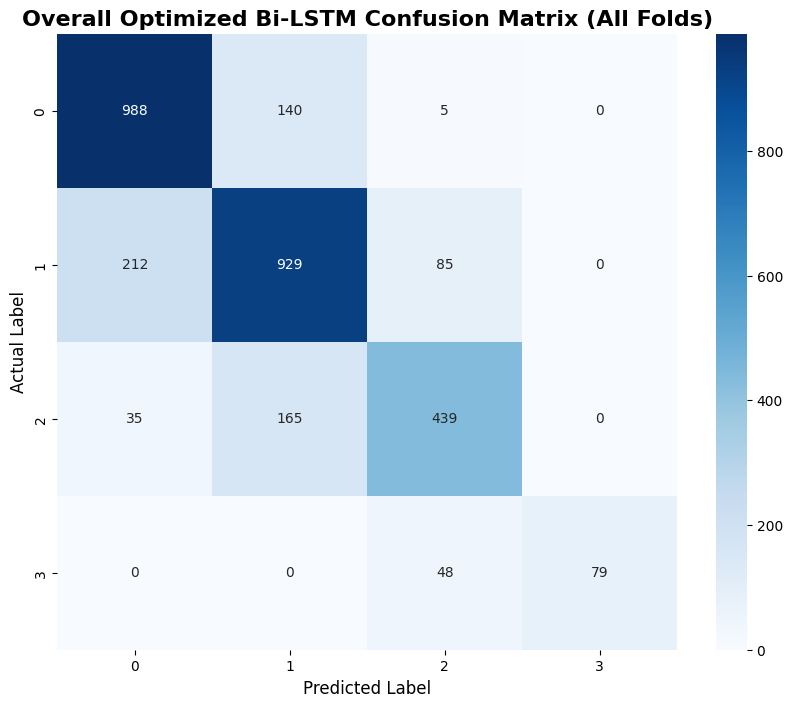

Confusion Matrix plot displayed.


--- Training Final Optimized Model on All Data for Prediction ---
Epoch 1/40
118/118 ━━━━━━━━━━━━━━━━━━━━ 101s 772ms/step - accuracy: 0.5967 - loss: 0.8469
Epoch 2/40
118/118 ━━━━━━━━━━━━━━━━━━━━ 144s 794ms/step - accuracy: 0.8962 - loss: 0.2546
Epoch 3/40
118/118 ━━━━━━━━━━━━━━━━━━━━ 92s 783ms/step - accuracy: 0.8914 - loss: 0.2726
Epoch 4/40
118/118 ━━━━━━━━━━━━━━━━━━━━ 141s 774ms/step - accuracy: 0.8837 - loss: 0.2908
Epoch 5/40
118/118 ━━━━━━━━━━━━━━━━━━━━ 143s 789ms/step - accuracy: 0.9338 - loss: 0.1497
Epoch 6/40
118/118 ━━━━━━━━━━━━━━━━━━━━ 140s 772ms/step - accuracy: 0.9387 - loss: 0.1291
Epoch 7/40
118/118 ━━━━━━━━━━━━━━━━━━━━ 93s 789ms/step - accuracy: 0.9335 - loss: 0.1504
Epoch 8/40
118/118 ━━━━━━━━━━━━━━━━━━━━ 92s 783ms/step - accuracy: 0.9332 - loss: 0.1270
Epoch 9/40
118/118 ━━━━━━━━━━━━━━━━━━━━ 142s 781ms/step - accuracy: 0.9405 - loss: 0.1154
Epoch 10/40
118/118 ━━━━━━━━━━━━━━━━━━━━ 142s 791ms/step - accuracy: 0.9493 - loss: 0.1055
E

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import TimeSeriesSplit
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Bidirectional, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load and Prepare Data ---

try:
    # Load the features and target datasets
    features_df = pd.read_csv('/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_features_for_lstm.csv')
    target_df = pd.read_csv('/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_target_for_lstm.csv')

    # Convert 'Date' column to datetime objects
    features_df['Date'] = pd.to_datetime(features_df['Date'])
    target_df['Date'] = pd.to_datetime(target_df['Date'])

    # Merge the two dataframes on the 'Date' column
    df = pd.merge(features_df, target_df, on='Date')

    # Set 'Date' as the index
    df.set_index('Date', inplace=True)

    print("Data loaded and merged successfully.")
    print("DataFrame shape:", df.shape)

except FileNotFoundError as e:
    print(f"Error: {e}. Please make sure 'chennai_features_for_lstm.csv' and 'chennai_target_for_lstm.csv' are in the same directory as the script.")
    exit()


# --- 2. Preprocess the Data ---

# Separate features (X) and target (y)
X_df = df.drop('Crisis_Target_V2', axis=1)
y_df = df['Crisis_Target_V2']

# --- Diagnostic: Check Class Distribution ---
print("\n--- Class Distribution Analysis ---")
num_classes = len(y_df.unique())
print(f"Number of unique crisis levels (classes): {num_classes}")
print(f"Unique target values: {np.sort(y_df.unique())}")
print("\nOverall class distribution in the entire dataset:")
print(y_df.value_counts().sort_index())

# Validate that labels are in the correct range [0, num_classes-1]
if y_df.min() < 0:
    print(f"Error: Negative label found ({y_df.min()}). Labels must be non-negative.")
    exit()


# Scale the features to be between 0 and 1.
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X_df)

# --- 3. Create Time-Series Sequences ---
def create_dataset(X, y, time_step=1):
    dataX, dataY = [], []
    for i in range(len(X) - time_step):
        a = X[i:(i + time_step), :]
        dataX.append(a)
        dataY.append(y[i + time_step])
    return np.array(dataX), np.array(dataY)

time_step = 90
X_seq, y_seq = create_dataset(X_scaled, y_df.values, time_step)


# --- 4. Build and Train Optimized Bidirectional LSTM with Cross-Validation ---

n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

fold_accuracies = []
all_y_test = []
all_y_pred = []

print(f"\n--- Starting {n_splits}-Fold Time-Series Cross-Validation with Optimized Bi-LSTM Model ---")

for fold, (train_index, test_index) in enumerate(tscv.split(X_seq)):
    print(f"\n===== FOLD {fold + 1}/{n_splits} =====")
    X_train, X_test = X_seq[train_index], X_seq[test_index]
    y_train, y_test = y_seq[train_index], y_seq[test_index]

    # --- Handle Class Imbalance with Class Weights ---
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weights_dict = dict(enumerate(class_weights))
    print("Class Weights for this fold:", class_weights_dict)

    # --- Build the Optimized Bidirectional LSTM Model ---
    model = Sequential([
        Input(shape=(time_step, X_train.shape[-1])),
        Bidirectional(LSTM(128, return_sequences=True)),
        Dropout(0.25),
        Bidirectional(LSTM(128, return_sequences=True)),
        Dropout(0.25),
        Bidirectional(LSTM(64)),
        Dropout(0.25),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    # Using a fine-tuned learning rate
    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)

    model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=150, # Increased epochs to allow for convergence with smaller batch size
        batch_size=32, # Using a smaller batch size
        class_weight=class_weights_dict,
        callbacks=[early_stopping],
        verbose=1
    )
    pred_probs = model.predict(X_test)
    y_pred = np.argmax(pred_probs, axis=1)

    fold_accuracy = accuracy_score(y_test, y_pred)
    fold_accuracies.append(fold_accuracy)
    print(f"\nOptimized Bi-LSTM Accuracy for Fold {fold + 1}: {fold_accuracy:.4f}")

    all_y_test.extend(y_test)
    all_y_pred.extend(y_pred)


# --- 5. Final Model Evaluation ---
print("\n\n--- Overall Optimized Bi-LSTM Model Performance (Across All Folds) ---")
print(f"Average Cross-Validation Accuracy: {np.mean(fold_accuracies):.4f} (+/- {np.std(fold_accuracies):.4f})")

# --- Overall Classification Report ---
print("\nOverall Classification Report:")
report = classification_report(all_y_test, all_y_pred, labels=np.sort(y_df.unique()), zero_division=0)
print(report)

# --- Overall Confusion Matrix ---
print("\n--- Plotting Overall Confusion Matrix ---")
cm = confusion_matrix(all_y_test, all_y_pred, labels=np.sort(y_df.unique()))
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.sort(y_df.unique()),
            yticklabels=np.sort(y_df.unique()))
plt.title('Overall Optimized Bi-LSTM Confusion Matrix (All Folds)', fontsize=16, fontweight='bold')
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()
print("Confusion Matrix plot displayed.")


# --- 6. Train Final Model and Make Prediction for Tomorrow ---

print("\n\n--- Training Final Optimized Model on All Data for Prediction ---")

# --- Final Class Weights ---
final_class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_seq), y=y_seq)
final_class_weights_dict = dict(enumerate(final_class_weights))

# --- Build the final model ---
final_model = Sequential([
    Input(shape=(time_step, X_seq.shape[-1])),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.25),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.25),
    Bidirectional(LSTM(64)),
    Dropout(0.25),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])
final_optimizer = Adam(learning_rate=0.0005)
final_model.compile(optimizer=final_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# --- Train the final model ---
final_model.fit(X_seq, y_seq, epochs=40, batch_size=32, class_weight=final_class_weights_dict, verbose=1)

# --- Prepare input for prediction ---
last_days_scaled = X_scaled[-time_step:]
prediction_input = last_days_scaled.reshape(1, time_step, X_df.shape[1])

# --- Make final prediction ---
final_pred_probs = final_model.predict(prediction_input)
predicted_class = np.argmax(final_pred_probs, axis=1)[0]

# --- Display the prediction ---
last_date_in_data = X_df.index[-1]
prediction_date = last_date_in_data + pd.Timedelta(days=1)

print("\n\n=====================================================")
print(f"      OPTIMIZED PREDICTION FOR CHENNAI WATER CRISIS")
print("=====================================================")
print(f"Based on data up to: {last_date_in_data.strftime('%Y-%m-%d')}")
print(f"Predicted Crisis Level for {prediction_date.strftime('%Y-%m-%d')}: {predicted_class}")
print("=====================================================")
print("\nCrisis Levels:")
print("0: No Crisis")
print("1: Moderate Crisis")
print("2: Severe Crisis")
print("3: Extreme Crisis")


Data loaded and merged successfully.
DataFrame shape: (3842, 144)

--- Class Distribution Analysis ---
Number of unique crisis levels (classes): 4
Unique target values: [0 1 2 3]

Overall class distribution in the entire dataset:
Crisis_Target_V2
0    1295
1    1673
2     747
3     127
Name: count, dtype: int64

--- Starting 5-Fold Time-Series Cross-Validation with Transformer-LSTM Hybrid Model ---

===== FOLD 1/5 =====
Class Weights for this fold: {0: np.float64(1.2901234567901234), 1: np.float64(0.5147783251231527), 2: np.float64(3.542372881355932)}
Epoch 1/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.4794 - loss: 0.9955 - val_accuracy: 0.6336 - val_loss: 1.6570
Epoch 2/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.7913 - loss: 0.3680 - val_accuracy: 0.5728 - val_loss: 1.5938
Epoch 3/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9103 - loss: 0.1790 - val_accuracy: 0.5184 - val_loss: 2.2669
Epoch 4/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy

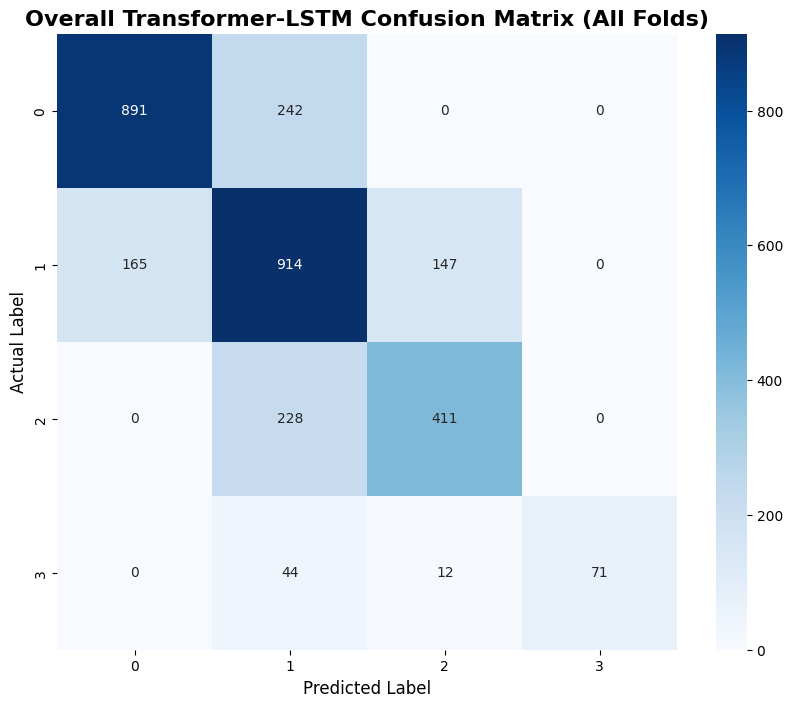

Confusion Matrix plot displayed.


--- Training Final Transformer-LSTM Model on All Data for Prediction ---
Epoch 1/40
118/118 ━━━━━━━━━━━━━━━━━━━━ 125s 934ms/step - accuracy: 0.5292 - loss: 0.9447
Epoch 2/40
118/118 ━━━━━━━━━━━━━━━━━━━━ 143s 946ms/step - accuracy: 0.8738 - loss: 0.2819
Epoch 3/40
118/118 ━━━━━━━━━━━━━━━━━━━━ 140s 930ms/step - accuracy: 0.9000 - loss: 0.2170
Epoch 4/40
118/118 ━━━━━━━━━━━━━━━━━━━━ 109s 916ms/step - accuracy: 0.9315 - loss: 0.1691
Epoch 5/40
118/118 ━━━━━━━━━━━━━━━━━━━━ 142s 916ms/step - accuracy: 0.9350 - loss: 0.1369
Epoch 6/40
118/118 ━━━━━━━━━━━━━━━━━━━━ 140s 901ms/step - accuracy: 0.9355 - loss: 0.1721
Epoch 7/40
118/118 ━━━━━━━━━━━━━━━━━━━━ 144s 915ms/step - accuracy: 0.9495 - loss: 0.1135
Epoch 8/40
118/118 ━━━━━━━━━━━━━━━━━━━━ 110s 929ms/step - accuracy: 0.9450 - loss: 0.1236
Epoch 9/40
118/118 ━━━━━━━━━━━━━━━━━━━━ 142s 930ms/step - accuracy: 0.9585 - loss: 0.0851
Epoch 10/40
118/118 ━━━━━━━━━━━━━━━━━━━━ 108s 913ms/step - accuracy: 0.9534 - loss

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import TimeSeriesSplit
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D, Layer, Bidirectional, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

# --- Transformer Model Components ---

class TransformerBlock(Layer):
    """
    A custom Transformer block layer.
    This includes multi-head self-attention, feed-forward network, and layer normalization.
    """
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.att.key_dim,
            "num_heads": self.att.num_heads,
            "ff_dim": self.ffn.layers[0].units,
            "rate": self.dropout1.rate,
        })
        return config

class TokenAndPositionEmbedding(Layer):
    """
    A custom layer to add positional information to the input sequences.
    """
    def __init__(self, maxlen, embed_dim, **kwargs):
        super(TokenAndPositionEmbedding, self).__init__(**kwargs)
        self.pos_emb = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)
        self.maxlen = maxlen
        self.embed_dim = embed_dim

    def call(self, x):
        maxlen = tf.shape(x)[-2]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        return x + positions

    def get_config(self):
        config = super().get_config()
        config.update({
            "maxlen": self.maxlen,
            "embed_dim": self.embed_dim,
        })
        return config

# --- 1. Load and Prepare Data ---

try:
    # Load the features and target datasets
    features_df = pd.read_csv('/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_features_for_lstm.csv')
    target_df = pd.read_csv('/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_target_for_lstm.csv')

    # Convert 'Date' column to datetime objects
    features_df['Date'] = pd.to_datetime(features_df['Date'])
    target_df['Date'] = pd.to_datetime(target_df['Date'])

    # Merge the two dataframes on the 'Date' column
    df = pd.merge(features_df, target_df, on='Date')

    # Set 'Date' as the index
    df.set_index('Date', inplace=True)

    print("Data loaded and merged successfully.")
    print("DataFrame shape:", df.shape)

except FileNotFoundError as e:
    print(f"Error: {e}. Please make sure 'chennai_features_for_lstm.csv' and 'chennai_target_for_lstm.csv' are in the same directory as the script.")
    exit()


# --- 2. Preprocess the Data ---

# Separate features (X) and target (y)
X_df = df.drop('Crisis_Target_V2', axis=1)
y_df = df['Crisis_Target_V2']

# --- Diagnostic: Check Class Distribution ---
print("\n--- Class Distribution Analysis ---")
num_classes = len(y_df.unique())
print(f"Number of unique crisis levels (classes): {num_classes}")
print(f"Unique target values: {np.sort(y_df.unique())}")
print("\nOverall class distribution in the entire dataset:")
print(y_df.value_counts().sort_index())

# Validate that labels are in the correct range [0, num_classes-1]
if y_df.min() < 0:
    print(f"Error: Negative label found ({y_df.min()}). Labels must be non-negative.")
    exit()


# Scale the features to be between 0 and 1.
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X_df)

# --- 3. Create Time-Series Sequences ---
def create_dataset(X, y, time_step=1):
    dataX, dataY = [], []
    for i in range(len(X) - time_step):
        a = X[i:(i + time_step), :]
        dataX.append(a)
        dataY.append(y[i + time_step])
    return np.array(dataX), np.array(dataY)

time_step = 90
X_seq, y_seq = create_dataset(X_scaled, y_df.values, time_step)


# --- 4. Build and Train Transformer-LSTM Hybrid Model with Cross-Validation ---

n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

fold_accuracies = []
all_y_test = []
all_y_pred = []

print(f"\n--- Starting {n_splits}-Fold Time-Series Cross-Validation with Transformer-LSTM Hybrid Model ---")

for fold, (train_index, test_index) in enumerate(tscv.split(X_seq)):
    print(f"\n===== FOLD {fold + 1}/{n_splits} =====")
    X_train, X_test = X_seq[train_index], X_seq[test_index]
    y_train, y_test = y_seq[train_index], y_seq[test_index]

    # --- Handle Class Imbalance with Class Weights ---
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weights_dict = dict(enumerate(class_weights))
    print("Class Weights for this fold:", class_weights_dict)

    # --- Build the Transformer-LSTM Hybrid Model ---
    embed_dim = X_train.shape[-1]
    num_heads = 4
    ff_dim = 128

    inputs = Input(shape=(time_step, embed_dim))
    embedding_layer = TokenAndPositionEmbedding(time_step, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
    x = transformer_block(x)
    # Feed the output of the Transformer into a Bidirectional LSTM
    x = Bidirectional(LSTM(128, dropout=0.25, recurrent_dropout=0.25))(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.25)(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs=inputs, outputs=outputs)
    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)

    model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=150,
        batch_size=32,
        class_weight=class_weights_dict,
        callbacks=[early_stopping],
        verbose=1
    )
    pred_probs = model.predict(X_test)
    y_pred = np.argmax(pred_probs, axis=1)

    fold_accuracy = accuracy_score(y_test, y_pred)
    fold_accuracies.append(fold_accuracy)
    print(f"\nTransformer-LSTM Accuracy for Fold {fold + 1}: {fold_accuracy:.4f}")

    all_y_test.extend(y_test)
    all_y_pred.extend(y_pred)


# --- 5. Final Model Evaluation ---
print("\n\n--- Overall Transformer-LSTM Model Performance (Across All Folds) ---")
print(f"Average Cross-Validation Accuracy: {np.mean(fold_accuracies):.4f} (+/- {np.std(fold_accuracies):.4f})")

# --- Overall Classification Report ---
print("\nOverall Classification Report:")
report = classification_report(all_y_test, all_y_pred, labels=np.sort(y_df.unique()), zero_division=0)
print(report)

# --- Overall Confusion Matrix ---
print("\n--- Plotting Overall Confusion Matrix ---")
cm = confusion_matrix(all_y_test, all_y_pred, labels=np.sort(y_df.unique()))
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.sort(y_df.unique()),
            yticklabels=np.sort(y_df.unique()))
plt.title('Overall Transformer-LSTM Confusion Matrix (All Folds)', fontsize=16, fontweight='bold')
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()
print("Confusion Matrix plot displayed.")


# --- 6. Train Final Model and Make Prediction for Tomorrow ---

print("\n\n--- Training Final Transformer-LSTM Model on All Data for Prediction ---")

# --- Final Class Weights ---
final_class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_seq), y=y_seq)
final_class_weights_dict = dict(enumerate(final_class_weights))

# --- Build the final model ---
embed_dim = X_seq.shape[-1]
num_heads = 4
ff_dim = 128

final_inputs = Input(shape=(time_step, embed_dim))
final_embedding_layer = TokenAndPositionEmbedding(time_step, embed_dim)
fx = final_embedding_layer(final_inputs)
final_transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
fx = final_transformer_block(fx)
fx = Bidirectional(LSTM(128, dropout=0.25, recurrent_dropout=0.25))(fx)
fx = Dense(64, activation="relu")(fx)
fx = Dropout(0.25)(fx)
final_outputs = Dense(num_classes, activation="softmax")(fx)

final_model = Model(inputs=final_inputs, outputs=final_outputs)
final_optimizer = Adam(learning_rate=0.0005)
final_model.compile(optimizer=final_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# --- Train the final model ---
final_model.fit(X_seq, y_seq, epochs=40, batch_size=32, class_weight=final_class_weights_dict, verbose=1)

# --- Prepare input for prediction ---
last_days_scaled = X_scaled[-time_step:]
prediction_input = last_days_scaled.reshape(1, time_step, X_df.shape[1])

# --- Make final prediction ---
final_pred_probs = final_model.predict(prediction_input)
predicted_class = np.argmax(final_pred_probs, axis=1)[0]

# --- Display the prediction ---
last_date_in_data = X_df.index[-1]
prediction_date = last_date_in_data + pd.Timedelta(days=1)

print("\n\n=====================================================")
print(f"      TRANSFORMER-LSTM PREDICTION FOR CHENNAI WATER CRISIS")
print("=====================================================")
print(f"Based on data up to: {last_date_in_data.strftime('%Y-%m-%d')}")
print(f"Predicted Crisis Level for {prediction_date.strftime('%Y-%m-%d')}: {predicted_class}")
print("=====================================================")
print("\nCrisis Levels:")
print("0: No Crisis")
print("1: Moderate Crisis")
print("2: Severe Crisis")
print("3: Extreme Crisis")


Data loaded and merged successfully.
DataFrame shape: (3842, 144)

--- Performing Advanced Feature Engineering ---
Shape after feature engineering and dropping NaNs: (3813, 261)

--- Class Distribution Analysis ---
Number of unique crisis levels (classes): 4
Unique target values: [0 1 2 3]

Overall class distribution in the entire dataset:
Crisis_Target_V2
0    1295
1    1644
2     747
3     127
Name: count, dtype: int64


/tmp/ipython-input-1450007195.py:89: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_df[f'{feature}_roll_mean_{window}'] = X_df[feature].rolling(window=window).mean()
/tmp/ipython-input-1450007195.py:90: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_df[f'{feature}_roll_sum_{window}'] = X_df[feature].rolling(window=window).sum()
/tmp/ipython-input-1450007195.py:89: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining a


--- Starting 5-Fold Time-Series Cross-Validation with Optimized Bi-LSTM Model ---

===== FOLD 1/5 =====
Class Weights for this fold: {0: np.float64(1.2818930041152263), 1: np.float64(0.5165837479270315), 2: np.float64(3.519774011299435)}
Epoch 1/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.3647 - loss: 1.0301 - val_accuracy: 0.5177 - val_loss: 1.2296
Epoch 2/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.8895 - loss: 0.2689 - val_accuracy: 0.5323 - val_loss: 1.3158
Epoch 3/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9249 - loss: 0.1571 - val_accuracy: 0.5952 - val_loss: 1.5489
Epoch 4/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9475 - loss: 0.1205 - val_accuracy: 0.5565 - val_loss: 1.5667
Epoch 5/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9544 - loss: 0.1053 - val_accuracy: 0.6258 - val_loss: 1.4021
Epoch 6/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.9582 - loss: 0.0822 - val_accuracy: 0.6306 - val_loss: 1.3205

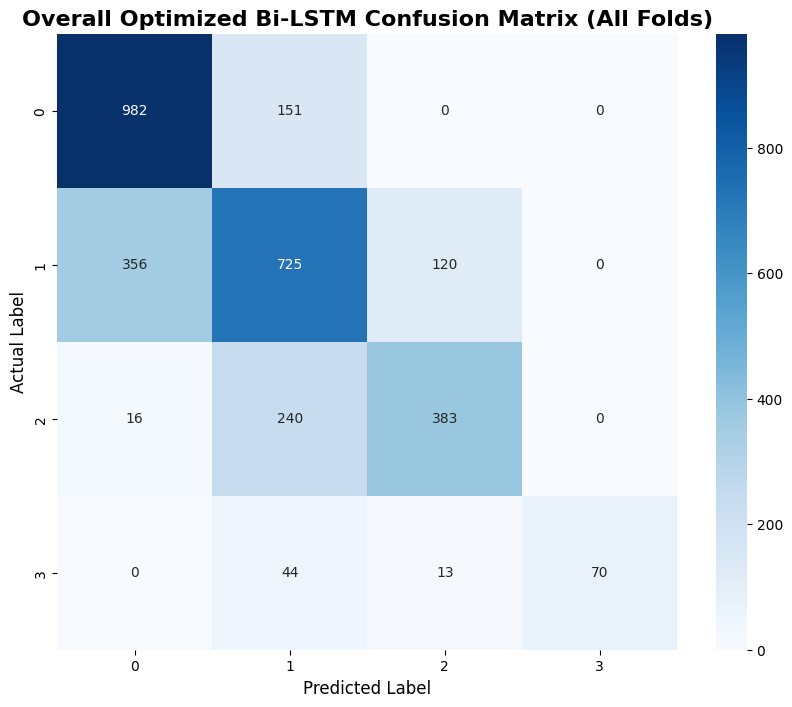

Confusion Matrix plot displayed.


--- Training Final Optimized Model on All Data for Prediction ---
Epoch 1/40
117/117 ━━━━━━━━━━━━━━━━━━━━ 116s 869ms/step - accuracy: 0.6228 - loss: 0.8291
Epoch 2/40
117/117 ━━━━━━━━━━━━━━━━━━━━ 139s 848ms/step - accuracy: 0.8692 - loss: 0.2880
Epoch 3/40
117/117 ━━━━━━━━━━━━━━━━━━━━ 145s 865ms/step - accuracy: 0.8937 - loss: 0.2099
Epoch 4/40
117/117 ━━━━━━━━━━━━━━━━━━━━ 140s 852ms/step - accuracy: 0.9046 - loss: 0.1901
Epoch 5/40
117/117 ━━━━━━━━━━━━━━━━━━━━ 143s 859ms/step - accuracy: 0.9240 - loss: 0.1372
Epoch 6/40
117/117 ━━━━━━━━━━━━━━━━━━━━ 101s 861ms/step - accuracy: 0.9323 - loss: 0.1350
Epoch 7/40
117/117 ━━━━━━━━━━━━━━━━━━━━ 140s 849ms/step - accuracy: 0.9074 - loss: 0.1859
Epoch 8/40
117/117 ━━━━━━━━━━━━━━━━━━━━ 99s 844ms/step - accuracy: 0.9350 - loss: 0.1177
Epoch 9/40
117/117 ━━━━━━━━━━━━━━━━━━━━ 143s 850ms/step - accuracy: 0.9393 - loss: 0.1247
Epoch 10/40
117/117 ━━━━━━━━━━━━━━━━━━━━ 99s 845ms/step - accuracy: 0.9462 - loss: 0.1384


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import TimeSeriesSplit
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Bidirectional, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load and Prepare Data ---

try:
    # Load the features and target datasets
    features_df = pd.read_csv('/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_features_for_lstm.csv')
    target_df = pd.read_csv('/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_target_for_lstm.csv')

    # Convert 'Date' column to datetime objects
    features_df['Date'] = pd.to_datetime(features_df['Date'])
    target_df['Date'] = pd.to_datetime(target_df['Date'])

    # Merge the two dataframes on the 'Date' column
    df = pd.merge(features_df, target_df, on='Date')

    # Set 'Date' as the index
    df.set_index('Date', inplace=True)

    print("Data loaded and merged successfully.")
    print("DataFrame shape:", df.shape)

except FileNotFoundError as e:
    print(f"Error: {e}. Please make sure 'chennai_features_for_lstm.csv' and 'chennai_target_for_lstm.csv' are in the same directory as the script.")
    exit()


# --- 2. Advanced Feature Engineering ---
print("\n--- Performing Advanced Feature Engineering ---")

# Make a copy to avoid SettingWithCopyWarning
X_df = df.drop('Crisis_Target_V2', axis=1).copy()
y_df = df['Crisis_Target_V2']

# a. Reservoir Capacity Percentage
reservoirs = ['CHEMBARAMBAKKAM', 'CHOLAVARAM', 'POONDI', 'PUZHAL', 'VEERANAM', 'KANNANKOTTAI_THERVOY_KANDIGAI']
for res in reservoirs:
    storage_col = f'Storage_mcft_{res}'
    capacity_col = f'Full_Capacity_mcft_{res}'
    if storage_col in X_df.columns and capacity_col in X_df.columns:
        # Add a small epsilon to avoid division by zero
        X_df[f'Capacity_perc_{res}'] = (X_df[storage_col] / (X_df[capacity_col] + 1e-6)) * 100

# b. Lag Features for all reservoirs and key weather metrics
lag_features = []
for res in reservoirs:
    lag_features.append(f'Rainfall_mm_{res}')
    lag_features.append(f'Inflow_cusecs_{res}')

lag_features.extend([
    'temperature_mean_celsius',
    'relative_humidity_mean_percent'
])

lags = [1, 3, 7]

for feature in lag_features:
    if feature in X_df.columns:
        for lag in lags:
            X_df[f'{feature}_lag_{lag}'] = X_df[feature].shift(lag)
    else:
        # This will skip features that don't exist (e.g., inflow for some reservoirs)
        pass


# c. Rolling Averages & Sums for all major reservoirs
rolling_features = []
for res in reservoirs:
    rolling_features.append(f'Rainfall_mm_{res}')
    rolling_features.append(f'Inflow_cusecs_{res}')

windows = [7, 14, 30]

for feature in rolling_features:
    if feature in X_df.columns:
        for window in windows:
            X_df[f'{feature}_roll_mean_{window}'] = X_df[feature].rolling(window=window).mean()
            X_df[f'{feature}_roll_sum_{window}'] = X_df[feature].rolling(window=window).sum()
    else:
        # This will skip features that don't exist (e.g., inflow for some reservoirs)
        pass


# d. Time-Based Features
X_df['month'] = X_df.index.month
X_df['week_of_year'] = X_df.index.isocalendar().week.astype(int)
X_df['day_of_year'] = X_df.index.dayofyear

# e. Interaction Features
if 'temperature_mean_celsius' in X_df.columns and 'relative_humidity_mean_percent' in X_df.columns:
    X_df['temp_humidity_interaction'] = X_df['temperature_mean_celsius'] / (X_df['relative_humidity_mean_percent'] + 1e-6)


# Drop rows with NaN values created by feature engineering
X_df.dropna(inplace=True)
y_df = y_df.loc[X_df.index]

print(f"Shape after feature engineering and dropping NaNs: {X_df.shape}")


# --- 3. Preprocess the Data ---

# --- Diagnostic: Check Class Distribution ---
print("\n--- Class Distribution Analysis ---")
num_classes = len(y_df.unique())
print(f"Number of unique crisis levels (classes): {num_classes}")
print(f"Unique target values: {np.sort(y_df.unique())}")
print("\nOverall class distribution in the entire dataset:")
print(y_df.value_counts().sort_index())

# Validate that labels are in the correct range [0, num_classes-1]
if y_df.min() < 0:
    print(f"Error: Negative label found ({y_df.min()}). Labels must be non-negative.")
    exit()


# Scale the features to be between 0 and 1.
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X_df)

# --- 4. Create Time-Series Sequences ---
def create_dataset(X, y, time_step=1):
    dataX, dataY = [], []
    for i in range(len(X) - time_step):
        a = X[i:(i + time_step), :]
        dataX.append(a)
        dataY.append(y[i + time_step])
    return np.array(dataX), np.array(dataY)

time_step = 90
X_seq, y_seq = create_dataset(X_scaled, y_df.values, time_step)


# --- 5. Build and Train Optimized Bidirectional LSTM with Cross-Validation ---

n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

fold_accuracies = []
all_y_test = []
all_y_pred = []

print(f"\n--- Starting {n_splits}-Fold Time-Series Cross-Validation with Optimized Bi-LSTM Model ---")

for fold, (train_index, test_index) in enumerate(tscv.split(X_seq)):
    print(f"\n===== FOLD {fold + 1}/{n_splits} =====")
    X_train, X_test = X_seq[train_index], X_seq[test_index]
    y_train, y_test = y_seq[train_index], y_seq[test_index]

    # --- Handle Class Imbalance with Class Weights ---
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weights_dict = dict(enumerate(class_weights))
    print("Class Weights for this fold:", class_weights_dict)

    # --- Build the Optimized Bidirectional LSTM Model ---
    model = Sequential([
        Input(shape=(time_step, X_train.shape[-1])),
        Bidirectional(LSTM(128, return_sequences=True)),
        Dropout(0.25),
        Bidirectional(LSTM(128, return_sequences=True)),
        Dropout(0.25),
        Bidirectional(LSTM(64)),
        Dropout(0.25),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    # Using a fine-tuned learning rate
    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)

    model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=150, # Increased epochs to allow for convergence with smaller batch size
        batch_size=32, # Using a smaller batch size
        class_weight=class_weights_dict,
        callbacks=[early_stopping],
        verbose=1
    )
    pred_probs = model.predict(X_test)
    y_pred = np.argmax(pred_probs, axis=1)

    fold_accuracy = accuracy_score(y_test, y_pred)
    fold_accuracies.append(fold_accuracy)
    print(f"\nOptimized Bi-LSTM Accuracy for Fold {fold + 1}: {fold_accuracy:.4f}")

    all_y_test.extend(y_test)
    all_y_pred.extend(y_pred)


# --- 6. Final Model Evaluation ---
print("\n\n--- Overall Optimized Bi-LSTM Model Performance (Across All Folds) ---")
print(f"Average Cross-Validation Accuracy: {np.mean(fold_accuracies):.4f} (+/- {np.std(fold_accuracies):.4f})")

# --- Overall Classification Report ---
print("\nOverall Classification Report:")
report = classification_report(all_y_test, all_y_pred, labels=np.sort(y_df.unique()), zero_division=0)
print(report)

# --- Overall Confusion Matrix ---
print("\n--- Plotting Overall Confusion Matrix ---")
cm = confusion_matrix(all_y_test, all_y_pred, labels=np.sort(y_df.unique()))
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.sort(y_df.unique()),
            yticklabels=np.sort(y_df.unique()))
plt.title('Overall Optimized Bi-LSTM Confusion Matrix (All Folds)', fontsize=16, fontweight='bold')
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()
print("Confusion Matrix plot displayed.")


# --- 7. Train Final Model and Make Prediction for Tomorrow ---

print("\n\n--- Training Final Optimized Model on All Data for Prediction ---")

# --- Final Class Weights ---
final_class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_seq), y=y_seq)
final_class_weights_dict = dict(enumerate(final_class_weights))

# --- Build the final model ---
final_model = Sequential([
    Input(shape=(time_step, X_seq.shape[-1])),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.25),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.25),
    Bidirectional(LSTM(64)),
    Dropout(0.25),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])
final_optimizer = Adam(learning_rate=0.0005)
final_model.compile(optimizer=final_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# --- Train the final model ---
final_model.fit(X_seq, y_seq, epochs=40, batch_size=32, class_weight=final_class_weights_dict, verbose=1)

# --- Prepare input for prediction ---
last_days_scaled = X_scaled[-time_step:]
prediction_input = last_days_scaled.reshape(1, time_step, X_df.shape[1])

# --- Make final prediction ---
final_pred_probs = final_model.predict(prediction_input)
predicted_class = np.argmax(final_pred_probs, axis=1)[0]

# --- Display the prediction ---
last_date_in_data = X_df.index[-1]
prediction_date = last_date_in_data + pd.Timedelta(days=1)

print("\n\n=====================================================")
print(f"      OPTIMIZED PREDICTION FOR CHENNAI WATER CRISIS")
print("=====================================================")
print(f"Based on data up to: {last_date_in_data.strftime('%Y-%m-%d')}")
print(f"Predicted Crisis Level for {prediction_date.strftime('%Y-%m-%d')}: {predicted_class}")
print("=====================================================")
print("\nCrisis Levels:")
print("0: No Crisis")
print("1: Moderate Crisis")
print("2: Severe Crisis")
print("3: Extreme Crisis")


Data loaded and merged successfully.
DataFrame shape: (3842, 144)

--- Performing Advanced Feature Engineering ---


/tmp/ipython-input-1322157725.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_df_full[f'{feature}_roll_mean_{window}'] = X_df_full[feature].rolling(window=window).mean()
/tmp/ipython-input-1322157725.py:78: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_df_full[f'{feature}_roll_sum_{window}'] = X_df_full[feature].rolling(window=window).sum()
/tmp/ipython-input-1322157725.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.

Shape after feature engineering: (3813, 261)

--- Performing Feature Selection with XGBoost ---


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:56:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Selected Top 75 features.

--- Class Distribution Analysis ---
Number of unique crisis levels (classes): 4
Unique target values: [0 1 2 3]

Overall class distribution in the entire dataset:
Crisis_Target_V2
0    1295
1    1644
2     747
3     127
Name: count, dtype: int64

--- Starting 5-Fold Time-Series Cross-Validation with Optimized Bi-LSTM Model ---

===== FOLD 1/5 =====
Class Weights for this fold: {0: np.float64(1.2818930041152263), 1: np.float64(0.5165837479270315), 2: np.float64(3.519774011299435)}
Epoch 1/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.5583 - loss: 1.0251 - val_accuracy: 0.4548 - val_loss: 1.0687
Epoch 2/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.8268 - loss: 0.3349 - val_accuracy: 0.5581 - val_loss: 1.2975
Epoch 3/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 26s 956ms/step - accuracy: 0.9108 - loss: 0.1876 - val_accuracy: 0.5581 - val_loss: 1.7404
Epoch 4/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 959ms/step - accuracy: 0.9550 - loss: 0.1063 - val_accuracy: 

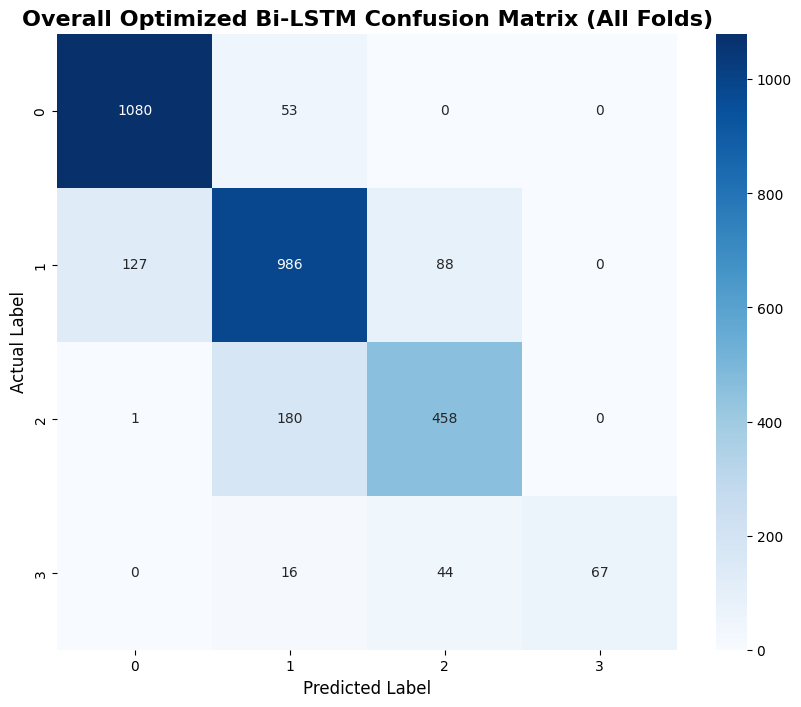

Confusion Matrix plot displayed.


--- Training Final Optimized Model on All Data for Prediction ---
Epoch 1/40
117/117 ━━━━━━━━━━━━━━━━━━━━ 101s 769ms/step - accuracy: 0.6494 - loss: 0.7900
Epoch 2/40
117/117 ━━━━━━━━━━━━━━━━━━━━ 145s 798ms/step - accuracy: 0.8986 - loss: 0.2454
Epoch 3/40
117/117 ━━━━━━━━━━━━━━━━━━━━ 92s 787ms/step - accuracy: 0.9003 - loss: 0.2247
Epoch 4/40
117/117 ━━━━━━━━━━━━━━━━━━━━ 143s 798ms/step - accuracy: 0.9268 - loss: 0.1730
Epoch 5/40
117/117 ━━━━━━━━━━━━━━━━━━━━ 141s 790ms/step - accuracy: 0.9265 - loss: 0.1749
Epoch 6/40
117/117 ━━━━━━━━━━━━━━━━━━━━ 94s 806ms/step - accuracy: 0.9271 - loss: 0.1470
Epoch 7/40
117/117 ━━━━━━━━━━━━━━━━━━━━ 140s 787ms/step - accuracy: 0.9440 - loss: 0.1315
Epoch 8/40
117/117 ━━━━━━━━━━━━━━━━━━━━ 139s 771ms/step - accuracy: 0.9410 - loss: 0.1239
Epoch 9/40
117/117 ━━━━━━━━━━━━━━━━━━━━ 144s 784ms/step - accuracy: 0.9529 - loss: 0.1119
Epoch 10/40
117/117 ━━━━━━━━━━━━━━━━━━━━ 92s 784ms/step - accuracy: 0.9398 - loss: 0.1401
E

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import TimeSeriesSplit
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Bidirectional, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load and Prepare Data ---

try:
    # Load the features and target datasets
    features_df = pd.read_csv('/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_features_for_lstm.csv')
    target_df = pd.read_csv('/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_target_for_lstm.csv')

    # Convert 'Date' column to datetime objects
    features_df['Date'] = pd.to_datetime(features_df['Date'])
    target_df['Date'] = pd.to_datetime(target_df['Date'])

    # Merge the two dataframes on the 'Date' column
    df = pd.merge(features_df, target_df, on='Date')

    # Set 'Date' as the index
    df.set_index('Date', inplace=True)

    print("Data loaded and merged successfully.")
    print("DataFrame shape:", df.shape)

except FileNotFoundError as e:
    print(f"Error: {e}. Please make sure 'chennai_features_for_lstm.csv' and 'chennai_target_for_lstm.csv' are in the same directory as the script.")
    exit()


# --- 2. Advanced Feature Engineering ---
print("\n--- Performing Advanced Feature Engineering ---")

# Make a copy to avoid SettingWithCopyWarning
X_df_full = df.drop('Crisis_Target_V2', axis=1).copy()
y_df = df['Crisis_Target_V2']

# a. Reservoir Capacity Percentage
reservoirs = ['CHEMBARAMBAKKAM', 'CHOLAVARAM', 'POONDI', 'PUZHAL', 'VEERANAM', 'KANNANKOTTAI_THERVOY_KANDIGAI']
for res in reservoirs:
    storage_col = f'Storage_mcft_{res}'
    capacity_col = f'Full_Capacity_mcft_{res}'
    if storage_col in X_df_full.columns and capacity_col in X_df_full.columns:
        X_df_full[f'Capacity_perc_{res}'] = (X_df_full[storage_col] / (X_df_full[capacity_col] + 1e-6)) * 100

# b. Lag Features for all reservoirs and key weather metrics
lag_features = []
for res in reservoirs:
    lag_features.append(f'Rainfall_mm_{res}')
    lag_features.append(f'Inflow_cusecs_{res}')
lag_features.extend(['temperature_mean_celsius', 'relative_humidity_mean_percent'])
lags = [1, 3, 7]
for feature in lag_features:
    if feature in X_df_full.columns:
        for lag in lags:
            X_df_full[f'{feature}_lag_{lag}'] = X_df_full[feature].shift(lag)

# c. Rolling Averages & Sums for all major reservoirs
rolling_features = []
for res in reservoirs:
    rolling_features.append(f'Rainfall_mm_{res}')
    rolling_features.append(f'Inflow_cusecs_{res}')
windows = [7, 14, 30]
for feature in rolling_features:
    if feature in X_df_full.columns:
        for window in windows:
            X_df_full[f'{feature}_roll_mean_{window}'] = X_df_full[feature].rolling(window=window).mean()
            X_df_full[f'{feature}_roll_sum_{window}'] = X_df_full[feature].rolling(window=window).sum()

# d. Time-Based Features
X_df_full['month'] = X_df_full.index.month
X_df_full['week_of_year'] = X_df_full.index.isocalendar().week.astype(int)
X_df_full['day_of_year'] = X_df_full.index.dayofyear

# e. Interaction Features
if 'temperature_mean_celsius' in X_df_full.columns and 'relative_humidity_mean_percent' in X_df_full.columns:
    X_df_full['temp_humidity_interaction'] = X_df_full['temperature_mean_celsius'] / (X_df_full['relative_humidity_mean_percent'] + 1e-6)

# Drop rows with NaN values created by feature engineering
X_df_full.dropna(inplace=True)
y_df = y_df.loc[X_df_full.index]

print(f"Shape after feature engineering: {X_df_full.shape}")


# --- 3. Intelligent Feature Selection using XGBoost ---
print("\n--- Performing Feature Selection with XGBoost ---")

# Train a simple XGBoost model to get feature importances
xgb_selector = xgb.XGBClassifier(objective='multi:softmax', use_label_encoder=False, eval_metric='mlogloss')
xgb_selector.fit(X_df_full, y_df)

# Get feature importances
importances = xgb_selector.feature_importances_
feature_names = X_df_full.columns

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

# Select the top N features
N_FEATURES = 75
top_features = feature_importance_df.head(N_FEATURES)['feature'].tolist()
print(f"Selected Top {N_FEATURES} features.")

# Create the final DataFrame with only the selected features
X_df = X_df_full[top_features]


# --- 4. Preprocess the Data ---

# --- Diagnostic: Check Class Distribution ---
print("\n--- Class Distribution Analysis ---")
num_classes = len(y_df.unique())
print(f"Number of unique crisis levels (classes): {num_classes}")
print(f"Unique target values: {np.sort(y_df.unique())}")
print("\nOverall class distribution in the entire dataset:")
print(y_df.value_counts().sort_index())

# Scale the selected features to be between 0 and 1.
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X_df)

# --- 5. Create Time-Series Sequences ---
def create_dataset(X, y, time_step=1):
    dataX, dataY = [], []
    for i in range(len(X) - time_step):
        a = X[i:(i + time_step), :]
        dataX.append(a)
        dataY.append(y[i + time_step])
    return np.array(dataX), np.array(dataY)

time_step = 90
X_seq, y_seq = create_dataset(X_scaled, y_df.values, time_step)


# --- 6. Build and Train Optimized Bidirectional LSTM with Cross-Validation ---

n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

fold_accuracies = []
all_y_test = []
all_y_pred = []

print(f"\n--- Starting {n_splits}-Fold Time-Series Cross-Validation with Optimized Bi-LSTM Model ---")

for fold, (train_index, test_index) in enumerate(tscv.split(X_seq)):
    print(f"\n===== FOLD {fold + 1}/{n_splits} =====")
    X_train, X_test = X_seq[train_index], X_seq[test_index]
    y_train, y_test = y_seq[train_index], y_seq[test_index]

    # --- Handle Class Imbalance with Class Weights ---
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weights_dict = dict(enumerate(class_weights))
    print("Class Weights for this fold:", class_weights_dict)

    # --- Build the Optimized Bidirectional LSTM Model ---
    model = Sequential([
        Input(shape=(time_step, X_train.shape[-1])),
        Bidirectional(LSTM(128, return_sequences=True)),
        Dropout(0.25),
        Bidirectional(LSTM(128, return_sequences=True)),
        Dropout(0.25),
        Bidirectional(LSTM(64)),
        Dropout(0.25),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)

    model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=150,
        batch_size=32,
        class_weight=class_weights_dict,
        callbacks=[early_stopping],
        verbose=1
    )
    pred_probs = model.predict(X_test)
    y_pred = np.argmax(pred_probs, axis=1)

    fold_accuracy = accuracy_score(y_test, y_pred)
    fold_accuracies.append(fold_accuracy)
    print(f"\nOptimized Bi-LSTM Accuracy for Fold {fold + 1}: {fold_accuracy:.4f}")

    all_y_test.extend(y_test)
    all_y_pred.extend(y_pred)


# --- 7. Final Model Evaluation ---
print("\n\n--- Overall Optimized Bi-LSTM Model Performance (Across All Folds) ---")
print(f"Average Cross-Validation Accuracy: {np.mean(fold_accuracies):.4f} (+/- {np.std(fold_accuracies):.4f})")

# --- Overall Classification Report ---
print("\nOverall Classification Report:")
report = classification_report(all_y_test, all_y_pred, labels=np.sort(y_df.unique()), zero_division=0)
print(report)

# --- Overall Confusion Matrix ---
print("\n--- Plotting Overall Confusion Matrix ---")
cm = confusion_matrix(all_y_test, all_y_pred, labels=np.sort(y_df.unique()))
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.sort(y_df.unique()),
            yticklabels=np.sort(y_df.unique()))
plt.title('Overall Optimized Bi-LSTM Confusion Matrix (All Folds)', fontsize=16, fontweight='bold')
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()
print("Confusion Matrix plot displayed.")


# --- 8. Train Final Model and Make Prediction for Tomorrow ---

print("\n\n--- Training Final Optimized Model on All Data for Prediction ---")

# --- Final Class Weights ---
final_class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_seq), y=y_seq)
final_class_weights_dict = dict(enumerate(final_class_weights))

# --- Build the final model ---
final_model = Sequential([
    Input(shape=(time_step, X_seq.shape[-1])),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.25),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.25),
    Bidirectional(LSTM(64)),
    Dropout(0.25),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])
final_optimizer = Adam(learning_rate=0.0005)
final_model.compile(optimizer=final_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# --- Train the final model ---
final_model.fit(X_seq, y_seq, epochs=40, batch_size=32, class_weight=final_class_weights_dict, verbose=1)

# --- Prepare input for prediction ---
last_days_scaled = X_scaled[-time_step:]
prediction_input = last_days_scaled.reshape(1, time_step, X_df.shape[1])

# --- Make final prediction ---
final_pred_probs = final_model.predict(prediction_input)
predicted_class = np.argmax(final_pred_probs, axis=1)[0]

# --- Display the prediction ---
last_date_in_data = X_df.index[-1]
prediction_date = last_date_in_data + pd.Timedelta(days=1)

print("\n\n=====================================================")
print(f"      OPTIMIZED PREDICTION FOR CHENNAI WATER CRISIS")
print("=====================================================")
print(f"Based on data up to: {last_date_in_data.strftime('%Y-%m-%d')}")
print(f"Predicted Crisis Level for {prediction_date.strftime('%Y-%m-%d')}: {predicted_class}")
print("=====================================================")
print("\nCrisis Levels:")
print("0: No Crisis")
print("1: Moderate Crisis")
print("2: Severe Crisis")
print("3: Extreme Crisis")
